#ANALYSIS OF LEARNING DYNAMICS IN NEURAL NETWORKS THROUGH LINEAR MODELS

This notebook aims to analyze the training dynamics of neural networks through the study of linear models.  
These models provide an analytical framework and allow for the examination of network behavior in a simplified yet theoretically tractable regime.  

Specifically, this notebook focuses on the phenomenon of inversion dynamics of class manifolds, a quasi-universal phenomenon recently discovered in the training dynamics of deep neural networks, which has implications for generalization and representation learning.
This phenomenon is described in the paper *Inversion Dynamics of Class Manifolds in Deep Learning Reveals Tradeoffs Underlying Generalisation* by Ciceri et al.

The networks developed are:

*   a standard feedforward network with 2 or more hidden layers
*   the linearization of the standard feedforward network
*   a standard feedforward network with 2 or more hidden layers with weights of linearized net

The linearized network is obtained via
a first-order weight expansion of the fully connected network at initialization and, in the
thermodynamic limit, its dynamics are equivalent to those of the original network.

The task of the neural networks developed is binary classification on the MNIST, KMNIST, FashionMNIST, and CIFAR10 datasets, but the code is also suitable for other image datasets that can be divided into two classes.

In this notebook, the dynamics of the gyration radii $R_\pm(t)$ of class manifolds and the inter-class distance $D(t)$ in the internal representation of the data are analyzed during training for all three networks, where $t$ denotes the epoch.

$R_\pm(t)$ measures the similarity among elements within the same class and is define by:

$$
R_{\pm}^{2}(t) = \frac{1}{2n_{\pm}^{2}}
\sum_{\mathbf{x}, \mathbf{y} \in \mathcal{M}_{\pm}(t)}
\| \mathbf{x} - \mathbf{y} \|^{2},
$$

 while $D(t)$ reflects how distinct the elements of different classes are from one another ad is equal to:

$$D(t) =
\left\|
\frac{1}{n_{+}} \sum_{\mathbf{x} \in \mathcal{M}_{+}(t)} \mathbf{x}
-
\frac{1}{n_{-}} \sum_{\mathbf{x} \in \mathcal{M}_{-}(t)} \mathbf{x}
\right\|.$$

 The behavior of these observables in the feedforward network allows verification that this network exhibits inversion dynamics similar to those described in the article *Inversion Dinamics of Class Manifolds in Deep Learning Reveals Tradeoffs Underlying Generalisation*. Performing the same investigation on the linearized network allows assessment of whether this network can effectively model inversion. Examination of the feedforward network with linearized weights provides insight into the conditions under which the linearized model constitutes a good approximation of the standard feedforward network.

The evolution of $D(t)$ and $R_\pm(t)$ is considered as a function of the training error, rather than as a function of the epoch t. This choice is motivated by the observations presented in the paper di riferimento: although the inversion epoch $t_*$ can vary significantly across different optimizers, the training error at the inversion epoch is roughly invariant with respect to optimization dynamics and hyperparameters and is independent of the specific subset of the training set used.

The hypothesis of universality of the training error at inversion is then investigated, exploring its dependence on the dataset, the observables, and the network architecture. This analysis allows evaluation of whether the phenomenon is universal for the linearized model and the feedforward network with linearized weights, and whether it holds across all three models simultaneously.

Further investigation examines the dependence of inversion on the number of data points, as well as on the depth and width of the network, for both the standard feedforward network and the linearized network.  The linearized network is examined to assess its ability to reliably model the standard feedforward network under variations of these parameters. The results conclude with an exploration of how the dynamics of the observables during training vary depending on the layer at which they are measured, for both the standard feedforward network and the linearized network.


Surprisingly, the model developed reproduces the inversion phenomenology observed in deep networks in a very similar manner, as well as other related phenomena, despite the network structure being fundamentally different. These results provide valuable insights into the mechanisms underlying the observed phenomenon.



# Notation



Notation for the networks:

* The standard feedforward neural network is often referred to as *deep* or *non lin*;

* The standard feedforward neural network with linearized weights is often referred to as *linw*;

* The linearized model is often referred to as *lin*.

Notation for the network structure:

* The size of the hidden layers is denoted by WIDTH;

* The number of layers (including the output layer but excluding the input layer) is denoted by DEPTH.

Notation for the epochs:

* the epoch is denoted by $t$

* the inversion epoch is denoted by $t_*$

Notation for the training error:

* $\epsilon_{tr}(t)$ (training error obtained from the deep network)

* $\epsilon_{tr}^{lin}(t)$ (training error obtained from lin)

* $\hat{\epsilon}_{tr}(t)$ (training error obtained from linw)

Notation for the misclassified data:

*stragglers are the data misclassified at $t_*$

* $\phi$ denotes the fraction of stragglers over total data

* $P$ denotes the number of data points used

* $\phi_\infty$ denotes $\phi$ in the limit $P \to \infty$.

# Notebook structure

The structure of the notebook is:

1. definition of the classes for neural networks and of utility functions

2. Training of the three networks and measurement of the observables $D(t)$ and $R_\pm(t)$ in the first hidden layer, as a function of the training error

3. Plot of $D(t)$ together with $R_\pm(t)$ as a function of the training error, all runs

4. Plot $D(t)$ together with $R_\pm(t)$ as a function of the training error, average over runs

5. Plot of $\epsilon_{tr}^{lin}(t)$ vs $\hat{\epsilon}_{tr}(t)$

6. Plot of $\varepsilon_{tr}(t_{})$ and $\varepsilon_{tr}^{lin}(t_{})$ at epoch of max distance vs epoch of min radius $R_+(t)$

7. Plot of $\varepsilon_{tr}(t_{})$ vs. $\varepsilon_{tr}^{lin}(t_{})$

8. lot of $\varepsilon_{tr}^{lin}(t_{})$ vs. $\hat{\varepsilon}{tr}(t{})$

9. Estimation of $\phi (P)$ for different values of $P$ and fit with power law (only deep and linear network)

10. Estimation of $\phi (P)_\infty$ for different values of WIDTH and DEPTH (only deep and linear network)

11. raining of the three networks and measurement of the observables $D(t)$ and $R_\pm(t)$ in the various layers (plots only for deep and linear network)

In [9]:
### IMPORT MODULES

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.cm as cm

import os
import math
import pandas as pd

In [10]:
### LOAD DATA
DATASET_NAME = "MNIST"

######################
# DATASET PARAMETERS #
######################
PDATA = 32768
DATA_BLOCK = 1 # Data block to use within the full data set
EPSILON = 0.000000001 # cutoff for the computation of the variance in the standardisation
dataset_mapping = {
        "MNIST": torchvision.datasets.MNIST,
        "KMNIST": torchvision.datasets.KMNIST,
        "FashionMNIST": torchvision.datasets.FashionMNIST,
        "CIFAR10": torchvision.datasets.CIFAR10,

}

tdDATASET = dataset_mapping.get(DATASET_NAME)

if tdDATASET is None:
    raise ValueError(f"Dataset '{DATASET_NAME}' not supported.")

    ######################

# Check if GPU is present and set device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("using GPU")
  !nvidia-smi
else:
  device = torch.device("cpu")
  print("using CPU")

# Download the dataset
dataset=tdDATASET("/content/", train=True, download=True,
                  transform = torchvision.transforms.ToTensor())

# Standardize the data
in_block = lambda n : (DATA_BLOCK-1)*PDATA <= n < DATA_BLOCK*PDATA # check if n is in the block
data_means = torch.mean(torch.cat([a[0] for n,a in enumerate(dataset) if in_block(n)]), dim=0)
data_vars = torch.sqrt(torch.var(torch.cat([a[0] for n,a in enumerate(dataset) if in_block(n)]), dim=0)) # with enumerate
# I can access both the index and the value of each element
transf = lambda x : (x - data_means)/(data_vars+EPSILON)

# the training set
# compose is used to apply both the conversion to tensor (torchvision.transforms.ToTensor()) and standardize the data (transf)
dataset = tdDATASET("/content/", train=True, download=True,
                    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transf]))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=PDATA, shuffle=False) # shuffling doesn't change anything, since batch_size=PDATA
# the test set
testset = tdDATASET("/content/", train=False, download=True,
                    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transf]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)


# fixed font size for all plots
plt.rcParams.update({'font.size': 18})

using GPU
Wed Nov 12 13:54:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------------

# NN classes and utilities

In questa cella vengono definite le NN classess:


*   Base NN class per calcolare le osservabili $D(t)$ ed $R_\pm(t)$
*   NN_KHL_logistic (rete con struttura di regressione, per fare la standard feedforward network di supporto alla linearized network)
*   NN_KHL_classification (rete con classica struttura di classificazione binaria, per fare la standard feedforward network)

In questa cella vengono anche definite molte funzioni utili a più celle. In questo notebook ci sono altre celle con funzioni all'inizio di alcune sezioni: si tratta di funzioni utili solo alla sezione in cui sono inserite.


In [11]:
### SETUP

# ===================================================================================================
############################################# CLASSES ################################################
# ===================================================================================================

# Base NN class
# (computes the metric observables given a latent_representation, a.k.a. the activations of a hidden layer)
class myNN(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def latent_representation(self,X):
    pass # is intended to be overridden by derived classes (like NN_KHL_logistic)

  # radii() computes both the radii and the distance between centers of mass
  def radii(self, data, labels):
    with torch.no_grad(): # no_grad disables gradinet computation during backpropagation. WHY?
      X = data[labels==0], data[labels==1]
      nump = X[0].shape[0], X[1].shape[0]
      X = self.latent_representation(X[0]), self.latent_representation(X[1]) # with self. I use the method
      # "latent-representation" of the subclass I'm in, overriding the one of the original class

      # normalization
      X = torch.nn.functional.normalize(X[0], dim=1), torch.nn.functional.normalize(X[1], dim=1)

      # computation of the metric quantities
      Xmean = torch.mean(X[0], dim=0), torch.mean(X[1], dim=0)
      radius = ( torch.sqrt(torch.sum(torch.square(X[0]-Xmean[0]))/nump[0]) ,
                 torch.sqrt(torch.sum(torch.square(X[1]-Xmean[1]))/nump[1]) )
      distance = torch.norm(Xmean[0]-Xmean[1]).item()
    return radius, distance


class NN_KHL_logistic(myNN): # inherits from the myNN class
  def __init__(self, in_size, K, N_hid, latent): # K is the number of layers, including input but excluding output
    # latent is the index of the layer (starting from 0)
    super().__init__()
    self.latent = latent
    self.layers = torch.nn.ModuleList([torch.nn.Linear(in_size, N_hid, bias=False)]) # first hidden layer
    for _ in range(K-2):
      self.layers.append(torch.nn.Linear(N_hid, N_hid, bias=False))
    self.layers.append(torch.nn.Linear(N_hid, 2, bias=False)) # output layer

  def latent_representation(self, X): # This method propagates the input only up to a certain layer (indicated by self.latent), and returns the representation (embedding) inside the network, not the final output.
    X = X.view(-1,self.layers[0].in_features) # adapts X to fit the input of the first layer (number of features)
    for l in range(self.latent):
      X = self.layers[l](X)
      # X = X/np.sqrt(self.layers[l].in_features) ## NTK PARAMETERIZATION
      X = torch.tanh(X) # activation function tanh(?)
    return X

# forward does the same as latent_representation but in the range self.latent, len(self.layers). WHY?
  def forward(self, X):
    X = self.latent_representation(X)
    for l in range(self.latent, len(self.layers)):
      X = self.layers[l](X)
      # X = X/np.sqrt(self.layers[l].in_features) ## NTK PARAMETERIZATION
      if l<len(self.layers)-1:
        X = torch.tanh(X)
    return nn.Softmax(dim=1)(X)[:,1] # outputs the probability of the one-th class


class NN_KHL_classification(myNN): # inherits from the myNN class
  def __init__(self, in_size, K, N_hid, latent): # K is the number of layers
    super().__init__()
    self.latent = latent
    self.layers = torch.nn.ModuleList([torch.nn.Linear(in_size, N_hid, bias=False)])
    for _ in range(K-2):
      self.layers.append(torch.nn.Linear(N_hid, N_hid, bias=False))
    self.layers.append(torch.nn.Linear(N_hid, 2, bias=False))

  def latent_representation(self, X): # override latent_representation
    X = X.view(-1,self.layers[0].in_features) # adapts X to fit the input of the first layer (number of features)
    for l in range(self.latent):
      X = self.layers[l](X)
      # X = X/np.sqrt(self.layers[l].in_features) ## NTK PARAMETERIZATION
      X = torch.tanh(X)
    return X

# forward does the same as latent_representation but in the range self.latent, len(self.layers).
  def forward(self, X):
    X = self.latent_representation(X)
    for l in range(self.latent, len(self.layers)):
      X = self.layers[l](X)

      if l<len(self.layers)-1:
        X = torch.tanh(X)
    return nn.Softmax(dim=1)(X) # for cross entropy. Sum by rows


#
# f(t, x) = f(t_0, x) + (t-t_0) . f'(t_0, x)
#
class linearized_NN(torch.nn.Module):
  def __init__(self, width):
    super().__init__()
    self.fc = nn.Linear(width, 1, bias=False)

  def forward(self, X):
    X = torch.squeeze(self.fc(X))
    return X



# ===================================================================================================
########################################### UTILITIES ###############################################
# ===================================================================================================

# Applies Gaussian noise to a tensor
apply_noise = lambda noise,x: torch.normal(x,noise*torch.ones_like(x))


# Returns data points and lables of the training and test set
def load_data(DATASET_NAME, PDATA, DATA_BLOCK):
  dataset_mapping = {
        "MNIST": torchvision.datasets.MNIST,
        "KMNIST": torchvision.datasets.KMNIST,
        "FashionMNIST": torchvision.datasets.FashionMNIST,
        "CIFAR10": torchvision.datasets.CIFAR10,
  }

  tdDATASET = dataset_mapping.get(DATASET_NAME)

  if tdDATASET is None:
    raise ValueError(f"Dataset '{DATASET_NAME}' not supported.")

  # Download the dataset
  full_dataset = tdDATASET("/content/", train=True, download=True,
                     transform = torchvision.transforms.ToTensor())

  # Select a specific block of data
  start_index = (DATA_BLOCK - 1) * PDATA
  end_index = start_index + PDATA

  # Ensure indices are within the dataset bounds
  if start_index >= len(full_dataset):
      raise ValueError(f"DATA_BLOCK {DATA_BLOCK} and PDATA {PDATA} result in a starting index outside the dataset.")
  if end_index > len(full_dataset):
      print(f"Warning: Requested PDATA {PDATA} for DATA_BLOCK {DATA_BLOCK} exceeds dataset size. Using {len(full_dataset) - start_index} samples.")
      end_index = len(full_dataset)


  # Create a subset of the dataset
  dataset_subset = torch.utils.data.Subset(full_dataset, range(start_index, end_index))

  # Create a DataLoader for the subset to easily get data and labels
  subset_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=len(dataset_subset), shuffle=False)
  data, labels = next(iter(subset_loader))


  # Standardize the data based on the selected block
  EPSILON = 1e-9 # cutoff for the computation of the variance in the standardisation
  data_means = torch.mean(data, dim=0)
  data_vars = torch.sqrt(torch.var(data, dim=0))
  transf = lambda x : (x - data_means)/(data_vars+EPSILON)

  # Apply standardization to the selected data block
  data = transf(data)


  # Load and standardize the test set (full test set is fine usually)
  testset = tdDATASET("/content/", train=False, download=True,
                      transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transf])) # Use the same transformation as training data
  test_loader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)
  test_data, test_labels = next(iter(test_loader))


  # Check if GPU is present and set device
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device("cpu")



  data, labels = data.to(device), labels.to(device)
  test_data, test_labels = test_data.to(device), test_labels.to(device)

  # When using CIFAR10, convert to greyscale (1 channel)
  if tdDATASET == torchvision.datasets.CIFAR10:
    def rgb_to_grayscale(data):
        r, g, b = data[:, 0, :, :], data[:, 1, :, :], data[:, 2, :, :]
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return gray.unsqueeze(1)

    data = rgb_to_grayscale(data)
    test_data = rgb_to_grayscale(test_data)

  # Binarize class labels
  labels %= 2
  test_labels %= 2

  return data, labels, test_data, test_labels


# Trains a model and returns errors, the metric quantities, misclassified examples at each epoch
def train_and_measure(model, data, labels, test_data, test_labels, optimizer, criterion, epochs):
  results_run = []
  misclassified_examples_list = []

  for epoch in range(epochs):
    optimizer.zero_grad()
    loss = criterion(model(data), labels)
    loss.backward()
    optimizer.step()

    # Compute errors and metric observables
    train_error = torch.sum(torch.abs(torch.argmax(model(data),dim=1)-labels)).item()/data.shape[0]
    test_error = torch.sum(torch.abs(torch.argmax(model(test_data),dim=1)-test_labels)).item()/len(testset)
    radii, distance = model.radii(data, labels)
    results_run.append([epoch, train_error, test_error, radii[0].item(), radii[1].item(), distance])
    misclassified_examples = torch.argmax(model(data),dim=1)-labels != 0
    misclassified_examples_list.append(misclassified_examples)

  return results_run, misclassified_examples_list


# Trains and stops when the inversion point is reached
def train_stop_at_inversion(model, data, labels, optimizer, criterion):

  radius, radius_prev = 0, 0
  count = 0
  radii = []

  # This cycle trains until the inversion point is reached.
  # The inversion point is reached when the first radius starts increasing.
  while radius<radius_prev or count<20:   # (does not halt during the initial 20 epochs to avoid being fooled by initial fluctuations)
    count += 1
    optimizer.zero_grad()
    loss = criterion(model(data), labels)
    loss.backward()
    optimizer.step()

    radius_prev = radius
    (radius, _), _ = model.radii(data, labels) # so I assign to radius the first variable returned by model.radii

# function that calculates the vector connecting the means of the two classes (called "m_array")
def m_array_input(data, labels):
    with torch.no_grad():
        data_class_0 = data[labels == 0]
        data_class_1 = data[labels == 1]
        if data_class_0.ndim > 2:
            data_class_0 = data_class_0.view(data_class_0.shape[0], -1)
            data_class_1 = data_class_1.view(data_class_1.shape[0], -1)

        mean_class_0 = torch.mean(data_class_0, dim=0)
        mean_class_1 = torch.mean(data_class_1, dim=0)
        m_array_input_space = mean_class_0 - mean_class_1

    return m_array_input_space

# function that translates the data such that the two classes are symmetric with respect to the origin
def data_normalization(data, labels):
    with torch.no_grad():
        data_class_0 = data[labels == 0]
        data_class_1 = data[labels == 1]
        if data_class_0.ndim > 2:
            # if I have N images (tensor (N, C, H, W)), I convert it to a vector (N, C*H*W)
            # so flattening each image into a single vector while keeping the number of samples (N) the same.
            data_class_0 = data_class_0.view(data_class_0.shape[0], -1)
            data_class_1 = data_class_1.view(data_class_1.shape[0], -1)

        mean_class_0 = torch.mean(data_class_0, dim=0)
        mean_class_1 = torch.mean(data_class_1, dim=0)
        traslation = 0.5*(mean_class_0 + mean_class_1)

    # Flatten data before subtraction if it's not already 1d
    if data.ndim > 2:
        data = data.view(data.shape[0], -1)
    # print ("prima", mean_class_0 + mean_class_1)
    data=data-traslation
    data_class_0_new = data[labels == 0]
    data_class_1_new = data[labels == 1]
    mean_class_0_new = torch.mean(data_class_0_new, dim=0)
    mean_class_1_new = torch.mean(data_class_1_new, dim=0)

    return data

# function that calculates the dot product between a vector and m_array
# it is used to find the projection of the data onto the line connecting the two centers of mass of the two classes
def compute_dot_angle_with_m(array_set, m_array):
    """Given a set of tensors and m_array, calculates the dot product and angle"""
    dot_products = []
    angles = []
    # checks if m_array is a PyTorch tensor and converts it to a NumPy array if it is
    if isinstance(m_array, torch.Tensor):
       m_array = m_array.cpu().numpy() #( NumPy operations are typically performed on the CPU)
    if m_array.ndim > 1:
       m_array_flat = m_array.reshape(-1)
    else:
       m_array_flat = m_array


    # Ensure array_set is a numpy array if it's a tensor
    if isinstance(array_set, torch.Tensor):
        array_set = array_set.cpu().numpy()

    # calculates the norm of m
    norm_m = np.linalg.norm(m_array_flat)

    for x in array_set:
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        if x.ndim > 1:
            x_flat = x.reshape(-1)
        else:
            x_flat = x
        # calculates the dot product between the flattened data point x_flat and the flattened m_array_flat
        dot = np.dot(x_flat, m_array_flat)
        norm_x = np.linalg.norm(x_flat)
        if norm_x == 0 or norm_m == 0:
            angle = 0.0
        else:
            cos_theta = np.clip(dot / (norm_x * norm_m), -1.0, 1.0)
            angle = np.arccos(cos_theta)
        dot_products.append(dot)
        angles.append(angle)
        # print(cos_theta)
    return np.array(dot_products), np.array(angles)

# function that calculates the mean and std of the representations of the two classes
def print_class_stats(data, labels):
    with torch.no_grad():
        data_class_0 = data[labels == 0]
        data_class_1 = data[labels == 1]

         # flatten the data
        if data_class_0.ndim > 2:
            data_class_0 = data_class_0.view(data_class_0.shape[0], -1)
            data_class_1 = data_class_1.view(data_class_1.shape[0], -1)

        # gives mean vector where each element is the mean of the corresponding feature across all data points in class 0 and 1
        mean_class_0 = torch.mean(data_class_0, dim=0)
        std_class_0 = torch.std(data_class_0, dim=0)

        mean_class_1 = torch.mean(data_class_1, dim=0)
        std_class_1 = torch.std(data_class_1, dim=0)

        print(" class statistics ")
        print(f"class 0:")
        print(f"  cean: {mean_class_0.mean().item():.4f}") # Print mean of the mean vector
        print(f"  std: {std_class_0.mean().item():.4f}") # Print mean of the std dev vector
        print(f"class 1:")
        print(f"  cean: {mean_class_1.mean().item():.4f}") # Print mean of the mean vector
        print(f"  std Dev: {std_class_1.mean().item():.4f}") # Print mean of the std dev vector

# this function computes tangent features of an initialized neural network (net)
# i.e., it calculates the gradient of the network's output with respect to its parameters
def compute_tangent_features_batch(net, theta0_dict, data):

    # list(theta0_dict.values()) extracts the parameter tensors from theta0_dict,
    # which contains the network's parameters at initialization
    # nn.utils.parameters_to_vector() concatenates all tensors into a single vector
    # detach() creates a new copy of the tensor flat_params that does not track previous operations
    # (so we compute the parameter vector relative to initialization without tracking history)
    # requires_grad_(true) ensures operations on this tensor are tracked,
    # allowing gradients with respect to it to be computed later
    flat_params = nn.utils.parameters_to_vector(list(theta0_dict.values())).detach().requires_grad_(True)

    # get the device (cpu or gpu) where flat_params is located
    device = flat_params.device

    # dictionary to map between the flattened parameter vector and the original parameter dictionary structure
    # keys stores the names of the parameters in the network's state dictionary (e.g., 'layers.0.weight', 'layers.0.bias')
    keys = list(theta0_dict.keys())
    # dictionary mapping each parameter name to its original tensor shape
    shapes = {k: theta0_dict[k].shape for k in keys}
    # dictionary mapping each parameter name to the total number of elements in that tensor
    numels = {k: theta0_dict[k].numel() for k in keys}
    # compute and store the cumulative sum of the number of elements of the parameters
    # cum is used to determine the start and end indices of each parameter in the flattened vector flat_params
    cum = np.cumsum([0] + [numels[k] for k in keys])

    # this function takes a vector and converts it back into a dictionary of parameters with original shapes
    def vec_to_params(vec):
        vec=vec.view(-1)
        out = {}
        for i, k in enumerate(keys):
            out[k] = vec[cum[i]:cum[i+1]].view(shapes[k])
        return out

    # number of input data points
    N = data.shape[0]
    # total number of flattened parameters
    P = flat_params.numel()
    # tensor to store the computed tangent features for each data point
    feats = torch.empty(N, P, device=device)

    # loop over all data points
    for i in range(N):
        x = data[i:i+1]
        # convert the flattened parameter vector back into a dictionary of parameters
        new_params = vec_to_params(flat_params)
        # forward pass of the network using the parameters new_params
        out = torch.flatten(torch.func.functional_call(net, new_params, (x,)))
        # list to store gradients
        grads = []
        # torch.autograd.grad computes the gradient of out[d] (a single output element)
        # with respect to flat_params. retain_graph=True keeps the computation graph
        # so gradients for other outputs can still be computed
        g = torch.autograd.grad(out, flat_params, retain_graph=True)[0]
        grads.append(g)
        # torch.stack(grads) stacks the D gradient tensors into a new tensor of size D x P
        # .view(-1) flattens the tensor to 1d of size P*D
        feats[i] = torch.stack(grads).view(-1)

    return feats



# def closure_fit():
#         optimizer_fit.zero_grad()
#         y_pred = power_law(x_data_tensor_width, a, b, c)
#         loss = loss_fn_fit(y_pred, y_data_tensor_width)
#         loss.backward()
#         return loss

# function that plot the mean and standard deviation of radius and distance
# as a function of training error, typically averaged over multiple runs of a training process
def plot_mean_std(data, label, color, linestyle, metric):
    runs = np.unique(data[:, 0])
    train_err_all = [] # array containing the various train_err for each run
    metric_all = [] # array containing the various distance or radius for each run
    for run in runs:
        run_data = data[data[:, 0] == run] # filters the data to get only the rows corresponding to the current run
        train_err_all.append(run_data[:, 1])
        # It extracts the specified metric_values based on the metric argument, distance or radius
        metric_values = run_data[:, 2] if metric == 'distance' else run_data[:, 3]
        metric_all.append(metric_values)
 # Training runs can vary slightly in the exact training error values reached at each epoch
 # is allows you to then easily calculate the mean and standard deviation of the metric
 # at specific training error levels across all runs, providing a more robust and averaged view of the training dynamics

    # finds the minimum number of data points across all runs
    min_len = min(len(trerr) for trerr in train_err_all)
    # creates a common axis for training error
    train_err_common = np.linspace(0, 1, min_len)
    # looks at each value in train_err_common and finds the corresponding value on the m axis,
    # based on the relationship defined by the trerr and m arrays
    # zip() pairs up the corresponding training error array and metric value array from each run
    metric_interp = np.array([np.interp(train_err_common, trerr, m) for trerr, m in zip(train_err_all, metric_all)])
    # it t calculates the mean and std of the interpolated metric values across all runs for each point on the train_err_common axis
    mean_metric = np.mean(metric_interp, axis=0)
    std_metric = np.std(metric_interp, axis=0)

    # it plots the mean metric value against the common training error axis
    plt.plot(train_err_common, mean_metric, color=color, linestyle=linestyle, linewidth=2, label=label)
    # It adds a shaded area around the mean line (mean +- std)
    plt.fill_between(train_err_common, mean_metric - std_metric, mean_metric + std_metric, color=color, alpha=0.2)

# function that defines the function with which the fit of phi as a function of PDATA is performed
def power_law(x, a, logb, c):
    x = torch.as_tensor(x, dtype=torch.float32)
    a = torch.as_tensor(a, dtype=torch.float32)
    logb = torch.as_tensor(logb, dtype=torch.float32)
    c = torch.as_tensor(c, dtype=torch.float32)
    b = torch.exp(logb)
    return a * (1 - (x / b) ** (-c))

In [ ]:
def compute_tangent_features_batch(net, theta0_dict, data):

    flat_params = nn.utils.parameters_to_vector(list(theta0_dict.values())).detach().requires_grad_(True)
    device = flat_params.device

    # Informazioni sulla struttura dei parametri
    keys = list(theta0_dict.keys())
    shapes = {k: theta0_dict[k].shape for k in keys}
    numels = {k: theta0_dict[k].numel() for k in keys}
    cum = np.cumsum([0] + [numels[k] for k in keys])

    # Funzione per riconvertire un vettore in un dizionario di parametri
    def vec_to_paramdict(vec):
        vec = vec.view(-1)  # assicura che sia 1D
        out = {}
        for i, k in enumerate(keys):
            out[k] = vec[cum[i]:cum[i + 1]].view(shapes[k])
        return out

    # Calcola l'output con i parametri attuali
    params_dict = vec_to_paramdict(flat_params)
    with torch.no_grad():
        net.load_state_dict(params_dict, strict=False)
    output = net(data)

    # Calcola il gradiente dell'output rispetto ai parametri (tangent features)
    grads = torch.autograd.grad(
        outputs=output,
        inputs=flat_params,
        grad_outputs=torch.ones_like(output),
        create_graph=False
    )[0]

    return grads

# Standard feedforwrward network
The standard feedforward neural network trained in this cell is a multi layer perceptron.

The network is fully connected: all neurons in a given layer are connected to all neurons in the preceding and subsequent layers.

The internal representation at hidden layer $l$ and epoch $t$ is given by

\begin{equation}
\mathbf{h}^{(l)}_t = \sigma\Big(\mathbf{W}^{(l)}_t \mathbf{h}^{(l-1)}_t + \mathbf{b}^{(l)}_t\Big),
\quad l = 1, \dots, L
\end{equation}

The internal representation at the last layer $L$ and epoch $t$ is given by
\begin{equation}
\hat{\mathbf{y}}_t = \mathbf{h}^{(L)}_t
= \sigma\Big( \mathbf{W}^{(L)}_t \, \mathbf{h}^{(L-1)}_t + \mathbf{b}^{(L)}_t \Big)
\end{equation}

 The activation function $\sigma$ of the last layer is Softmax, while the activation function of all other layers is the hyperbolic tangent. The final output corresponds to the probabilities of belonging to the two possible classes. The loss function used is the Binary Cross Entropy. Training updates the weight matrix of the network to minimize the error between the predicted probability distribution and the true labels.  
The weights are updated using the gradient descent optimization algorithm (SGD) computed over the entire dataset.


Forma del tensore data subito dopo il caricamento: torch.Size([8192, 1, 32, 32])
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9


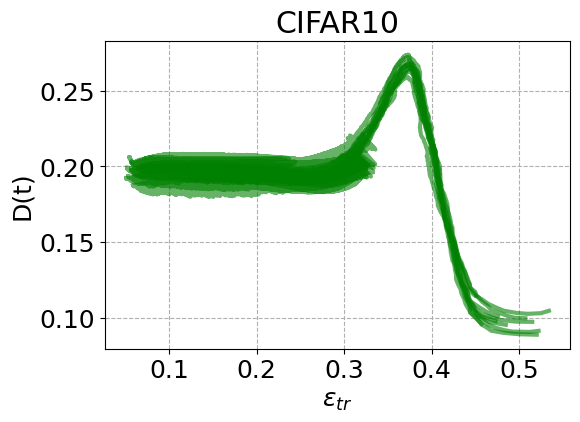

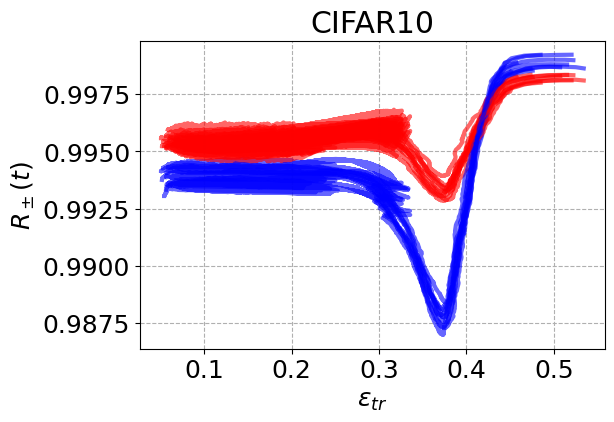

In [ ]:
DEPTH = 3 # network depth
LATENT = 1 # hidden layer where distance and radius are measured
RUNS = 10 # number of runs with independent initializations
EPOCHS = 6000 # number of epochs for each run
LEARNING_RATE = 0.1  # learning rate for optimization
OPTIMIZER = torch.optim.SGD # Gradient Descent as optimizer
WIDTHS = (40,) # number of neurons in the input layer
ORIGINAL_PDATA = 32768 # total number of data points
PDATA = ORIGINAL_PDATA // 4 # number of data points used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)
print("Forma del tensore data subito dopo il caricamento:", data.shape)
input_size = data.shape[2] * data.shape[3]

results_non_lin = []
misclassified_examples_all_runs = []
misclassified_data_max_distance_list = []
multiplier = len(WIDTHS)
max_distance_info = []
straggler_info_non_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]

# file containing data at the inversion of radius and distance
header = "Run\tepoch_max_d\ttrain_err_max_d\tmax_d\tepoch_min_r\tepoch_min_r0\ttrain_err_min_r\ttrain_err_min_r0\tmin_r\tmin_r0"

with open(f"/content/max_distance_info_non_lin_{DATASET_NAME}.txt", "w") as f: # Changed to 'w' to overwrite and ensure header is first
    f.write(header + "\n")

# perform a number of runs == RUNS for each value of WIDTHS
for run in range(RUNS * multiplier):
    WIDTH = WIDTHS[run % multiplier]

    # create network with 2-dimensional output for binary classification
    print("run:" , run)
    net = NN_KHL_classification(input_size, DEPTH, WIDTH, LATENT).to(device)
    # net_at_initalization has its own set of randomly initialized weights and biases, independent of net
    net_at_initialization = NN_KHL_classification(input_size, DEPTH, WIDTH, LATENT).to(device)
    #net.state_dict() returns a Python dictionary containing all the learnable parameters of the net model.
    #This dictionary represents the current state of the net model's parameters.
    #.load_state_dict() is a method of PyTorch models that loads parameters from a state dictionary into the model.
    initial_state = net.state_dict()
    net_at_initialization.load_state_dict(initial_state)

    #define m_array
    m_array = m_array_input(data, labels)
    # use the optimizer on the parameters linearized_net.parameters()
    optimizer = OPTIMIZER(net.parameters(), lr=LEARNING_RATE)
    # the loss used is Cross_entropy Loss
    criterion = torch.nn.CrossEntropyLoss()

    results_run = []
    misclassified_examples_run = []




    # perform EPOCHS steps with the optimizer
    for epoch in range(EPOCHS):
        #gradients are accumulated by default
        optimizer.zero_grad()
        outputs = net(data)
        # calculate the loss
        loss = criterion(outputs, labels)

        #backpropagation step
        loss.backward()
        #This line updates the parameters of the linearized_net based on the computed gradients
        optimizer.step()

        #
        train_preds = torch.argmax(outputs, dim=1)
        train_error = torch.sum(train_preds != labels).item() / data.shape[0]

        test_preds = torch.argmax(net(test_data), dim=1)
        test_error = torch.sum(test_preds != test_labels).item() / test_data.shape[0]


        # calculate R+ and R- and D at epoch t*
        radii, distance = net.radii(data, labels)
        # create array with relevant parameters to save to file later
        results_run.append([
            epoch,
            train_error,
            loss.item(),
            radii[0].item(),
            radii[1].item(),
            distance,
            WIDTH
        ])

        # create an array with misclassified data
        misclassified_mask = train_preds != labels
        misclassified_examples_run.append(misclassified_mask.cpu())

    results_non_lin.append(results_run)
    misclassified_examples_all_runs.append(misclassified_examples_run)

#arr_res_non_lin is the array with all results for each epoch
arr_res_non_lin = np.array(results_non_lin)



#==========================================================================================
  # PLOT
#==========================================================================================

# if DATASET_NAME == "CIFAR10" the D plot is separate from the R+- plot
if DATASET_NAME == "CIFAR10":
  #plot distance vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_res_non_lin)):
        dists_non_lin = arr_res_non_lin[kk, :, 5]
        train_err_non_lin = arr_res_non_lin[kk, :, 1]
        plt.plot(train_err_non_lin, dists_non_lin, color="green", linewidth=3,
                 alpha=0.6)

    plt.xlabel(r'$\epsilon_{tr}$')
    plt.ylabel('D(t)')
    plt.title(DATASET_NAME)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_non_lin_distance.pdf", bbox_inches='tight')
    plt.show()

    #plot radius vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_res_non_lin)):
        radii_non_lin = arr_res_non_lin[kk, :, 4]
        radii0_non_lin = arr_res_non_lin[kk, :, 3]
        train_err_non_lin = arr_res_non_lin[kk, :, 1]
        plt.plot(train_err_non_lin, radii_non_lin, color="red", linewidth=3,
                 alpha=0.6, label='Non-Linear Radius' if kk == 0 else "_nolegend_")
        plt.plot(train_err_non_lin, radii0_non_lin, color="b", linewidth=3,
                 alpha=0.6, label='Non-Linear Radius' if kk == 0 else "_nolegend_")


    plt.xlabel(r'$\epsilon_{tr}$')
    plt.ylabel(r'$R_\pm(t)$')
    plt.title(DATASET_NAME)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_non_lin_radius.pdf", bbox_inches='tight')
    plt.show()

else:
    # Plot for other datasets
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_res_non_lin)):
        dists_non_lin = arr_res_non_lin[kk, :, 5]
        radii_non_lin = arr_res_non_lin[kk, :, 4]
        radii0_non_lin = arr_res_non_lin[kk, :, 3]
        train_err_non_lin = arr_res_non_lin[kk, :, 1]
        plt.plot(train_err_non_lin, dists_non_lin, color="green", linewidth=3,
                 alpha=0.6, label=r'$D(t)$' if kk == 0 else "_nolegend_")
        plt.plot(train_err_non_lin, radii_non_lin, color="red", linewidth=3,
                 alpha=0.6, label=r'R+\pm(t)' if kk == 0 else "_nolegend_")
        plt.plot(train_err_non_lin, radii0_non_lin, color="orange", linewidth=3,
                 alpha=0.6, label=r'R_\pm(t)' if kk == 0 else "_nolegend_")



    plt.xlabel(r'$\epsilon_{tr}$')
    plt.ylabel('Metric Value')
    plt.title(DATASET_NAME)


    legend_elements = [
        Line2D([0], [0], color='green', linestyle='-', label=r'$D(t)$'),
        Line2D([0], [0], color='red', linestyle='-', label=r'$R_+(t)$'),
        Line2D([0], [0], color='orange', linestyle='-', label=r'$R_-(t)$')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_non_lin.pdf", bbox_inches='tight')
    plt.show()



# ==========================
# Saving to file
# ==========================
# create a matrix max_distance_info_matrix that contains data from arr but only at inversion

max_distance_info_matrix = []

for kk in range(len(arr_res_non_lin)):
    distances_for_run = arr_res_non_lin[kk, :, 5]
    epochs = arr_res_non_lin[kk, :, 0]
    train_errs = arr_res_non_lin[kk, :, 1]
    radii = arr_res_non_lin[kk, :, 4]
    radii0 = arr_res_non_lin[kk, :, 3]
    idx_max_dist = np.argmax(distances_for_run)
    idx_min_radius = np.argmin(radii)
    idx_min_radius0 = np.argmin(radii0)
    misclassified_mask_D = misclassified_examples_all_runs[kk][idx_max_dist].numpy()
    misclassified_mask_R = misclassified_examples_all_runs[kk][idx_min_radius].numpy()

    max_distance_info_matrix.append([
        kk,
        int(epochs[idx_max_dist]),
        float(train_errs[idx_max_dist]),
        float(distances_for_run[idx_max_dist]),
        int(epochs[idx_min_radius]),
        int(epochs[idx_min_radius0]),
        float(train_errs[idx_min_radius]),
        float(train_errs[idx_min_radius0]),
        float(radii[idx_min_radius]),
        float(radii0[idx_min_radius0])
    ])

max_distance_info_matrix = np.array(max_distance_info_matrix)

with open(f"/content/max_distance_info_non_lin_{DATASET_NAME}.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.4f', comments='')


with open(f"/content/{DATASET_NAME}_inf_tot_non_lin.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\n")
    for run_idx in range(len(arr_res_non_lin)):
        for epoch_idx in range(arr_res_non_lin.shape[1]):
            f.write(f"{run_idx}\t{int(arr_res_non_lin[run_idx, epoch_idx, 0])}\t{arr_res_non_lin[run_idx, epoch_idx, 1]:.10f}\t{arr_res_non_lin[run_idx, epoch_idx, 5]:.10f}\t{arr_res_non_lin[run_idx, epoch_idx, 4]:.10f}\t{arr_res_non_lin[run_idx, epoch_idx, 3]:.10f}\n")

# Linear model
The linearized neural network developed in this cell is the version linearized in the parameters $\theta$ of the standard feedforward neural network.

To construct a linearized network, one starts from a neural network with the same architecture as the standard feedforward network, but with a scalar output instead of a vector output, so that the kernel $\Theta_0 \in \mathbb{R}^{n \times n}$, where
$n$ denotes the number of examples in the dataset. The initial network is therefore defined as:


\begin{equation}
f_\theta(x): \mathbb{R}^{d_\text{in}} \to \mathbb{R},
\end{equation}


with $L$ layers and parameters $\theta = \{W^1, b^1, \dots, W^L, b^L\}$.

The initial output is:
$
f_0(\mathbf{x}) := f_{\theta_0}(x),
$
where $\theta_0$ denotes the randomly initialized weights. For each input $\mathbf{x}$, the gradient of the output with respect to all parameters is computed as:

\begin{equation}
\nabla_\theta f_0(\mathbf{x}) = \frac{\partial f_\theta(\mathbf{x})}{\partial \theta} \Big|_{\theta=\theta_0} \in \mathbb{R}^P,
\end{equation}

where $P$ is the total number of parameters.  
From the gradient of the output, one then obtains the linearization of the network around $\theta_0$:

\begin{equation}
f^{\text{lin}}_t(\mathbf{x}) = f_0(\mathbf{x}) + \nabla_\theta f_0(\mathbf{x}) \big|_{\theta = \theta_0} \, \omega_t
\end{equation}

The network used contains only linear activation functions, since the nonlinearity of the original model is already captured by the gradients computed at initialization. Introducing explicit activation functions would break the linearization assumption and yield a nonlinear model.  
The loss function employed is the mean squared errron (MSE).  
The network output is a single value $\hat{y} = \sigma(f_\text{lin}(x)) \in [0,1]$, which allows predicting the label as:


\begin{equation}
\hat{y}_{\mathrm{pred}} =
\begin{cases}
0 & \text{se } \hat{y} < 0.5,\\
1 & \text{se } \hat{y} \ge 0.5.
\end{cases}
\end{equation}
The structure is therefore that of a regression model, even though the network is used for classification. In this way, the network is simpler, and the considerations discussed in Section \ref{paragrafo_linearizzata} can be applied.

Similarly, training is performed using the batch gradient descent optimization algorithm and is performed on the parameter gradients rather than on the internal representations. More specifically, the updates are computed with respect to the gradients evaluated at initialization, which remain fixed throughout the optimization process.

The network outputs evolve according to the fixed tangent kernel $\Theta_0$. Consequently, while the weights $\theta$ change over time, the internal representations and the tangent kernel $\Theta_0$ remain constant.  
Note that the linearization is a function linear in the weight variations, and optimizing the linearized network corresponds to optimizing only the variations $\Delta \theta$.

Hence, the training dynamics are linear in the parameters and differ from those of the full deep network, although they coincide in the infinite-width limit.

The contributions of all layers are computed in parallel via the gradients at initialization. Indeed, the intermediate layers of the original network are no longer applied recursively, but contribute linearly through the weight gradients. Furthermore, the output is the linear sum of the contributions of all weights.  

The linearized model of the neural network therefore does not have internal representations, but the original setup for studying the observables $D$ and $R_\pm$ involves analyzing how a neural network processes data in its hidden layers. It is not possible to use the current definitions of the observables for the linearized network.  

To define new observables suitable for the linearized model, one can introduce the weights $\theta_t$ obtained from the training of the linearized network into a standard feedforward network.  

Since the linearization is a function linear in the weight variations, the weights of the full network can be reconstructed by adding the linear variation to the initialization:

\begin{equation}
    \theta_{\text{net}} = \theta_0 + \theta_{\text{lin}}
\end{equation}

where $\theta_{\text{lin}}$ denotes the weights obtained from training the linearized network.  

The new observables are then:

\begin{equation}
\begin{cases}
D_{\mathrm{net}} = D(\theta_{\mathrm{net}}),\\[1mm]
R_{\mathrm{lin}} = R(\theta_{\mathrm{lin}})
\end{cases}
\end{equation}

Shape of data right after loading: torch.Size([8192, 1, 32, 32])
 class statistics 
class 0:
  cean: 0.0358
  std: 0.9253
class 1:
  cean: -0.0358
  std Dev: 1.0125
run: 0
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9


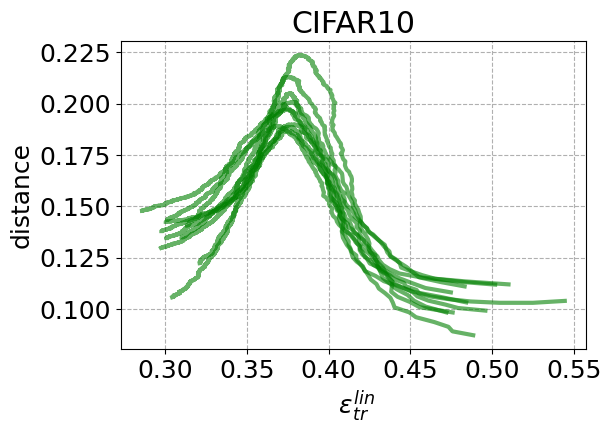

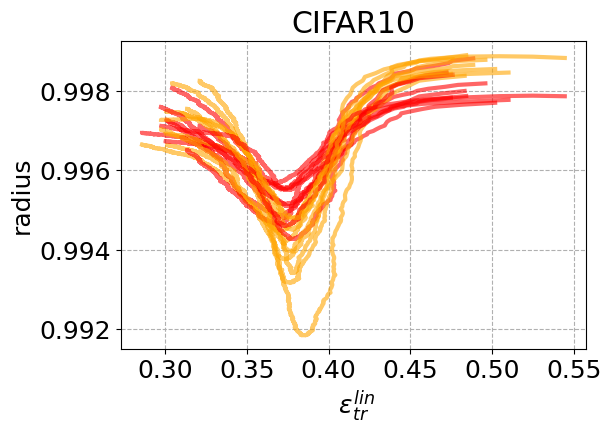

In [ ]:

DEPTH = 3
LATENT = 1
RUNS = 10
EPOCHS = 6000
LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD
WIDTHS = (40,)
ORIGINAL_PDATA = 32768
PDATA = ORIGINAL_PDATA // 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

misclassified_examples_all_runs = []
misclassified_data_max_distance_list = []
data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

print("Shape of data right after loading:", data.shape)
input_size = data.shape[2] * data.shape[3]


data, labels = data.to(device), labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)
labels_float = labels.float()


data = data_normalization(data, labels)
test_data = data_normalization(test_data, test_labels)
print_class_stats(data, labels)

# Calculate m_array
m_array = m_array_input(data, labels)
m_array_flat = nn.utils.parameters_to_vector(m_array)


# File for max_distance info

header = "Run\tepoch_max_d\ttrain_err_max_d\tmax_d\tepoch_min_r\tepoch_min_r0\ttrain_err_min_r\ttrain_err_min_r0\tmin_r\tmin_r0"
with open(f"/content/max_distance_info_lin_{DATASET_NAME}_lr_0.1.txt", "w") as f:
    f.write(header + "\n")



results_lin = []
misclassified_all_runs = []
max_distance_info = []

# perform a number of runs == RUNS for each value of WIDTHS
for run in range(RUNS * len(WIDTHS)):
    WIDTH = WIDTHS[run % len(WIDTHS)]

    # create network with 1-dimensional output for linearization
    print("run:" , run)
    net = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
    # net_at_init has its own set of randomly initialized weights and biases, independent of net
    net_at_init = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
    #net.state_dict() returns a Python dictionary containing all the learnable parameters of the net model.
    #This dictionary represents the current state of the net model's parameters.
    #.load_state_dict() is a method of PyTorch models that loads parameters from a state dictionary into the model.
    net_at_init.load_state_dict(net.state_dict())

    #these two lines are uset to  get the parameters of the neural network net at its initial state (before training starts for this run)
    # and store them in two different formats: a dictionary and a single flattened vector.
    # net.named_parameter returns an iterator that yields pairs of (name, parameter) for each learnable parameter in the model
    #net.named_parameters dict converts this iterator into a Python dictionary
    theta0_dict = dict(net.named_parameters())
    theta0_flat = nn.utils.parameters_to_vector(list(net.parameters())).detach()

    # function that calculates tangent features
    features = compute_tangent_features_batch(net, theta0_dict, data)


    # linearize the network with a layer of size features.shape[1] neurons
    linearized_net = linearized_NN(features.shape[1]).to(device)
    # use the optimizer on the parameters linearized_net.parameters()
    optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)
    # the loss used is the mean squared error
    criterion = torch.nn.MSELoss()

    results_run = []
    miscls_run = []
    # perform EPOCHS steps with the optimizer
    for epoch in range(EPOCHS):
        #gradients are accumulated by default
        optimizer.zero_grad()

        # do not calculate gradient here
        with torch.no_grad():
            #the input data (data) is passed through net_at_init
            net_base = net_at_init(data)

        #linearized_net(features) represents the change in the original network's output from its initial state
        #This sum pred_lin is the linearized model's prediction of the current output of the full network
        pred_lin = linearized_net(features) + net_base
        # calculate the loss
        loss_lin = criterion(pred_lin, labels_float)
        #backpropagation step
        loss_lin.backward()
        #This line updates the parameters of the linearized_net based on the computed gradients
        optimizer.step()


        #These lines are taking the weights learned by the linearized_net and using them to update the weights of the original net model
        #linearized_net represent the change in the original network's weights from their initial values. By adding the squeezed
        #weights of the linearized_net to the initial flattened weights , you are calculating the updated weights of the full network.
        new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
        #nn.utils.vector_to_parameters is a function that takes new_weights and copies its values into the individual parameter
        #tensors of the net model, respecting their original shapes and order
        nn.utils.vector_to_parameters(new_weights, net.parameters())

        with torch.no_grad():
          # calculate training error on the linearized model
          # if pred_lin(data) >= 0.5, then train_preds is True and True.float()=1, the predicted label is 1, zero otherwise
            train_preds = (pred_lin >= 0.5).float()
            train_err = torch.abs(train_preds - labels_float).mean().item()
            # calculate R* and R- and D
            radii, distance = net.radii(data, labels)


        # create array with relevant parameters to save to file later
        results_run.append([
            epoch,
            train_err,
            loss_lin.item(),
            radii[0].item(),
            radii[1].item(),
            distance,
            WIDTH
        ])


    results_lin.append(results_run)

#arr_res_lin is the array with all results for each epoch
arr_res_lin = np.array(results_lin)


#plot
arr_lin = np.array(results_lin, dtype=float)


file_path_non_lin = f'/content/inf_tot_non_lin.txt'
arr_res_non_lin = None
try:

    data_non_lin = np.loadtxt(file_path_non_lin, skiprows=1, usecols=(0, 2, 3, 4)) # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col 4)
    epochs_per_run_non_lin = data_non_lin.shape[0] // RUNS
    arr_res_non_lin = data_non_lin.reshape(RUNS, epochs_per_run_non_lin, 4)

except FileNotFoundError:
    print(f"Warning: File not found for non-linear data: {file_path_non_lin}. Non-linear data will not be plotted.")
except Exception as e:
    print(f"An error occurred loading non-linear data: {e}. Non-linear data will not be plotted.")



#==========================================================================================
  # PLOT
#==========================================================================================

# if DATASET_NAME == "CIFAR10" the D plot is separate from the R+- plot
if DATASET_NAME == "CIFAR10":
  #plot distance vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_lin)):
        dists_lin = arr_lin[kk, :, 5]
        train_err_lin = arr_lin[kk, :, 1]
        plt.plot(train_err_lin, dists_lin, color="g", linewidth=3,
                 alpha=0.6)


    plt.xlabel(r' $\epsilon_{tr}^{lin}$')
    plt.ylabel('distance')
    plt.title(DATASET_NAME)

    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_lin_distance.pdf", bbox_inches='tight')
    plt.show()


    #plot radius vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_lin)):
        radii_lin = arr_lin[kk, :, 4]
        radii0_lin = arr_lin[kk, :, 3]
        train_err_lin = arr_lin[kk, :, 1]
        plt.plot(train_err_lin, radii_lin, color="r", linewidth=3,
                 alpha=0.6)
        plt.plot(train_err_lin, radii0_lin, color="orange", linewidth=3,
                 alpha=0.6)
    plt.xlabel(r' $\epsilon_{tr}^{lin}$')
    plt.ylabel('radius')
    plt.title(DATASET_NAME)

    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_lin_radius.pdf", bbox_inches='tight')
    plt.show()

else:
    # Plot for other datasets
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr_lin)):
        dists_lin = arr_lin[kk, :, 5]
        radii_lin = arr_lin[kk, :, 4]
        radii0_lin = arr_lin[kk, :, 3]
        train_err_lin = arr_lin[kk, :, 1]
        plt.plot(train_err_lin, dists_lin, color="g", linewidth=3,
                 alpha=0.6)
        plt.plot(train_err_lin, radii_lin, color="r", linewidth=3,
                 alpha=0.6)
        plt.plot(train_err_lin, radii0_lin, color="orange", linewidth=3,
                 alpha=0.6)

    plt.xlabel(r' $\epsilon_{tr}^{lin}$')
    plt.ylabel('metric value')
    plt.title(DATASET_NAME)


    legend_elements = [
        Line2D([0], [0], color='green', linestyle='-', label=r'$D(t)$'),
        Line2D([0], [0], color='red', linestyle='-', label=r'$R_+(t)$'),
        Line2D([0], [0], color='orange', linestyle='-', label=r'$R_-(t)$')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_lin.pdf", bbox_inches='tight')
    plt.ylim([0, 1.65])
    plt.xlim((0, 0.65))
    plt.show()

# ==========================
# Saving to file
# ==========================
# create a matrix max_distance_info_matrix that contains data from arr but only at inversion

max_distance_info_matrix = []

for kk in range(len(arr_lin)):
    dists = arr_lin[kk, :, 5]
    epochs = arr_lin[kk, :, 0]
    train_errs = arr_lin[kk, :, 1]
    radii = arr_lin[kk, :, 4]
    radii0 = arr_lin[kk, :, 3]
    idx_max_dist = np.argmax(dists)
    idx_min_radius = np.argmin(radii)
    idx_min_radius0 = np.argmin(radii0)


    max_distance_info_matrix.append([
        kk,
        int(epochs[idx_max_dist]),
        float(train_errs[idx_max_dist]),
        float(dists[idx_max_dist]),
        int(epochs[idx_min_radius]),
        int(epochs[idx_min_radius0]),
        float(train_errs[idx_min_radius]),
        float(train_errs[idx_min_radius0]),
        float(radii[idx_min_radius]),
        float(radii0[idx_min_radius0])
    ])

max_distance_info_matrix = np.array(max_distance_info_matrix)

with open(f"/content/max_distance_info_lin_{DATASET_NAME}_lr_0.1.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.10f', comments='') # Increased precision

# Save train_err, dists, and radii for all epochs and runs to inf_tot_lin.txt
with open(f"/content/{DATASET_NAME}_inf_tot_lin_lr_0.1.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\n")
    for run_idx in range(len(arr_lin)):
        for epoch_idx in range(arr_lin.shape[1]):
            f.write(f"{run_idx}\t{int(arr_lin[run_idx, epoch_idx, 0])}\t{arr_lin[run_idx, epoch_idx, 1]:.10f}\t{arr_lin[run_idx, epoch_idx, 5]:.10f}\t{arr_lin[run_idx, epoch_idx, 4]:.10f}\t{arr_lin[run_idx, epoch_idx, 3]:.10f}\n") # Increased precision

# standard feedforward network with linearized weights
This neural network has the same architecture as a standard neural network, but the weights used are obtained from training the linearized network. The training error is computed on the deep network.  

To obtain this network, one starts from a network with a structure analogous to that of the standard neural network, but with a scalar output, and constructs the corresponding linearized network. The linearized network is then trained, and its weights are subsequently transferred to the deep network.  

Finally, the training error is evaluated on the deep network.


Shape of data right after load: torch.Size([8192, 1, 28, 28])
 class statistics 
class 0:
  cean: 0.0426
  std: 0.8077
class 1:
  cean: -0.0426
  std Dev: 0.7505
run:  0
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
run:  7
run:  8
run:  9


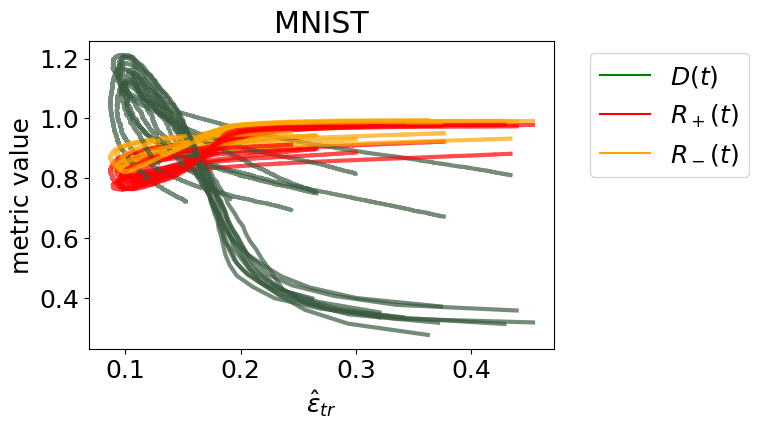

In [ ]:
DEPTH = 3 # network depth
LATENT = 1 # hidden layer where distance and radius are measured
RUNS = 10 # number of runs with independent initializations
EPOCHS = 6000 # number of epochs for each run
LEARNING_RATE = 0.1  # learning rate for optimization
OPTIMIZER = torch.optim.SGD # Gradient Descent as optimizer
WIDTHS = (40,) # number of neurons in the input layer
ORIGINAL_PDATA = 32768 # total number of data points
PDATA = ORIGINAL_PDATA // 4 # number of data points used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

print("Shape of data right after load:", data.shape)
input_size = data.shape[2] * data.shape[3] # input layer size data.shape[2] * data.shape[3]


data, labels = data.to(device), labels.to(device)
test_data = data_normalization(test_data, test_labels)
labels_float = labels.float()


data = data_normalization(data, labels)
print_class_stats(data, labels)

# Calculate m_array
m_array = m_array_input(data, labels)
m_array_flat = nn.utils.parameters_to_vector(m_array)


# file containing data at the inversion of radius and distance
header = "Run\tepoch_max_d\ttrain_err_max_d\tmax_d\tepoch_min_r\tepoch_min_r0\ttrain_err_min_r\ttrain_err_min_r0\tmin_r\tmin_r0"
with open(f"/content/max_distance_info_linw_{DATASET_NAME}_lr_0.1.txt", "w") as f:
    f.write(header + "\n")


results_lin = []
misclassified_all_runs = []
max_distance_info = []
# perform a number of runs == RUNS for each value of WIDTHS
for run in range(RUNS * len(WIDTHS)):
    WIDTH = WIDTHS[run % len(WIDTHS)]
    print("run: ", run)

    # create network with 1-dimensional output for linearization
    net = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)

    # net_at_init has its own set of randomly initialized weights and biases, independent of net
    net_at_init = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
    #net.state_dict() returns a Python dictionary containing all the learnable parameters of the net model.
    #This dictionary represents the current state of the net model's parameters.
    #.load_state_dict() is a method of PyTorch models that loads parameters from a state dictionary into the model.
    net_at_init.load_state_dict(net.state_dict())

    #these two lines are uset to  get the parameters of the neural network net at its initial state (before training starts for this run)
    # and store them in two different formats: a dictionary and a single flattened vector.
    # net.named_parameter returns an iterator that yields pairs of (name, parameter) for each learnable parameter in the model
    #net.named_parameters dict converts this iterator into a Python dictionary
    theta0_dict = dict(net.named_parameters())
    theta0_flat = nn.utils.parameters_to_vector(list(net.parameters())).detach()

    # function that calculates tangent features
    features = compute_tangent_features_batch(net, theta0_dict, data)

    # linearize the network with a layer of size features.shape[1] neurons
    linearized_net = linearized_NN(features.shape[1]).to(device)
    # use the optimizer on the parameters linearized_net.parameters()
    optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)
    # the loss used is the mean squared error
    criterion = torch.nn.MSELoss()

    results_run = []
    miscls_run = []
    # perform EPOCHS steps with the optimizer
    for epoch in range(EPOCHS):
        #gradients are accumulated by default
        optimizer.zero_grad()

        # do not calculate gradient here
        with torch.no_grad():
            #the input data (data) is passed through net_at_init
            net_base = net_at_init(data)

        #linearized_net(features) represents the change in the original network's output from its initial state
        #This sum pred_lin is the linearized model's prediction of the current output of the full network
        pred_lin = linearized_net(features) + net_base
        # calculate the loss
        loss_lin = criterion(pred_lin, labels_float)
        #backpropagation step
        loss_lin.backward()
        #This line updates the parameters of the linearized_net based on the computed gradients
        optimizer.step()

        #These lines are taking the weights learned by the linearized_net and using them to update the weights of the original net model
        #linearized_net represent the change in the original network's weights from their initial values. By adding the squeezed
        #weights of the linearized_net to the initial flattened weights , you are calculating the updated weights of the full network.
        new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
        #nn.utils.vector_to_parameters is a function that takes new_weights and copies its values into the individual parameter
        #tensors of the net model, respecting their original shapes and order
        nn.utils.vector_to_parameters(new_weights, net.parameters())


        with torch.no_grad():
          # calculate training error on the net network
          # if net(data) >= 0.5, then train_preds is True and True.float()=1, the predicted label is 1, zero otherwise
            train_preds = (net(data) >= 0.5).float()
            train_err = torch.abs(train_preds - labels_float).mean().item()
            # calculate R* and R- and D
            radii, distance = net.radii(data, labels)

        # create array with relevant parameters to save to file later
        results_run.append([
            epoch,
            train_err,
            float(loss_lin.item()),
            float(radii[0].item()),
            float(radii[1].item()),
            float(distance),
            int(WIDTH)
        ])
        # create an array with misclassified data
        miscls_run.append((train_preds != labels).cpu())

    results_lin.append(results_run)
    misclassified_all_runs.append(miscls_run)

#arr is the array with all results for each epoch
arr = np.array(results_lin, dtype=float)

#==========================================================================================
  # PLOT
#==========================================================================================

# if DATASET_NAME == "CIFAR10" the D plot is separate from the R+- plot
if DATASET_NAME == "CIFAR10":
    # Plot distance vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr)):
        dists = arr[kk, :, 5]
        train_err = arr[kk, :, 1]
        plt.plot(train_err, dists, color="#3a5a4060", linewidth=3,
                 alpha=0.7)
    plt.xlabel(r'$\hat{\epsilon}_{tr}$')
    plt.ylabel(r'$D(t)$')
    plt.title(DATASET_NAME)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{DATASET_NAME}_linw_distance.pdf", bbox_inches='tight')
    plt.ylim([0, 1.65])
    plt.xlim((0, 0.65))
    plt.show()

    # Plot radius vs training error
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr)):
        radii = arr[kk, :, 4]
        train_err = arr[kk, :, 1]
        radii0 = arr[kk, :, 3]
        plt.plot(train_err, radii, color="red", linewidth=3,
                 alpha=0.7)
        plt.plot(train_err, radii0, color="orange", linewidth=3,
                 alpha=0.7)
    plt.xlabel(r'$\hat{\epsilon}_{tr}$')
    plt.ylabel(r'$R_\pm(t)$')
    plt.title(DATASET_NAME)

    plt.savefig(f"{DATASET_NAME}_linw_radius.pdf", bbox_inches='tight')
    plt.show()

else:
    # Original plot for other datasets
    plt.figure(figsize=(6, 4))
    for kk in range(len(arr)):
        dists = arr[kk, :, 5]
        radii = arr[kk, :, 4]
        radii0 = arr[kk, :, 3]
        train_err = arr[kk, :, 1]
        plt.plot(train_err, dists, color="#3a5a4060", linewidth=3,
                 alpha=0.7)
        plt.plot(train_err, radii, color="red", linewidth=3,
                 alpha=0.7)
        plt.plot(train_err, radii0, color="orange", linewidth=3,
                 alpha=0.7)
    plt.xlabel(r'$\hat{\epsilon}_{tr}$')
    plt.ylabel('metric value')
    plt.title(DATASET_NAME)
    legend_elements = [
        Line2D([0], [0], color='green', linestyle='-', label=r'$D(t)$'),
        Line2D([0], [0], color='red', linestyle='-', label=r'$R_+(t)$'),
        Line2D([0], [0], color='orange', linestyle='-', label=r'$R_-(t)$')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(f"{DATASET_NAME}_linw.pdf", bbox_inches='tight')
    plt.show()


# ==========================
# Saving to file
# ==========================
# create a matrix max_distance_info_matrix that contains data from arr but only at inversion
max_distance_info_matrix = []

for kk in range(len(arr)):
    dists = arr[kk, :, 5]
    epochs = arr[kk, :, 0]
    train_errs = arr[kk, :, 1]
    radii = arr[kk, :, 4]
    radii0 = arr[kk, :, 3]
    idx_max_dist = np.argmax(dists)
    idx_min_radius = np.argmin(radii)
    idx_min_radius0 = np.argmin(radii0)
    max_distance_info_matrix.append([
        kk,
        int(epochs[idx_max_dist]),
        float(train_errs[idx_max_dist]),
        float(dists[idx_max_dist]),
        int(epochs[idx_min_radius]),
        int(epochs[idx_min_radius0]),
        float(train_errs[idx_min_radius]),
        float(train_errs[idx_min_radius0]),
        float(radii[idx_min_radius]),
        float(radii0[idx_min_radius0])
    ])

max_distance_info_matrix = np.array(max_distance_info_matrix)
# save to file
with open(f"/content/max_distance_info_linw_{DATASET_NAME}_lr_0.1.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.10f', comments='') # Increased precision

with open(f"/content/{DATASET_NAME}_inf_tot_linw_lr_0.1.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\n")
    for run_idx in range(len(arr)):
        for epoch_idx in range(arr.shape[1]):
            f.write(f"{run_idx}\t{int(arr[run_idx, epoch_idx, 0])}\t{arr[run_idx, epoch_idx, 1]:.10f}\t{arr[run_idx, epoch_idx, 5]:.10f}\t{arr[run_idx, epoch_idx, 4]:.10f}\t{arr[run_idx, epoch_idx, 3]:.10f}\n")

# Inversion plots- each run




In this section, we plot $D(t)$ together with $R_\pm(t)$ as a function of the training error.
The plot is generated for the standard feedforward network (called ``non lin''),
for the standard feedforward network with linearized weights (called ``linw''),
and for the linearized model (called ``lin'').

A separate plot is produced for each run.

The gray band is bounded by the minimum and maximum training error at inversion,
computed over all runs and referring only to the data shown in the plot.

In the first part, one plot is made for each type of network,
while in the second part, the plots show ``lin'' together with ``linw'',
and ``non lin'' together with ``lin''.

In [ ]:
#=============================================================================================
# Functions for plotting
#=============================================================================================

def plot_data(data, label, color, linestyle, alpha, metric ):

    runs = np.unique(data[:, 0])
    for i, run in enumerate(runs):
        run_data = data[data[:, 0] == run]
        train_err = run_data[:, 1]
        if metric == 'distance':
            metric_value = run_data[:, 2]
        elif metric == 'radius':
            metric_value = run_data[:, 3]
        else:
            metric_value = run_data[:, 4]


        plt.plot(train_err,metric_value,
            color=color,
            linestyle=linestyle,
            linewidth=5,
            alpha=alpha,
            label=label if i == 0 else "_nolegend_"
        )




#def plot_data(data, label, color, linestyle, alpha, metric):
#    runs = np.unique(data[:, 0])
#    for i, run in enumerate(runs):
#        run_data = data[data[:, 0] == run]
#        train_err = run_data[:, 1]
#        metric_value = run_data[:, 2] if metric == 'distance' else run_data[:, 3]
#        plt.plot(train_err, metric_value, color=color, linestyle=linestyle, linewidth=3, alpha=alpha, label=label if i == 0 else "_nolegend_")


def add_inversion_band(max_distance_info, color='gray', alpha=0.2):
    if max_distance_info is None or max_distance_info.ndim == 1:
        return

    # Extract training errors at max distance, min radius, and min radius0
    train_err_max_d = max_distance_info[:, 0]
    train_err_min_r = max_distance_info[:, 1]
    train_err_min_r0 = max_distance_info[:, 2]

    # Combine all relevant training errors
    all_train_errors = np.concatenate([train_err_max_d, train_err_min_r, train_err_min_r0])

    # Define the range for the error band (from minimum to maximum of these training errors)
    min_err = np.min(all_train_errors)
    max_err = np.max(all_train_errors)


    # Plot the error band extending over the full y-range
    plt.fill_betweenx([0., 1.65], min_err, max_err, color=color, alpha=alpha, label='Error range')

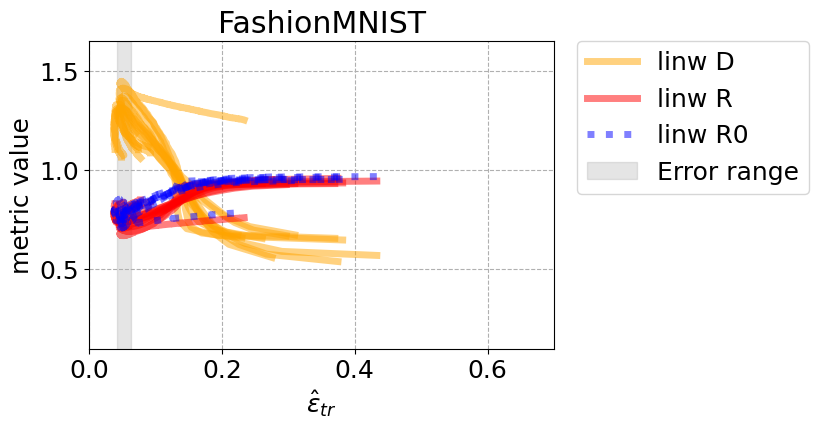

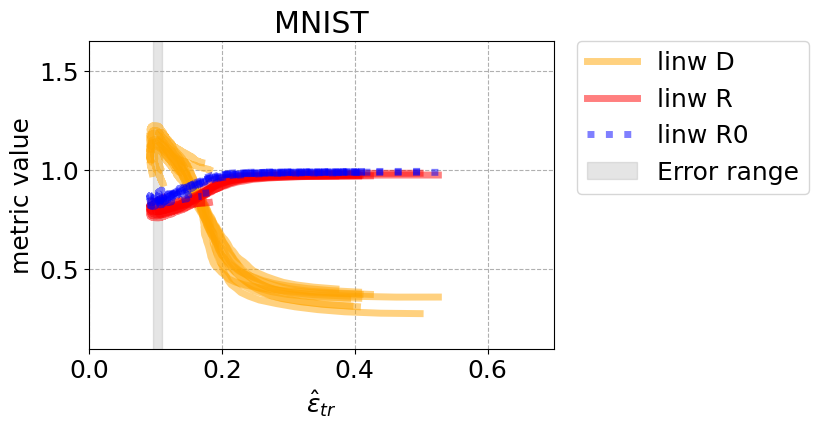

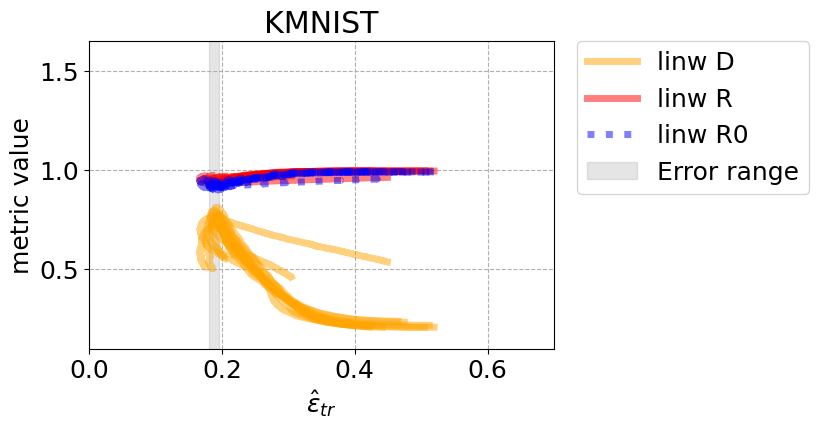

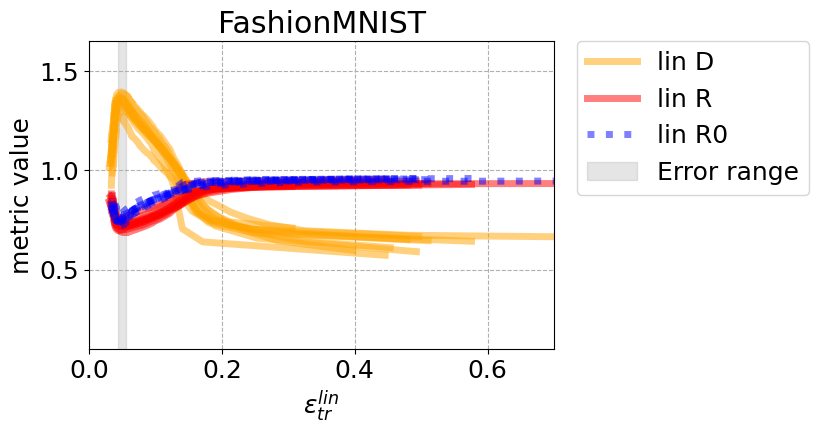

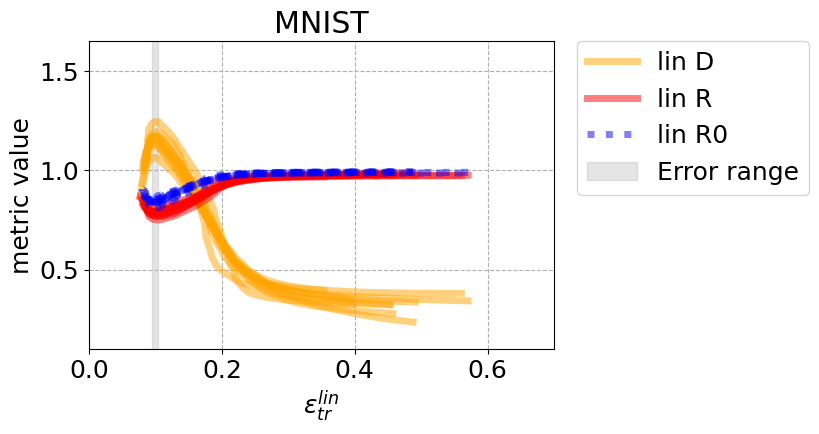

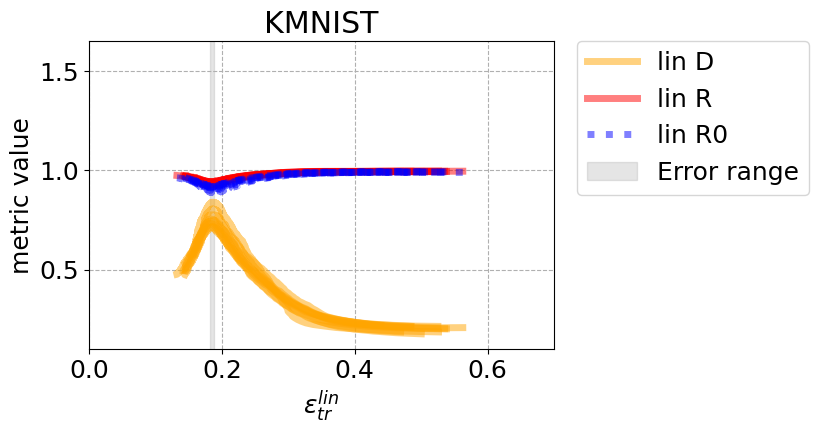

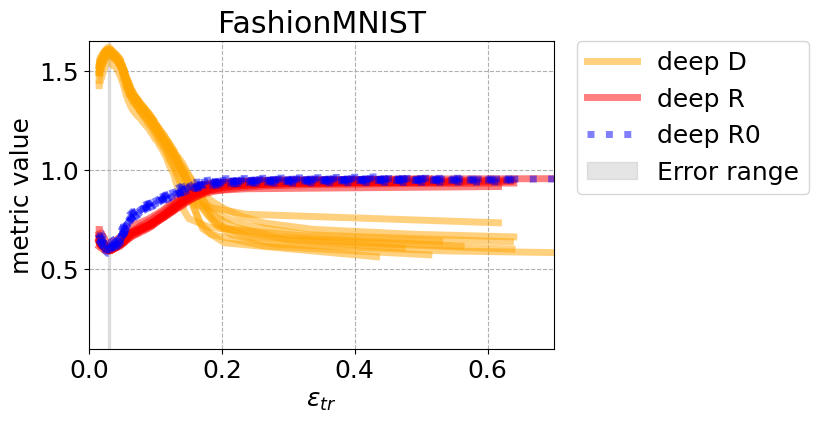

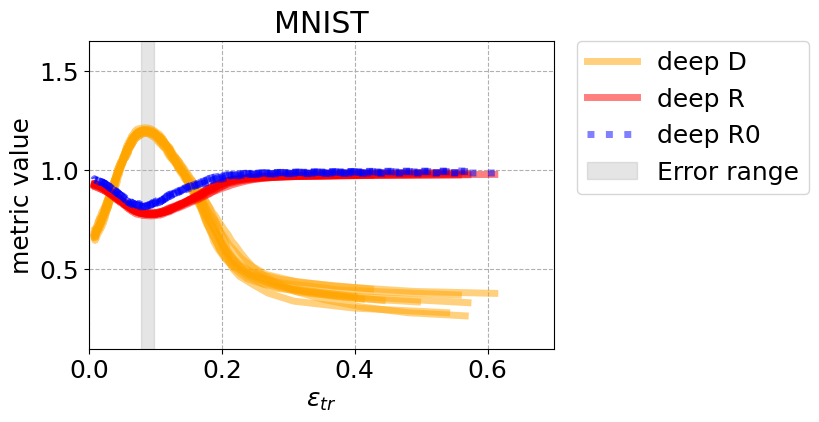

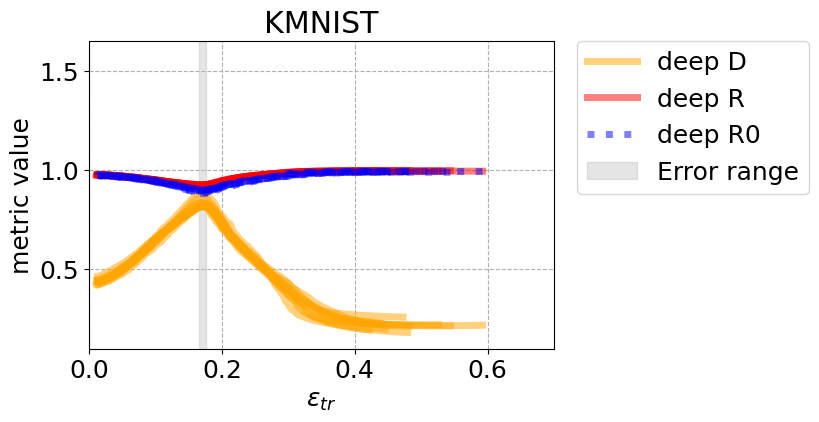

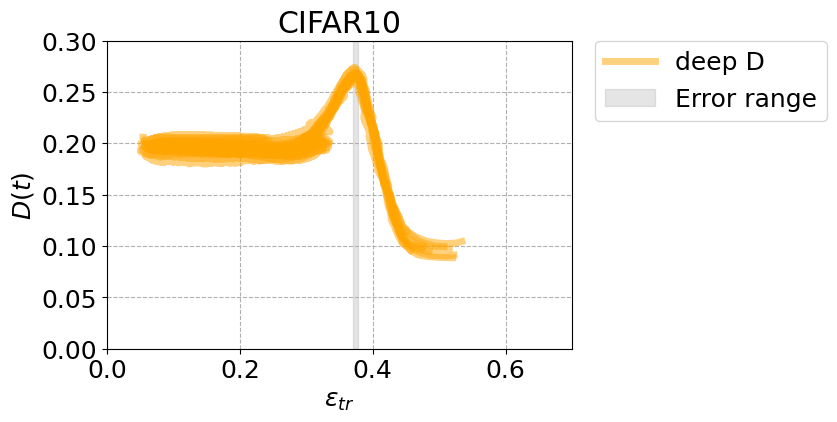

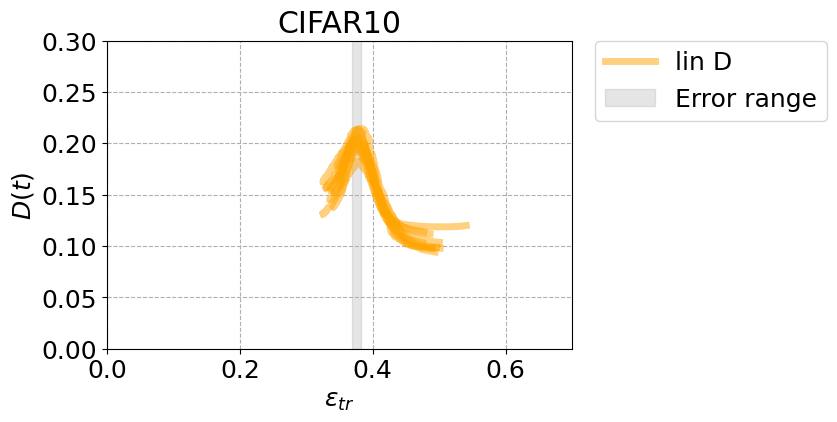

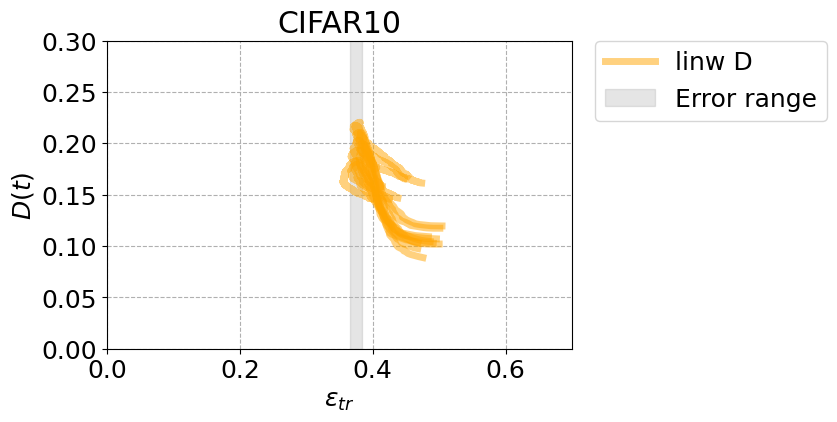

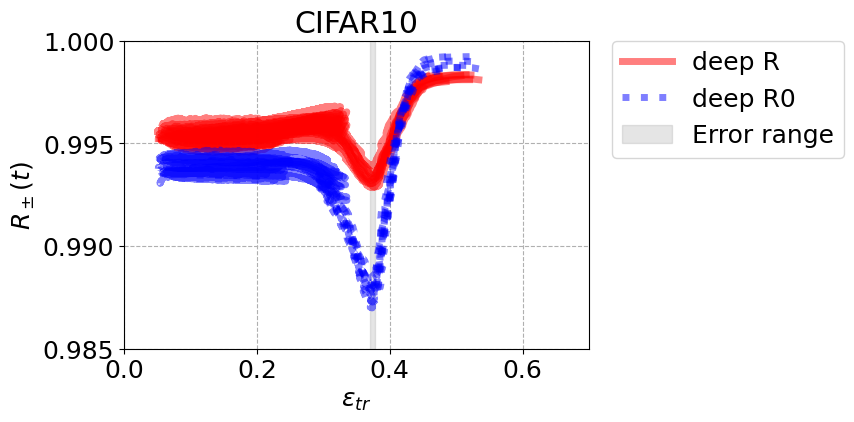

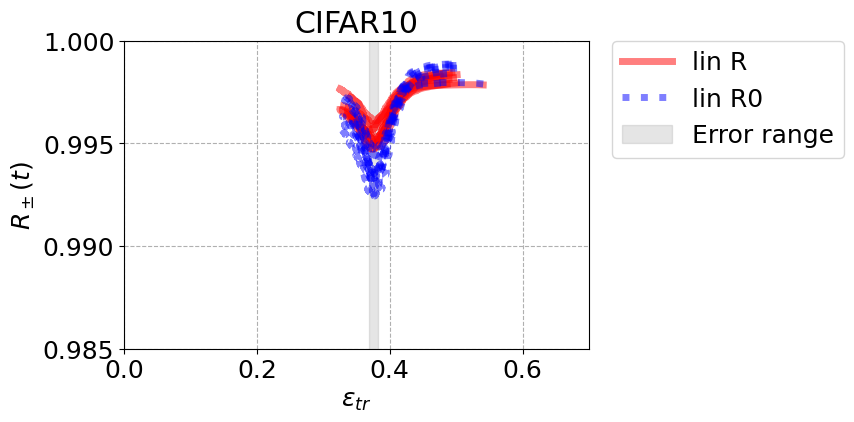

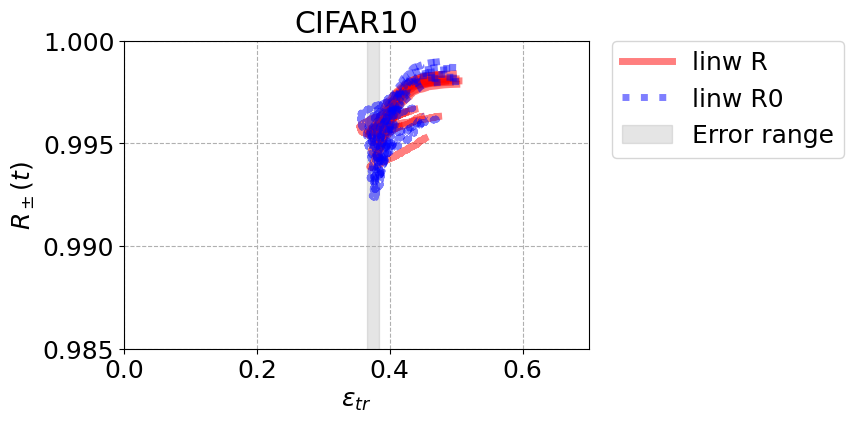

In [ ]:
# Define the file paths for the linear and non-linear data
file_paths = {
    'CIFAR10': ['/content/CIFAR10_inf_tot_lin.txt', '/content/CIFAR10_inf_tot_linw.txt', '/content/CIFAR10_inf_tot_non_lin.txt'],
    'KMNIST': ['/content/KMNIST_inf_tot_lin.txt', '/content/KMNIST_inf_tot_linw.txt', '/content/KMNIST_inf_tot_non_lin.txt'],
    'FashionMNIST': ['/content/FashionMNIST_inf_tot_lin.txt', '/content/FashionMNIST_inf_tot_linw.txt', '/content/FashionMNIST_inf_tot_non_lin.txt'],
    'MNIST': ['/content/MNIST_inf_tot_lin.txt', '/content/MNIST_inf_tot_linw.txt', '/content/MNIST_inf_tot_non_lin.txt']
}

# Add file paths for max_distance_info files
max_distance_info_paths = {
    'CIFAR10': ['/content/max_distance_info_lin_CIFAR10.txt', '/content/max_distance_info_linw_CIFAR10.txt', '/content/max_distance_info_non_lin_CIFAR10.txt'],
    'KMNIST': ['/content/max_distance_info_lin_KMNIST.txt', '/content/max_distance_info_linw_KMNIST.txt', '/content/max_distance_info_non_lin_KMNIST.txt'],
    'FashionMNIST': ['/content/max_distance_info_lin_FashionMNIST.txt', '/content/max_distance_info_linw_FashionMNIST.txt', '/content/max_distance_info_non_lin_FashionMNIST.txt'],
    'MNIST': ['/content/max_distance_info_lin_MNIST.txt', '/content/max_distance_info_linw_MNIST.txt', '/content/max_distance_info_non_lin_MNIST.txt']
}


colors = ['blue', 'red', 'orange']
dataset_labels = list(file_paths.keys())


all_points_lin = {}
all_points_linw = {}
all_points_non_lin = {}
all_max_distance_info_lin = {}
all_max_distance_info_linw = {}
all_max_distance_info_non_lin = {}

for dataset_name, paths in file_paths.items():

        # # run (col 0), train_error (col 2), distance (col 3), radius (col 4), radius0 (col 5)
        data_lin_dataset = np.loadtxt(paths[0], skiprows=1, usecols=(0, 2, 3, 4, 5))
        all_points_lin[dataset_name] = data_lin_dataset

        data_linw_dataset = np.loadtxt(paths[1], skiprows=1, usecols=(0, 2, 3, 4, 5))
        all_points_linw[dataset_name] = data_linw_dataset


        data_non_lin_dataset = np.loadtxt(paths[2], skiprows=1, usecols=(0, 2, 3, 4, 5))
        all_points_non_lin[dataset_name] = data_non_lin_dataset

# Load max_distance_info files
for dataset_name, paths in max_distance_info_paths.items():
        # train_err_max_d (col 2), train_err_min_r (col 6), train_err_min_r0 (col 7)
        data_max_dist_lin = np.loadtxt(paths[0], skiprows=1, delimiter='\t', usecols=(2, 6, 7))
        all_max_distance_info_lin[dataset_name] = data_max_dist_lin

        data_max_dist_linw = np.loadtxt(paths[1], skiprows=1, delimiter='\t', usecols=(2, 6, 7))
        all_max_distance_info_linw[dataset_name] = data_max_dist_linw


        data_max_dist_non_lin = np.loadtxt(paths[2], skiprows=1, delimiter='\t', usecols=(2, 6, 7))
        all_max_distance_info_non_lin[dataset_name] = data_max_dist_non_lin

#======================================================================
# Plotting for FashionMNIST, MNIST, KMNIST
#======================================================================

# linw vs lin
for dataset_name in ['FashionMNIST', 'MNIST', 'KMNIST']:
    plt.figure(figsize=(6, 4))
    if dataset_name in all_points_linw:
        plot_data(all_points_linw[dataset_name], 'linw D', 'orange', '-', 0.5, 'distance')
        plot_data(all_points_linw[dataset_name], 'linw R', 'red', '-', 0.5, 'radius')
        plot_data(all_points_linw[dataset_name], 'linw R0', 'blue', 'dotted', 0.5, 'radius0')

    if dataset_name in all_max_distance_info_linw:
        add_inversion_band(all_max_distance_info_linw[dataset_name], color='gray')

    plt.xlabel(r'$\hat{\epsilon}_{tr}$')
    plt.ylabel('metric value')
    plt.title(f'{dataset_name}')
    plt.ylim([0.1, 1.65])
    plt.xlim((0, 0.7))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{dataset_name}_linw_fin.pdf", bbox_inches='tight')
    plt.show()

for dataset_name in ['FashionMNIST', 'MNIST', 'KMNIST']:
    plt.figure(figsize=(6, 4))
    if dataset_name in all_points_lin:
        plot_data(all_points_lin[dataset_name], 'lin D', 'orange', '-', .5, 'distance')
        plot_data(all_points_lin[dataset_name], 'lin R', 'red', '-', 0.5, 'radius')
        plot_data(all_points_lin[dataset_name], 'lin R0', 'blue', 'dotted', 0.5, 'radius0')

    if dataset_name in all_max_distance_info_lin:
        add_inversion_band(all_max_distance_info_lin[dataset_name], color='gray')


    plt.xlabel(r'$\epsilon_{tr}^{lin}$')
    plt.ylabel('metric value')
    plt.title(f'{dataset_name}')
    plt.ylim([0.1, 1.65])
    plt.xlim((0, 0.7))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{dataset_name}_lin_fin.pdf", bbox_inches='tight')
    plt.show()

# non lin vs lin
for dataset_name in ['FashionMNIST', 'MNIST', 'KMNIST']:
    plt.figure(figsize=(6, 4))
    if dataset_name in all_points_non_lin:
        plot_data(all_points_non_lin[dataset_name], 'deep D', 'orange', '-', 0.5, 'distance')
        plot_data(all_points_non_lin[dataset_name], 'deep R', 'red', '-', 0.5, 'radius') # Radius data
        plot_data(all_points_non_lin[dataset_name], 'deep R0', 'blue', 'dotted', 0.5, 'radius0') # Radius data

    if dataset_name in all_max_distance_info_non_lin:
        add_inversion_band(all_max_distance_info_non_lin[dataset_name], color='gray')

    plt.xlabel(r'$\epsilon_{tr}$')
    plt.ylabel('metric value')
    plt.title(f'{dataset_name}')
    plt.ylim([0.1, 1.65])
    plt.xlim((0, 0.7))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{dataset_name}_non_lin_fin.pdf", bbox_inches='tight')
    plt.show()

#======================================================================
# Plotting for CIFAR10
#======================================================================
#distance

dataset_name = 'CIFAR10'
plt.figure(figsize=(6, 4))
if dataset_name in all_points_non_lin:
    plot_data(all_points_non_lin[dataset_name], 'deep D', 'orange', '-', 0.5, 'distance')

if dataset_name in all_max_distance_info_non_lin:
    add_inversion_band(all_max_distance_info_non_lin[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$D(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0, 0.3))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_D_non_lin_fin.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(6, 4))
if dataset_name in all_points_lin:
    plot_data(all_points_lin[dataset_name], 'lin D', 'orange', '-', 0.5, 'distance')

if dataset_name in all_max_distance_info_lin:
    add_inversion_band(all_max_distance_info_lin[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$D(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0, 0.3))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_D_lin_fin.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(6, 4))
if dataset_name in all_points_linw:
    plot_data(all_points_linw[dataset_name], 'linw D', 'orange', '-',0.5, 'distance')

if dataset_name in all_max_distance_info_linw:
    add_inversion_band(all_max_distance_info_linw[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$D(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0, 0.3))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_D_linw_fin.pdf", bbox_inches='tight')
plt.show()

#  radius

dataset_name = 'CIFAR10'
plt.figure(figsize=(6, 4))
if dataset_name in all_points_non_lin:
    plot_data(all_points_non_lin[dataset_name], 'deep R', 'red', '-', 0.5, 'radius')
    plot_data(all_points_non_lin[dataset_name], 'deep R0', 'blue', 'dotted', 0.5, 'radius0')

if dataset_name in all_max_distance_info_non_lin:
    add_inversion_band(all_max_distance_info_non_lin[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$R_\pm(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0.985, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_R_non_lin_fin.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(6, 4))
if dataset_name in all_points_lin:
    plot_data(all_points_lin[dataset_name], 'lin R', 'red', '-', 0.5, 'radius')
    plot_data(all_points_lin[dataset_name], 'lin R0', 'blue', 'dotted', 0.5, 'radius0')

if dataset_name in all_max_distance_info_lin:
    add_inversion_band(all_max_distance_info_lin[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$R_\pm(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0.985, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_R_lin_fin.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(6, 4))
if dataset_name in all_points_linw:
    plot_data(all_points_linw[dataset_name], 'linw R', 'red', '-', 0.5, 'radius')
    plot_data(all_points_linw[dataset_name], 'linw R0', 'blue', 'dotted', 0.5, 'radius0')

if dataset_name in all_max_distance_info_linw:
    add_inversion_band(all_max_distance_info_linw[dataset_name], color='gray')

plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel(r'$R_\pm(t)$')
plt.title(f'{dataset_name}')
plt.xlim((0, 0.7))
plt.ylim((0.985, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_R_linw_fin.pdf", bbox_inches='tight')
plt.show()


the plots show lintogether with linw,
and non lin together with lin.

Found 10 unique runs in linear error data.
Found 10 unique runs in linear error data.
Found 10 unique runs in linear error data.


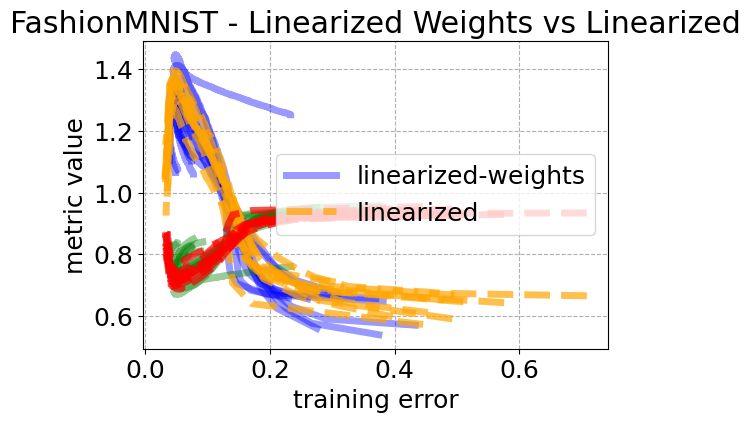

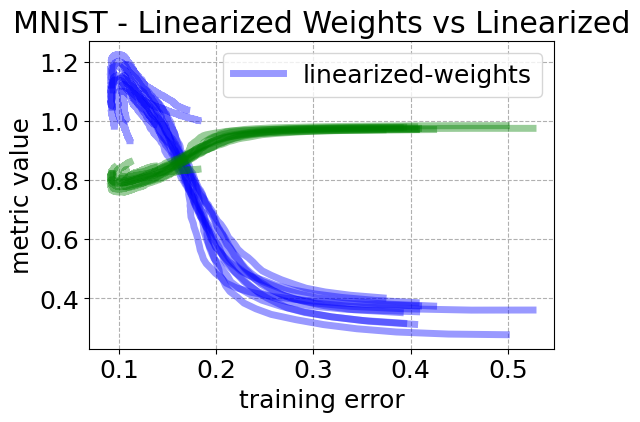

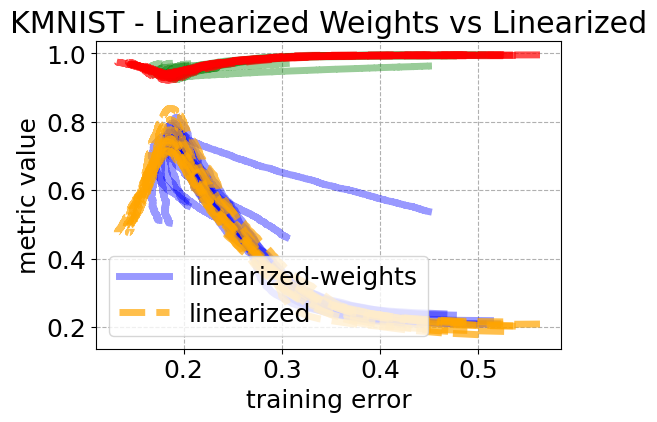

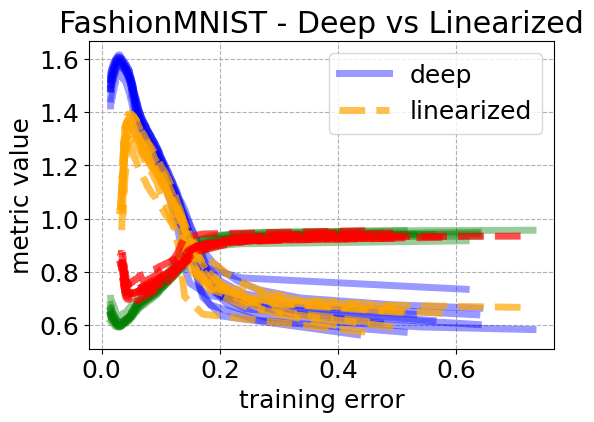

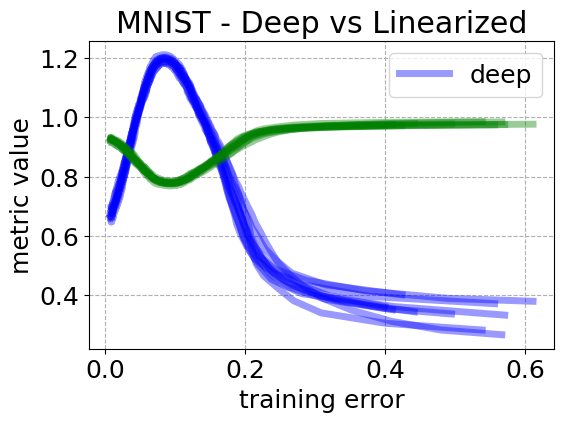

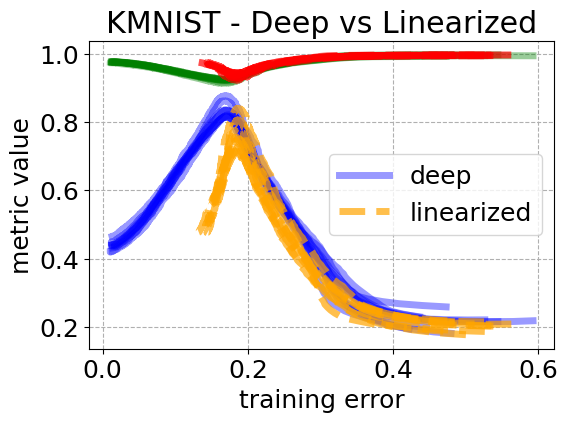

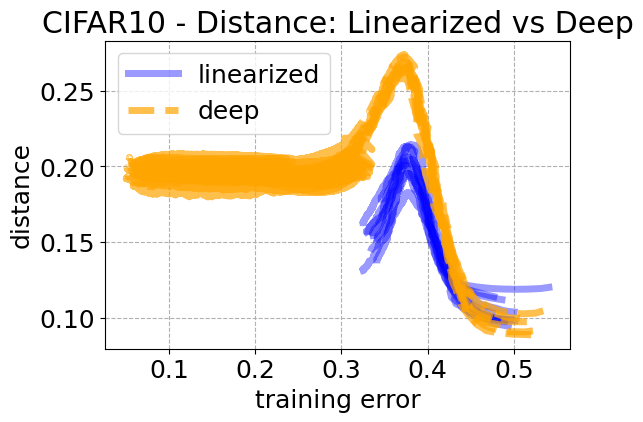

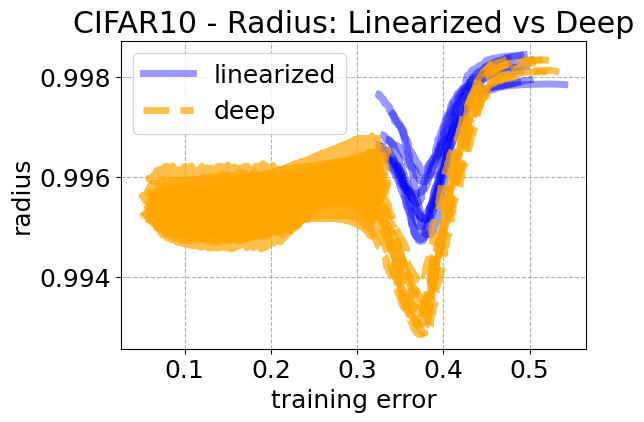

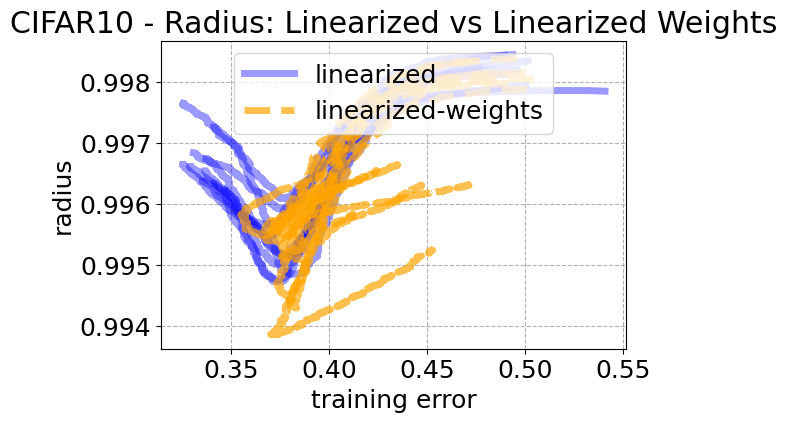

In [ ]:
# Define the file paths for the linear and non-linear data
file_paths = {
    'CIFAR10': ['/content/CIFAR10_inf_tot_lin.txt', '/content/CIFAR10_inf_tot_linw.txt', '/content/CIFAR10_inf_tot_non_lin.txt'],
    'KMNIST': ['/content/KMNIST_inf_tot_lin.txt', '/content/KMNIST_inf_tot_linw.txt', '/content/KMNIST_inf_tot_non_lin.txt'],
    'FashionMNIST': ['/content/FashionMNIST_inf_tot_lin.txt', '/content/FashionMNIST_inf_tot_linw.txt', '/content/FashionMNIST_inf_tot_non_lin.txt'],
    'MNIST': ['/content/MNIST_inf_tot.txt', '/content/MNIST_inf_tot_linw.txt', '/content/MNIST_inf_tot_non_lin.txt']
}


colors = ['blue', 'red', 'green', 'orange']
dataset_labels = list(file_paths.keys())

all_points_lin = {}
all_points_linw = {}
all_points_non_lin = {}
all_points_linw_err= {}
all_points_lin_err = {}
for dataset_name, paths in file_paths.items():
    try:
        # Assuming columns are: Run, Epoch, Train_Error, Distance, Radius
        # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col 4)
        data_lin_dataset = np.loadtxt(paths[0], skiprows=1, usecols=(0, 2, 3, 4))

        all_points_lin[dataset_name] = data_lin_dataset

        # Get unique run numbers
        runs_lin = np.unique(data_lin_dataset[:, 0])

        # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col 4)
        data_lin_dataset_err = np.loadtxt(paths[0], skiprows=1, usecols=(0, 2, 3, 4))
        all_points_lin_err[dataset_name] = data_lin_dataset_err

        # Get unique run numbers
        runs_lin_err = np.unique(data_lin_dataset_err[:, 0])
        print(f"Found {len(runs_lin_err)} unique runs in linear error data.")


    except FileNotFoundError:
        print(f"Warning: File not found for linear data: {paths[0]}")
    except IndexError:
        print(f"Error: Ensure columns in {paths[0]} are correct.")
    except Exception as e:
        print(f"An error occurred processing linear data: {e}")

    try:

        # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col 4)
        data_linw_dataset = np.loadtxt(paths[1], skiprows=1, usecols=(0, 2, 3, 4))
        all_points_linw[dataset_name] = data_linw_dataset

        # Get unique run numbers
        runs_linw = np.unique(data_linw_dataset[:, 0])

        # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col (4)
        data_linw_dataset_err = np.loadtxt(paths[1], skiprows=1, usecols=(0, 2, 3, 4))
        all_points_linw_err[dataset_name] = data_linw_dataset_err

        # Get unique run numbers
        runs_linw_err = np.unique(data_linw_dataset_err[:, 0])

    except FileNotFoundError:
        print(f"Warning: File not found for linear weights data: {paths[1]}")
    except IndexError:
        print(f"Error: Ensure columns in {paths[1]} are correct.")
    except Exception as e:
        print(f"An error occurred processing linear weights data: {e}")

    try:
        # Run (col 0), Train_Error (col 2), Distance (col 3), Radius (col 4)
        data_non_lin_dataset = np.loadtxt(paths[2], skiprows=1, usecols=(0, 2, 3, 4))
        all_points_non_lin[dataset_name] = data_non_lin_dataset


        # Get unique run numbers
        runs_non_lin = np.unique(data_non_lin_dataset[:, 0])


    except FileNotFoundError:
        print(f"Warning: File not found for non-linear data: {paths[2]}")
    except IndexError:
        print(f"Error: Ensure columns in {paths[2]} are correct.")
    except Exception as e:
        print(f"An error occurred processing non-linear data: {e}")


#==================================================================================
#plotting CIFAR10
#===================================================================================

# linw vs lin
for dataset_name in ['FashionMNIST', 'MNIST', 'KMNIST']:
    plt.figure(figsize=(6, 4))
    if dataset_name in all_points_linw:
        plot_data(all_points_linw[dataset_name], 'linearized-weights', 'blue', '-', 0.4, 'distance')
        plot_data(all_points_linw[dataset_name], '_nolegend_', 'green', '-', 0.4, 'radius') # Radius data
    if dataset_name in all_points_lin:
        plot_data(all_points_lin[dataset_name], 'linearized', 'orange', '--', 0.7, 'distance')
        plot_data(all_points_lin[dataset_name], '_nolegend_', 'red', '--', 0.7, 'radius') # Radius data

    plt.xlabel('training error')
    plt.ylabel('metric value')
    plt.title(f'{dataset_name} - Linearized Weights vs Linearized')
    plt.legend()
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{dataset_name}_linw_vs_lin.pdf", bbox_inches='tight')
    plt.show()

#non lin vs lin
for dataset_name in ['FashionMNIST', 'MNIST', 'KMNIST']:
    plt.figure(figsize=(6, 4))
    if dataset_name in all_points_non_lin:
        plot_data(all_points_non_lin[dataset_name], 'deep', 'blue', '-', 0.4, 'distance')
        plot_data(all_points_non_lin[dataset_name], '_nolegend_', 'green', '-', 0.4, 'radius') # Radius data
    if dataset_name in all_points_lin:
        plot_data(all_points_lin[dataset_name], 'linearized', 'orange', '--', 0.7, 'distance')
        plot_data(all_points_lin[dataset_name], '_nolegend_', 'red', '--', 0.7, 'radius') # Radius data

    plt.xlabel('training error')
    plt.ylabel('metric value')
    plt.title(f'{dataset_name} - Deep vs Linearized')
    plt.legend()
    plt.grid(True, which="both", linestyle='--')
    plt.savefig(f"{dataset_name}_non_lin_vs_lin.pdf", bbox_inches='tight')
    plt.show()

#==================================================================================
#plotting CIFAR10
#===================================================================================
# distance lin vs non lin
dataset_name = 'CIFAR10'
plt.figure(figsize=(6, 4))
if dataset_name in all_points_lin:
    plot_data(all_points_lin[dataset_name], 'linearized', 'blue', '-', 0.4, 'distance')
if dataset_name in all_points_non_lin:
    plot_data(all_points_non_lin[dataset_name], 'deep', 'orange', '--', 0.7, 'distance')

plt.xlabel('training error')
plt.ylabel('distance')
plt.title(f'{dataset_name} - Distance: Linearized vs Deep')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_lin_vs_non_lin_distance.pdf", bbox_inches='tight')
plt.show()

# radius lin vs non lin
plt.figure(figsize=(6, 4))
if dataset_name in all_points_lin:
    plot_data(all_points_lin[dataset_name], 'linearized', 'blue', '-', 0.4, 'radius')
if dataset_name in all_points_non_lin:
    plot_data(all_points_non_lin[dataset_name], 'deep', 'orange', '--', 0.7, 'radius')

plt.xlabel('training error')
plt.ylabel('radius')
plt.title(f'{dataset_name} - Radius: Linearized vs Deep')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_lin_vs_non_lin_radius.pdf", bbox_inches='tight')
plt.show()

# adius lin vs linw
plt.figure(figsize=(6, 4))
if dataset_name in all_points_lin:
    plot_data(all_points_lin[dataset_name], 'linearized', 'blue', '-', 0.4, 'radius')
if dataset_name in all_points_linw:
    plot_data(all_points_linw[dataset_name], 'linearized-weights', 'orange', '--', 0.7, 'radius')

plt.xlabel('training error')
plt.ylabel('radius')
plt.title(f'{dataset_name} - Radius: Linearized vs Linearized Weights')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{dataset_name}_lin_vs_linw_radius.pdf", bbox_inches='tight')
plt.show()

#Average Plots of $D(t)$ and $R_\pm(t)$ as a Function of the Training Error

In this section, we plot $D(t)$ together with $R_\pm(t)$ as a function of the training error.
The plot is generated for the standard feedforward network (called ``non lin''),
for the standard feedforward network with linearized weights (called ``linw''),
and for the linearized model (called ``lin'').

The plot shows the average of the observables over 10 runs (dashed line) and the standard deviation,
represented as a shaded area centered around the mean value (the shaded area spans 2 standard deviations).
The average is computed with respect to the training error,
after dividing the range of possible training error values into $n$ bins.


The gray band is bounded by the minimum and maximum training error at inversion,
computed over all runs and referring only to the data shown in the plot.

In the first part, the plots show ``lin'' together with ``linw'',
and ``non lin'' together with ``lin''.

In [ ]:
#This function is designed to plot the mean and standard deviation of distance and radius
#as a function of training error
def plot_mean_std(data, label, color, linestyle, metric):
    train_err = data[:, 2]
    dist = data[:, 3]
    rad = data[:, 4]
    y = dist if metric == 'distance' else rad
    sort_idx = np.argsort(train_err)
    train_err = train_err[sort_idx]
    y = y[sort_idx]
    # calculate mean and std by dividing the interval into 35 bins
    bins = np.linspace(train_err.min(), train_err.max(), 35)
    centers = 0.5 * (bins[1:] + bins[:-1])
    #initialize arrays
    #np.zeros_like() is a NumPy function that creates a new array filled with zeros
    mean_y = np.zeros_like(centers)
    std_y = np.zeros_like(centers)
    for i in range(len(bins) - 1):
        mask = (train_err >= bins[i]) & (train_err < bins[i+1])
        # if there is training error data in the bin, then calculate the mean and std of the observables
        if np.any(mask):
            mean_y[i] = np.mean(y[mask])
            std_y[i] = np.std(y[mask])
        else:
            mean_y[i] = np.nan
            std_y[i] = np.nan
    # keeps only the mean and std calculated in the intervals where there is data
    valid = ~np.isnan(mean_y)
    centers = centers[valid]
    mean_y = mean_y[valid]
    std_y = std_y[valid]
    # plot of the mean
    plt.plot(centers, mean_y, color=color, linestyle=linestyle, label=label, linewidth=3)
    # std dev band
    plt.fill_between(centers, mean_y - 2*std_y, mean_y + 2*std_y, color=color, alpha=0.2)

#helper function for faster plotting
def setup_plot(title, xlabel, ylabel, xlim, ylim):
    plt.figure(figsize=(6, 4))
    #plt.subplots_adjust(left=0.12, right=0.78, top=0.9, bottom=0.15)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--')
    plt.xlim(xlim)
    plt.ylim(ylim)

def finalize_plot(filename):
  # plt.gca() gets the current axes
    handles, labels = plt.gca().get_legend_handles_labels()
    # if there are labels, create the legend
    if labels:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # save the image in pdf format
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()

#def load_if_exists(path):
#    if os.path.exists(path):
#        try:
#            return np.loadtxt(path, delimiter='\t', skiprows=1)
#        except:
#            return None
#    return None

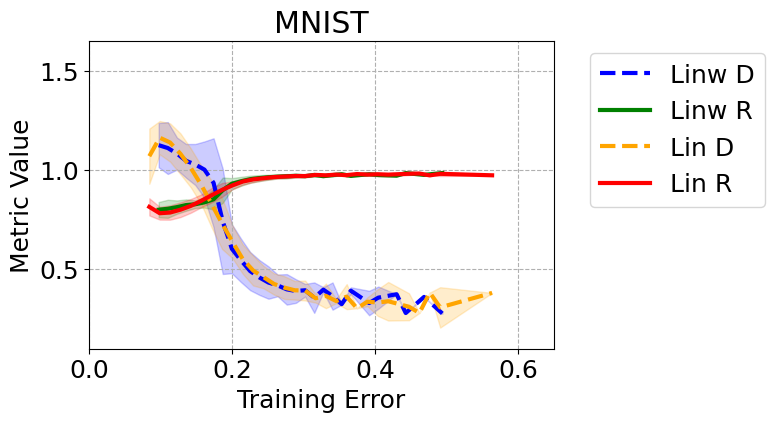

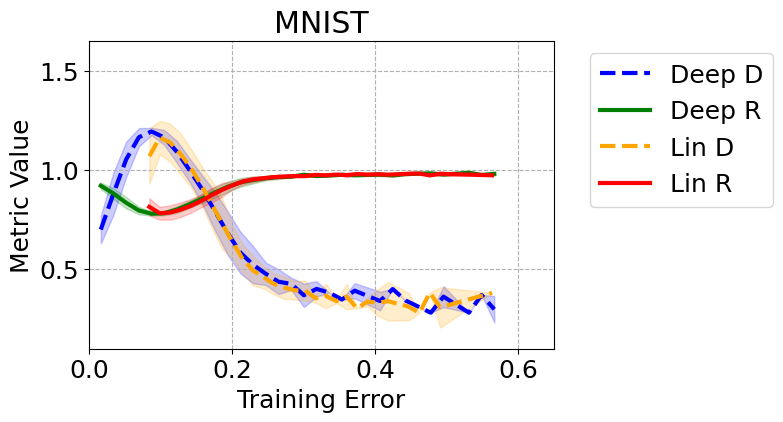

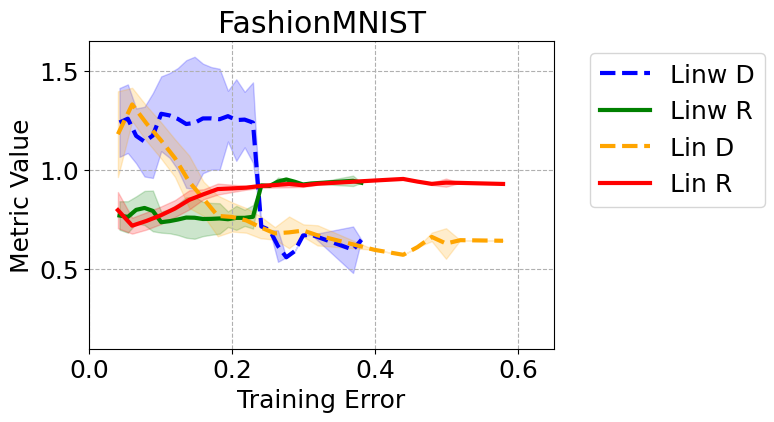

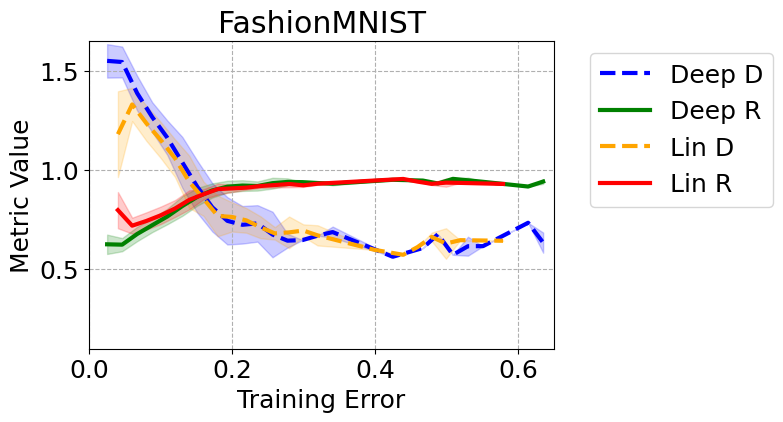

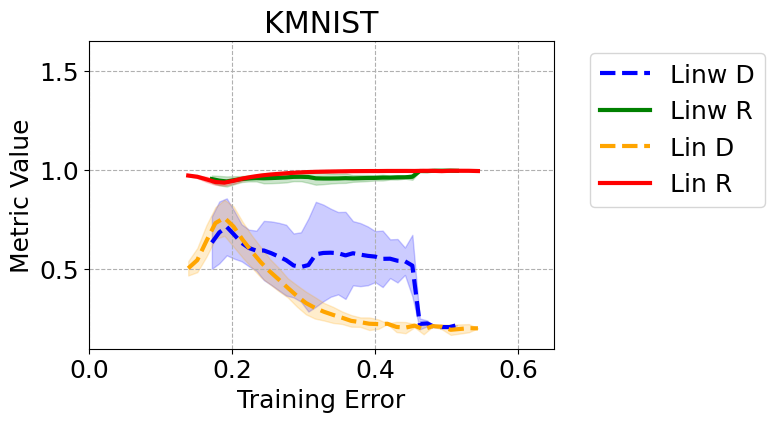

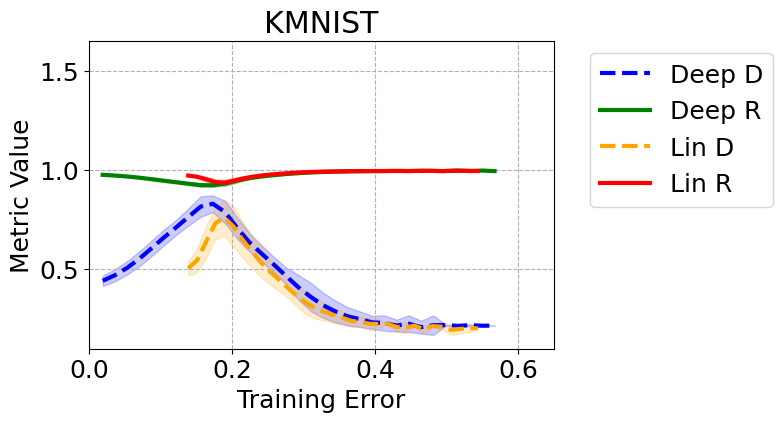

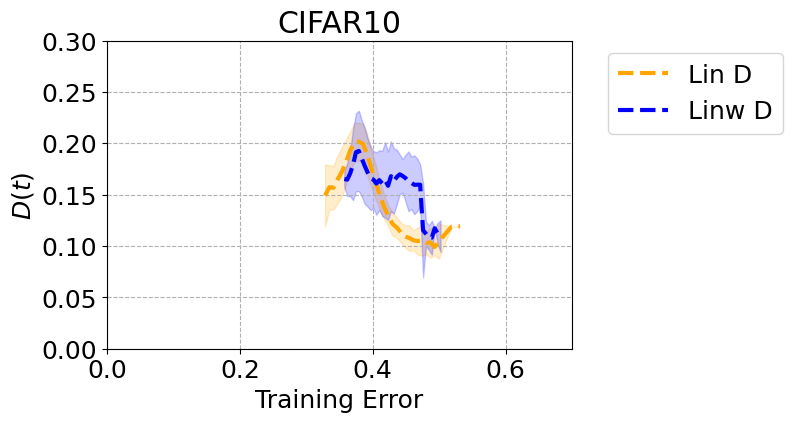

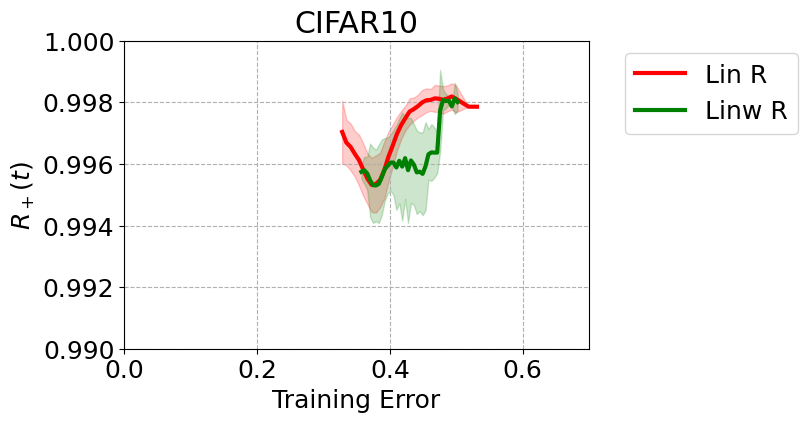

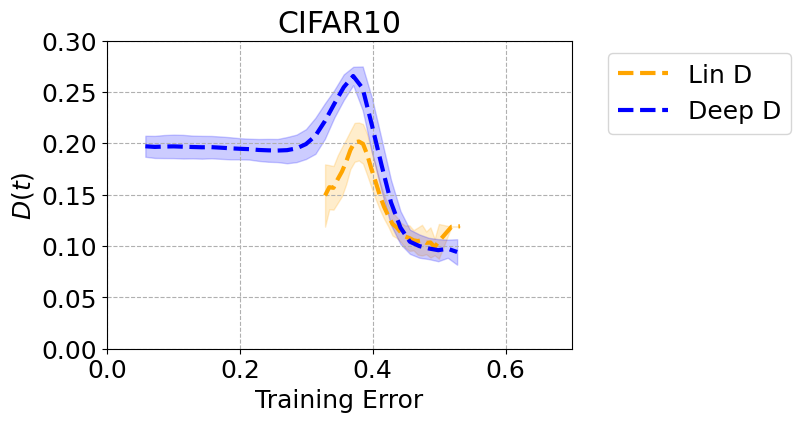

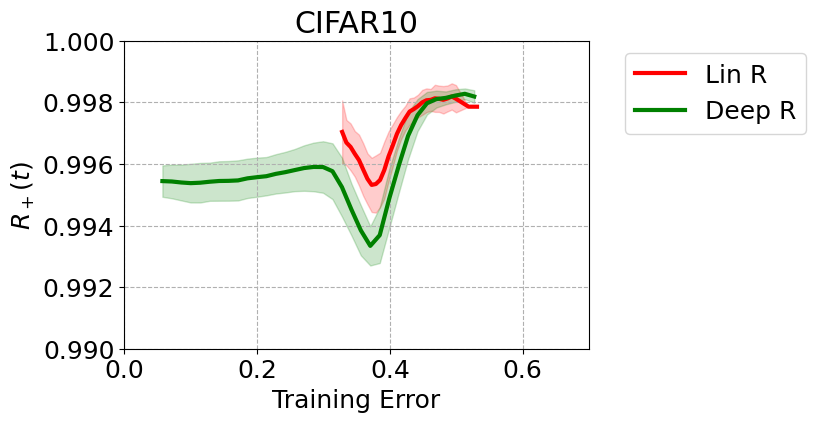

In [ ]:
file_paths = {
    'CIFAR10': ['/content/CIFAR10_inf_tot_lin.txt', '/content/CIFAR10_inf_tot_linw.txt', '/content/CIFAR10_inf_tot_non_lin.txt'],
    'KMNIST': ['/content/KMNIST_inf_tot_lin.txt', '/content/KMNIST_inf_tot_linw.txt', '/content/KMNIST_inf_tot_non_lin.txt'],
    'FashionMNIST': ['/content/FashionMNIST_inf_tot_lin.txt', '/content/FashionMNIST_inf_tot_linw.txt', '/content/FashionMNIST_inf_tot_non_lin.txt'],
    'MNIST': ['/content/MNIST_inf_tot_lin.txt', '/content/MNIST_inf_tot_linw.txt', '/content/MNIST_inf_tot_non_lin.txt']
}

all_points_lin = {}
all_points_linw = {}
all_points_non_lin = {}

for dataset, paths in file_paths.items():
  #np.loadtxt(paths[0], skiprows=1)
    all_points_lin[dataset] = np.loadtxt(paths[0], skiprows=1)

    all_points_linw[dataset] = np.loadtxt(paths[1], skiprows=1)
    all_points_non_lin[dataset] = np.loadtxt(paths[2], skiprows=1)

xlim_default = (0, 0.65)
ylim_default = (0.1, 1.65)
xlim_cifar = (0, 0.7)
ylim_dist_cifar = (0, 0.3)
ylim_rad_cifar = (0.99, 1)

#=====================================================================
#MNIST, FashionMNIST, KMNIST
#=====================================================================
for dataset in ['MNIST', 'FashionMNIST', 'KMNIST']:
    setup_plot(dataset, 'Training Error', 'Metric Value', xlim_default, ylim_default)
    if all_points_linw[dataset] is not None:
        plot_mean_std(all_points_linw[dataset], 'Linw D', 'blue', '--', 'distance')
        plot_mean_std(all_points_linw[dataset], 'Linw R', 'green', '-', 'radius')
    if all_points_lin[dataset] is not None:
        plot_mean_std(all_points_lin[dataset], 'Lin D', 'orange', '--', 'distance')
        plot_mean_std(all_points_lin[dataset], 'Lin R', 'red', '-', 'radius')
    finalize_plot(f"{dataset}_lin_vs_linw.pdf")

    setup_plot(dataset, 'Training Error', 'Metric Value', xlim_default, ylim_default)
    if all_points_non_lin[dataset] is not None:
        plot_mean_std(all_points_non_lin[dataset], 'Deep D', 'blue', '--', 'distance')
        plot_mean_std(all_points_non_lin[dataset], 'Deep R', 'green', '-', 'radius')
    if all_points_lin[dataset] is not None:
        plot_mean_std(all_points_lin[dataset], 'Lin D', 'orange', '--', 'distance')
        plot_mean_std(all_points_lin[dataset], 'Lin R', 'red', '-', 'radius')
    finalize_plot(f"{dataset}_lin_vs_deep.pdf")

#=====================================================================
#CIFAR10
#=====================================================================
setup_plot('CIFAR10', 'Training Error', r'$D(t)$', xlim_cifar, ylim_dist_cifar)
if all_points_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_lin['CIFAR10'], 'Lin D', 'orange', '--', 'distance')
if all_points_linw['CIFAR10'] is not None:
    plot_mean_std(all_points_linw['CIFAR10'], 'Linw D', 'blue', '--', 'distance')
finalize_plot("CIFAR10_lin_vs_linw_distance.pdf")

setup_plot('CIFAR10', 'Training Error', r'$R_+(t)$', xlim_cifar, ylim_rad_cifar)
if all_points_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_lin['CIFAR10'], 'Lin R', 'red', '-', 'radius')
if all_points_linw['CIFAR10'] is not None:
    plot_mean_std(all_points_linw['CIFAR10'], 'Linw R', 'green', '-', 'radius')
finalize_plot("CIFAR10_lin_vs_linw_radius.pdf")

setup_plot('CIFAR10', 'Training Error', r'$D(t)$', xlim_cifar, ylim_dist_cifar)
if all_points_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_lin['CIFAR10'], 'Lin D', 'orange', '--', 'distance')
if all_points_non_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_non_lin['CIFAR10'], 'Deep D', 'blue', '--', 'distance')
finalize_plot("CIFAR10_lin_vs_deep_distance.pdf")

setup_plot('CIFAR10', 'Training Error', r'$R_+(t)$', xlim_cifar, ylim_rad_cifar)
if all_points_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_lin['CIFAR10'], 'Lin R', 'red', '-', 'radius')
if all_points_non_lin['CIFAR10'] is not None:
    plot_mean_std(all_points_non_lin['CIFAR10'], 'Deep R', 'green', '-', 'radius')
finalize_plot("CIFAR10_lin_vs_deep_radius.pdf")

# Plot of $\epsilon_{tr}^{lin}(t)$ vs $\hat{\epsilon}_{tr}(t)$,

In this section, we plot training error of linearized model (called $\epsilon_{tr}^{lin}(t)$),together with training error of standard feedforward network with linearized weights ((called $\hat{\epsilon}_{tr}(t)$).


The plot shows the average of the training error as a function of epoch $t$ over 10 runs (dashed line) and the standard deviation,
represented as a shaded area centered around the mean value (the shaded area spans 2 standard deviations).
The average is computed with respect to the training error,
after dividing the range of possible training error values into $n$ bins.

In [ ]:
#function that calculates the mean and std of the training error obtained with the linearized network and the one obtained with linw.
#the mean is calculated on the training error, after dividing it into 40 bins
#the operation is the same as the plot_mean_std function but here we add the plot of the individual training error data at inversion
def plot_train_err_comparison(dataset, lin_data, linw_data, max_dist_info_lin, max_dist_info_linw, output_path):

    train_err_lin = lin_data[:, 2]
    train_err_linw = linw_data[:, 2]

    sort_idx = np.argsort(train_err_lin)
    train_err_lin = train_err_lin[sort_idx]
    train_err_linw = train_err_linw[sort_idx]
#calculate the mean of the training error over 40 bins
    bins = np.linspace(train_err_lin.min(), train_err_lin.max(), 40)
    centers = 0.5 * (bins[1:] + bins[:-1])
    mean_x = np.zeros_like(centers)
    mean_y = np.zeros_like(centers)
    std_y = np.zeros_like(centers)

    for i in range(len(bins) - 1):
        mask = (train_err_lin >= bins[i]) & (train_err_lin < bins[i+1])
        if np.any(mask):
            mean_x[i] = np.mean(train_err_lin[mask])
            mean_y[i] = np.mean(train_err_linw[mask])
            std_y[i] = np.std(train_err_linw[mask])
        else:
            mean_x[i] = np.nan
            mean_y[i] = np.nan
            std_y[i] = np.nan

    valid = ~np.isnan(mean_x)
    mean_x = mean_x[valid]
    mean_y = mean_y[valid]
    std_y = std_y[valid]

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$\epsilon_{tr}^{lin}$')
    plt.ylabel(r'$\hat{\epsilon}_{tr}$')
    plt.title(f"{dataset}")


    plt.plot(mean_x, mean_y, color="grey", label="Mean")
    plt.fill_between(mean_x, mean_y - 2*std_y, mean_y + 2*std_y, color="grey", alpha=0.2, label="±1 std")

#add the training errors at inversion
    if max_dist_info_lin.ndim == 2 and max_dist_info_linw.ndim == 2:
        train_err_max_dist_lin = max_dist_info_lin[:, 2]
        train_err_min_rad_lin = max_dist_info_lin[:, 6]
        train_err_min_rad0_lin = max_dist_info_lin[:, 7]
        train_err_max_dist_linw = max_dist_info_linw[:, 2]
        train_err_min_rad_linw = max_dist_info_linw[:, 6]
        train_err_min_rad0_linw = max_dist_info_linw[:, 7]
        plt.scatter(train_err_max_dist_lin, train_err_max_dist_linw,
            color="orange", marker='o', s=300, alpha=1,
            label=r"D(t)", edgecolors='orange', facecolors='none')

        plt.scatter(train_err_min_rad_lin, train_err_min_rad_linw,
            color="red", marker='x', s=300, alpha=1,
            label=r"R_+(t)")

        plt.scatter(train_err_min_rad0_lin, train_err_min_rad0_linw,
            color="blue", marker='^', s=300, alpha=1,
            label=r"R__(t)", edgecolors='blue', facecolors='none')


    lims = [0, 0.7]
    plt.plot(lims, lims, 'k--', label="y = x")

    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--')

    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

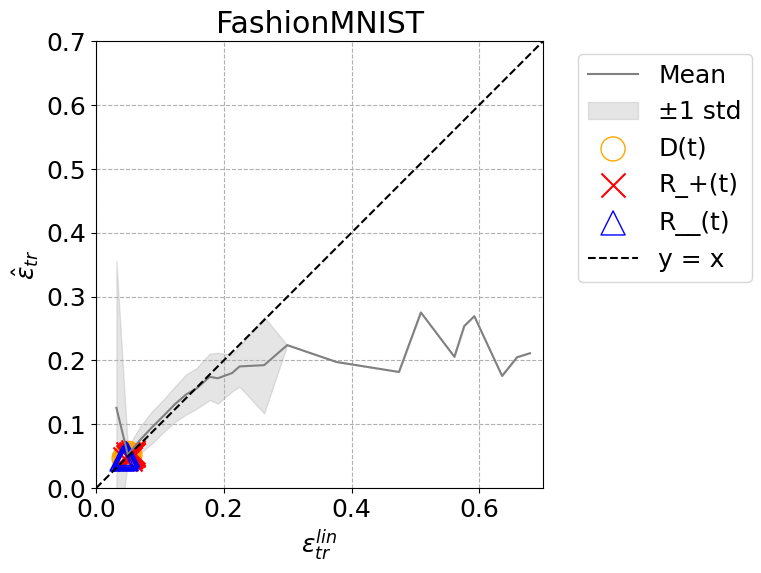

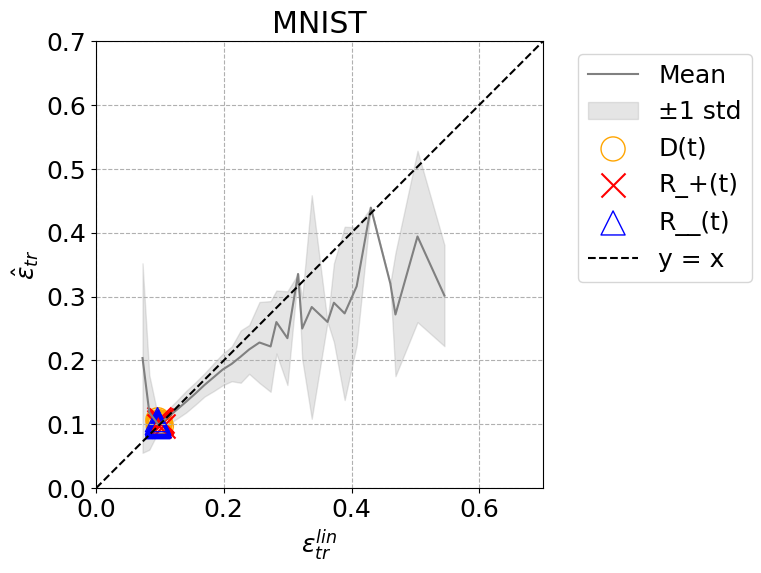

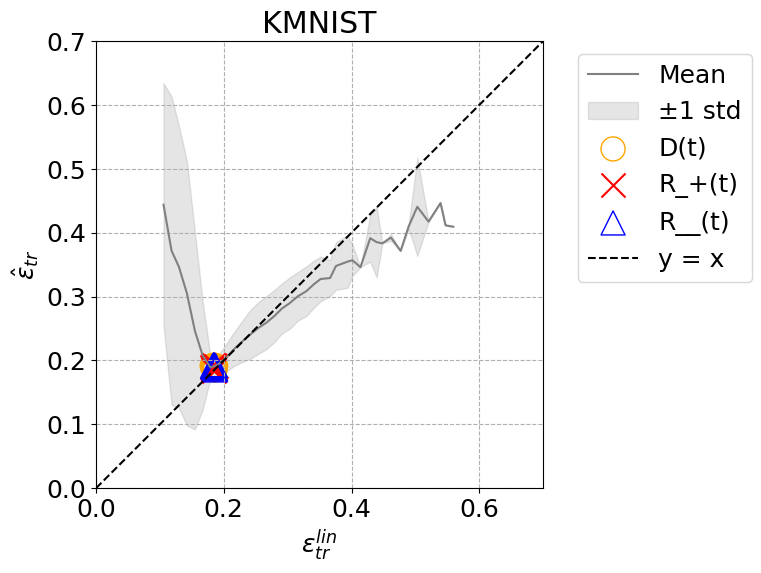

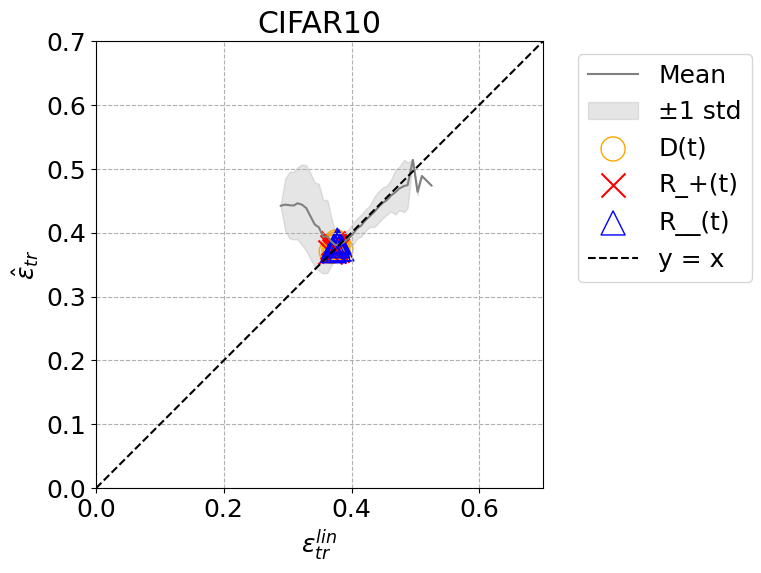

In [ ]:
file_paths = {
    'CIFAR10': [r'/content/CIFAR10_inf_tot_lin_lr_0.1.txt', r'/content/CIFAR10_inf_tot_linw_lr_0.1.txt', r'/content/max_distance_info_lin_CIFAR10_lr_0.1.txt', r'/content/max_distance_info_linw_CIFAR10_lr_0.1.txt'],
    'KMNIST': [r'/content/KMNIST_inf_tot_lin_lr_0.1.txt', r'/content/KMNIST_inf_tot_linw_lr_0.1.txt', r'/content/max_distance_info_lin_KMNIST_lr_0.1.txt', r'/content/max_distance_info_linw_KMNIST_lr_0.1.txt'],
    'FashionMNIST': [r'/content/FashionMNIST_inf_tot_lin_lr_0.1.txt', r'/content/FashionMNIST_inf_tot_linw_lr_0.1.txt', r'/content/max_distance_info_lin_FashionMNIST_lr_0.1.txt', r'/content/max_distance_info_linw_FashionMNIST_lr_0.1.txt'],
    'MNIST': [r'/content/MNIST_inf_tot_lin_lr_0.1.txt', r'/content/MNIST_inf_tot_linw_lr_0.1.txt', r'/content/max_distance_info_lin_MNIST_lr_0.1.txt', r'/content/max_distance_info_linw_MNIST_lr_0.1.txt']
}

all_points_lin = {}
all_points_linw = {}
all_max_distance_info_lin = {}
all_max_distance_info_linw = {}

# Loading the files
for dataset, (lin, linw, max_dist_lin, max_dist_linw) in file_paths.items():
    try:
        if os.path.exists(lin):
            all_points_lin[dataset] = np.loadtxt(lin, delimiter='\t', skiprows=1)
        else:
            print(f"File not found: {lin}")
            all_points_lin[dataset] = None
    except FileNotFoundError:
        print(f"File not found for {dataset}: {lin}")
        all_points_lin[dataset] = None

    try:
        if os.path.exists(linw):
            all_points_linw[dataset] = np.loadtxt(linw, delimiter='\t', skiprows=1)
        else:
            print(f"File not found: {linw}")
            all_points_linw[dataset] = None
    except FileNotFoundError:
        print(f"File not found for {dataset}: {linw}")
        all_points_linw[dataset] = None

    try:
        if os.path.exists(max_dist_lin):
            all_max_distance_info_lin[dataset] = np.loadtxt(max_dist_lin, delimiter='\t', skiprows=1)
        else:
            print(f"File not found: {max_dist_lin}")
            all_max_distance_info_lin[dataset] = None
    except FileNotFoundError:
        print(f"File not found for {dataset}: {max_dist_lin}")
        all_max_distance_info_lin[dataset] = None

    try:
        if os.path.exists(max_dist_linw):
            all_max_distance_info_linw[dataset] = np.loadtxt(max_dist_linw, delimiter='\t', skiprows=1)
        else:
            print(f"File not found: {max_dist_linw}")
            all_max_distance_info_linw[dataset] = None
    except FileNotFoundError:
        print(f"File not found for {dataset}: {max_dist_linw}")
        all_max_distance_info_linw[dataset] = None

# Check for data before calling the plotting function
for dataset in ['FashionMNIST', 'MNIST', 'KMNIST', 'CIFAR10']:
    plot_train_err_comparison(dataset,
                                  all_points_lin[dataset],
                                  all_points_linw[dataset],
                                  all_max_distance_info_lin[dataset],
                                  all_max_distance_info_linw[dataset],
                                  f"{dataset}_train_err_lin_vs_linw.pdf")

# Plot of $\varepsilon_{tr}(t_{*})$ and  $\varepsilon_{tr}^{lin}(t_{*})$ at epoch of max distance vs epoch of min radius $R_+(t)$

In this section, we plot training error of linearized model (called $\epsilon_{tr}^{lin}(t)$),together with training error of standard feedforward network (called $\epsilon_{tr}(t)$).


The plot shows the training error at inversion, for $D(t)$ and $R_\pm(t)$





[[0.37341309 0.36889648]
 [0.37866211 0.37390137]
 [0.38085938 0.37915039]
 [0.37231445 0.36889648]
 [0.38098145 0.38244629]
 [0.3770752  0.37731934]
 [0.37854004 0.37792969]
 [0.37597656 0.37841797]
 [0.37634277 0.37243652]
 [0.37683105 0.37365723]]
[[0.37341309 0.36889648]
 [0.37866211 0.37390137]
 [0.38085938 0.37915039]
 [0.37231445 0.36889648]
 [0.38098145 0.38244629]
 [0.3770752  0.37731934]
 [0.37854004 0.37792969]
 [0.37597656 0.37841797]
 [0.37634277 0.37243652]
 [0.37683105 0.37365723]]
[[0.18286133 0.18237305]
 [0.18725586 0.18640137]
 [0.18566895 0.18432617]
 [0.18615723 0.18554688]
 [0.18664551 0.18579102]
 [0.18249512 0.18225098]
 [0.18286133 0.18322754]
 [0.18347168 0.18359375]
 [0.1862793  0.18493652]
 [0.18347168 0.18347168]]
[[0.18286133 0.18237305]
 [0.18725586 0.18640137]
 [0.18566895 0.18432617]
 [0.18615723 0.18554688]
 [0.18664551 0.18579102]
 [0.18249512 0.18225098]
 [0.18286133 0.18322754]
 [0.18347168 0.18359375]
 [0.1862793  0.18493652]
 [0.18347168 0.1834716

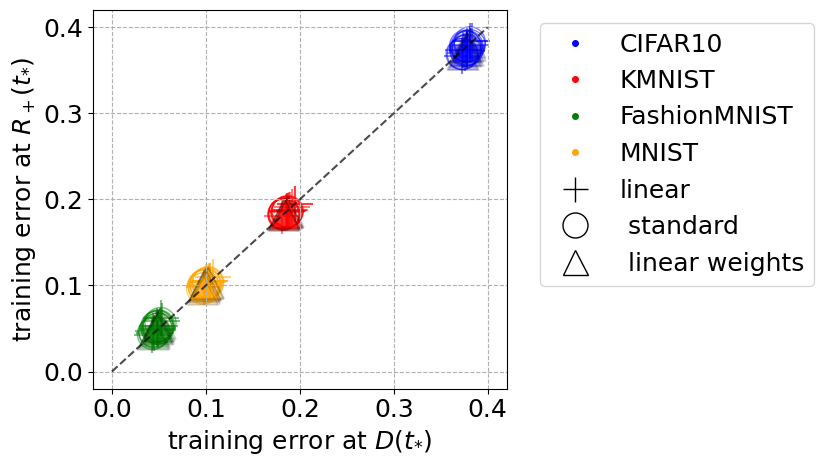

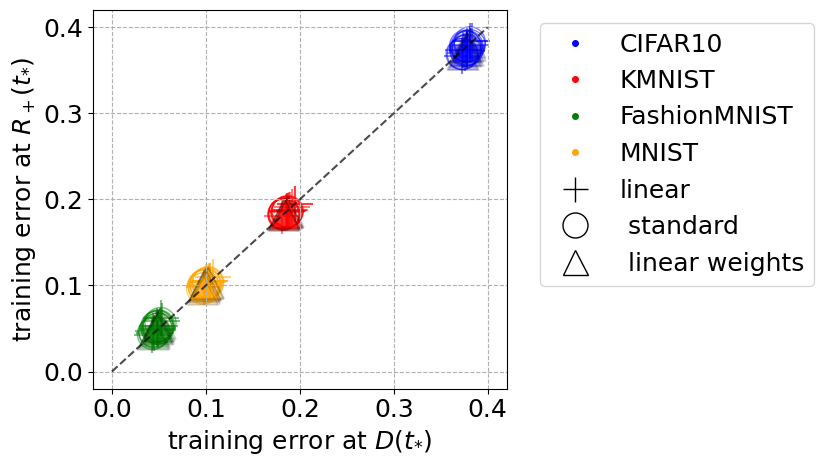

In [ ]:
file_paths = {
    'CIFAR10': ['/content/max_distance_info_linw_CIFAR10.txt', '/content/max_distance_info_lin_CIFAR10.txt', '/content/max_distance_info_non_lin_CIFAR10.txt'],
    'KMNIST': ['/content/max_distance_info_linw_KMNIST.txt', '/content/max_distance_info_lin_KMNIST.txt', '/content/max_distance_info_non_lin_CIFAR10.txt'],
    'FashionMNIST': ['/content/max_distance_info_linw_FashionMNIST.txt', '/content/max_distance_info_lin_FashionMNIST.txt', '/content/max_distance_info_non_lin_CIFAR10.txt'],
    'MNIST': ['/content/max_distance_info_linw_MNIST.txt', '/content/max_distance_info_lin_MNIST.txt', '/content/max_distance_info_lin_CIFAR10.txt']
}


colors = ['blue', 'red', 'green', 'orange']
dataset_labels = list(file_paths.keys())


all_points_lin = {}
all_points_non_lin = {}
all_points_linw ={}
for dataset_name, paths in file_paths.items():
    try:
        #column 3: training error at D inversion, column 5: training error at R+ inversion
        data_lin_dataset = np.loadtxt(paths[0], usecols=(2, 6), skiprows=1)
        all_points_lin[dataset_name] = data_lin_dataset
        data_non_lin_dataset = np.loadtxt(paths[1], usecols=(2, 6), skiprows=1)
        all_points_non_lin[dataset_name] = data_non_lin_dataset
        data_linw_dataset = np.loadtxt(paths[1], usecols=(2, 6), skiprows=1)
        all_points_linw[dataset_name] = data_linw_dataset

    except FileNotFoundError as e:
        print(f"Error: File {e.filename} not found for dataset {dataset_name}.")
    except IndexError:
        print(f"Error: Ensure column indices in np.loadtxt are correct for dataset {dataset_name} files.")
    except Exception as e:
        print(f"An error occurred processing dataset {dataset_name}: {e}")

plt.figure(figsize=(11,5))
#plot for linearized network training error
for i, dataset_name in enumerate(dataset_labels):
    if dataset_name in all_points_lin:
        data = all_points_lin[dataset_name]
        plt.scatter(data[:, 0], data[:, 1],
                    color=colors[i % len(colors)],
                    marker='+',
                    s=700,
                    alpha=0.5,
                    )
#plot for standard feedforward network training error
    if dataset_name in all_points_non_lin:
        data = all_points_non_lin[dataset_name]
        print(data)
        plt.scatter(data[:, 0], data[:, 1],
                    color=colors[i % len(colors)],
                    marker='o',
                    facecolor='none',
                    edgecolor=colors[i % len(colors)],
                    s=500,
                    alpha=0.5
        )
  #plot for standard feedforward network with linearized weights training error
    if dataset_name in all_points_linw:
        data = all_points_linw[dataset_name]
        print(data)
        plt.scatter(data[:, 0], data[:, 1],
                    color=colors[i % len(colors)],
                    marker='^',
                    facecolor=colors[i % len(colors)],
                    edgecolor="black",
                    s=500,
                    alpha=0.15
        )


x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
line_limits = [0, 0.4]
plt.plot(line_limits, line_limits, 'k--', alpha=0.7)


plt.xlabel(r'training error at $D(t_{*})$')
plt.ylabel(r'training error at $R_+(t_{*})$')


legend_elements = []
for i, dataset_name in enumerate(dataset_labels):
    color_for_dataset = colors[i % len(colors)]
    legend_elements.append(Line2D([0], [0], marker='.', color=color_for_dataset, label=f'{dataset_name}', markersize=8, linestyle='None'))

legend_elements.append(Line2D([0], [0], marker='+', color='black', label='linear', markersize=18, linestyle='None'))
legend_elements.append(Line2D([0], [0], marker='o', color='black', label=' standard',
                                  markerfacecolor='none', markeredgecolor='black', markersize=18, linestyle='None'))
legend_elements.append(Line2D([0], [0], marker='^', color='black', label=' linear weights',
                                  markerfacecolor='none', markeredgecolor='black', markersize=18, linestyle='None'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.grid(True, which="both", linestyle='--')


plt.tight_layout(rect=[0, 0, 0.8, 1])


display.display(plt.gcf())


plt.savefig("grafico_punti_individuali_non_lin_vs_linw_vs_lin.pdf", bbox_inches='tight')


# Plot of $\varepsilon_{tr}(t_{*})$ vs. $\varepsilon_{tr}^{lin}(t_{*})$

In this section, we plot training error of linearized model (called $\epsilon_{tr}^{lin}(t)$),together with training error of standard feedforward network (called $\epsilon_{tr}(t)$).


The plot shows the training error at inversion, for $D(t)$ and $R_\pm(t)$

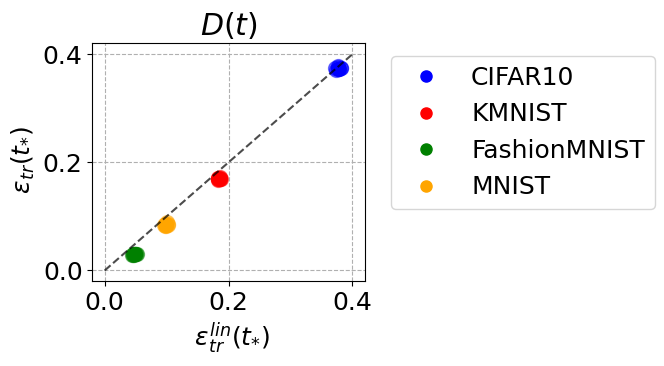

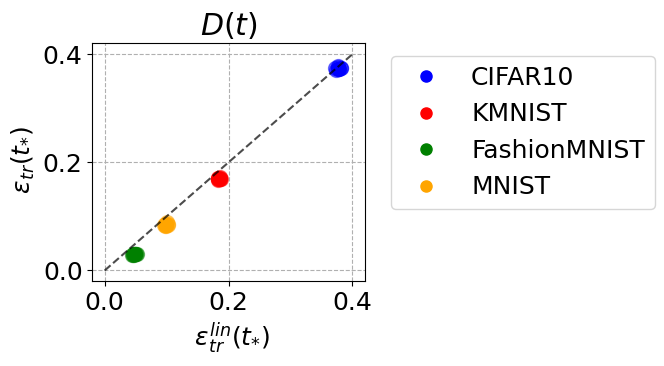

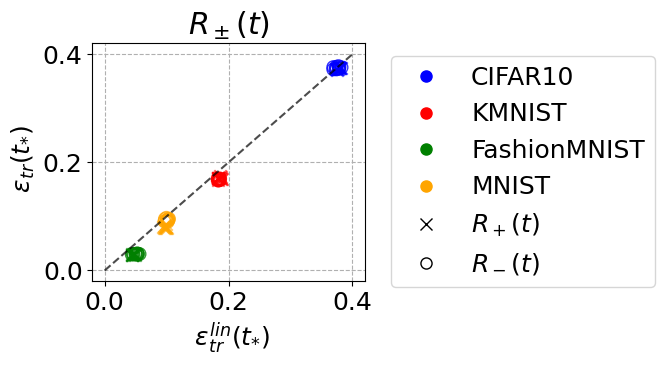

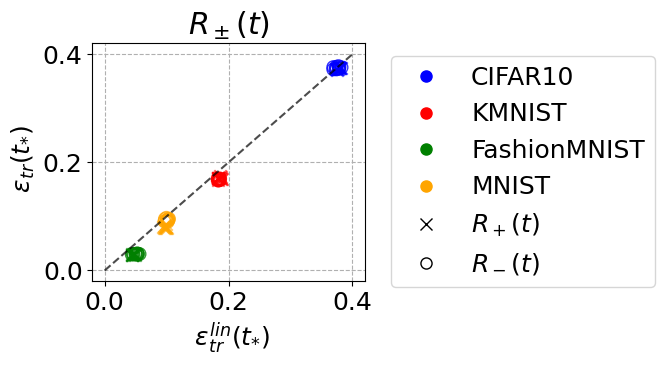

In [ ]:

file_paths = {
    'CIFAR10': ['/content/max_distance_info_lin_CIFAR10.txt', '/content/max_distance_info_non_lin_CIFAR10.txt'],
    'KMNIST': ['/content/max_distance_info_lin_KMNIST.txt', '/content/max_distance_info_non_lin_KMNIST.txt'],
    'FashionMNIST': ['/content/max_distance_info_lin_FashionMNIST.txt', '/content/max_distance_info_non_lin_FashionMNIST.txt'],
    'MNIST': ['/content/max_distance_info_lin_MNIST.txt', '/content/max_distance_info_non_lin_MNIST.txt']
}

colors = ['blue', 'red', 'green', 'orange']
dataset_labels = list(file_paths.keys())

all_points_lin_col2 = {}
all_points_non_lin_col2 = {}
all_points_lin_col6 = {}
all_points_non_lin_col6 = {}
all_points_lin_col7 = {}
all_points_non_lin_col7 = {}

for dataset_name, paths in file_paths.items():
    try:
        lin_path, non_lin_path = paths
        all_points_lin_col2[dataset_name] = np.loadtxt(lin_path, usecols=(2), skiprows=1)
        all_points_non_lin_col2[dataset_name] = np.loadtxt(non_lin_path, usecols=(2), skiprows=1)
        all_points_lin_col6[dataset_name] = np.loadtxt(lin_path, usecols=(6), skiprows=1)
        all_points_non_lin_col6[dataset_name] = np.loadtxt(non_lin_path, usecols=(6), skiprows=1)
        all_points_lin_col7[dataset_name] = np.loadtxt(lin_path, usecols=(7), skiprows=1)
        all_points_non_lin_col7[dataset_name] = np.loadtxt(non_lin_path, usecols=(7), skiprows=1)
    except Exception as e:
        print(f"Errore con {dataset_name}: {e}")

plt.figure(figsize=(9, 4))
for i, dataset_name in enumerate(dataset_labels):
    if dataset_name in all_points_lin_col2:
        plt.scatter(all_points_lin_col2[dataset_name],
                    all_points_non_lin_col2[dataset_name],
                    color=colors[i % len(colors)],
                    marker='o',
                    s=100,
                    alpha=0.5)
line_limits = [0, 0.4]
#k  stands for black color,-- stands for a dashed line style
plt.plot(line_limits, line_limits, 'k--', alpha=0.7)
plt.xlabel(r' $\epsilon_{tr}^{lin}(t_{*})$')
plt.ylabel(r' $\epsilon_{tr}(t_{*})$ ')
plt.title(r'$D(t)$')
legend_elements = [
    Line2D([0], [0], marker='o', color=color, label=f'{name}',
           markersize=8, linestyle='None')
    for name, color in zip(dataset_labels, colors)
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout(rect=[0, 0, 0.8, 1])
display.display(plt.gcf())
plt.savefig("grafico_inversione_D_lin_vs_deep.pdf", bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(9, 4))
for i, dataset_name in enumerate(dataset_labels):
    if dataset_name in all_points_lin_col6 and dataset_name in all_points_non_lin_col6:
       plt.scatter(all_points_lin_col6[dataset_name],
                all_points_non_lin_col6[dataset_name],
                facecolors='none',
                edgecolors=colors[i % len(colors)],
                marker='o',
                s=80,
                alpha=0.8)

    if dataset_name in all_points_lin_col7 and dataset_name in all_points_non_lin_col7:
        plt.scatter(all_points_lin_col7[dataset_name],
                    all_points_non_lin_col7[dataset_name],
                    color=colors[i % len(colors)],
                    marker='x',
                    s=80,
                    alpha=0.6)
plt.plot(line_limits, line_limits, 'k--', alpha=0.7)
plt.xlabel(r' $\epsilon_{tr}^{lin}(t_{*})$')
plt.ylabel(r' $\epsilon_{tr}(t_{*})$')
plt.title(r'$R_\pm(t)$')

legend_elements_extra = [
    Line2D([0], [0], marker='o', color=color, label=f'{name}',
           markersize=8, linestyle='None')
    for name, color in zip(dataset_labels, colors)
] + [
    Line2D([0], [0], marker='x', color="black", label=r'$R_+(t)$',
           markersize=8, linestyle='None')
] + [
    Line2D([0], [0], marker='o', color='black', mfc='none', label=r'$R_-(t)$',
       markersize=8, linestyle='None')
]
plt.legend(handles=legend_elements_extra, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout(rect=[0, 0, 0.8, 1])
display.display(plt.gcf())
plt.savefig("grafico_inversione_R_lin_vs_deep.pdf",bbox_inches='tight')
plt.show()
plt.close()



# Plot of $\varepsilon_{tr}^{lin}(t_{*})$ vs. $\hat{\varepsilon}_{tr}(t_{*})$

In this section, we plot training error of linearized model (called $\epsilon_{tr}^{lin}(t)$),together with training error of standard feedforward network (called $\epsilon_{tr}(t)$).


The plot shows the training error at inversion, for $D(t)$ and $R_\pm(t)$

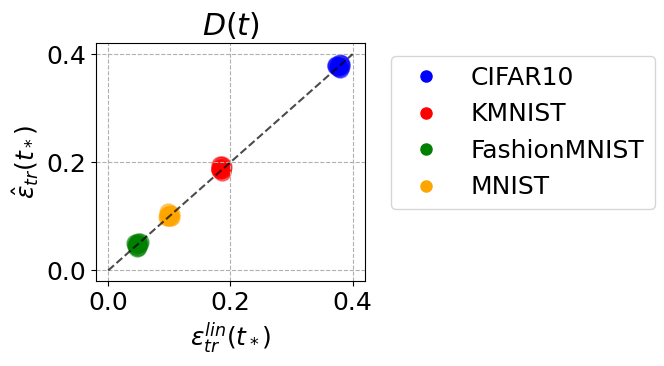

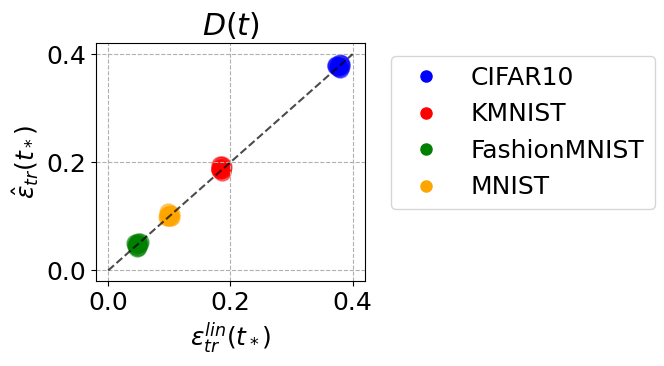

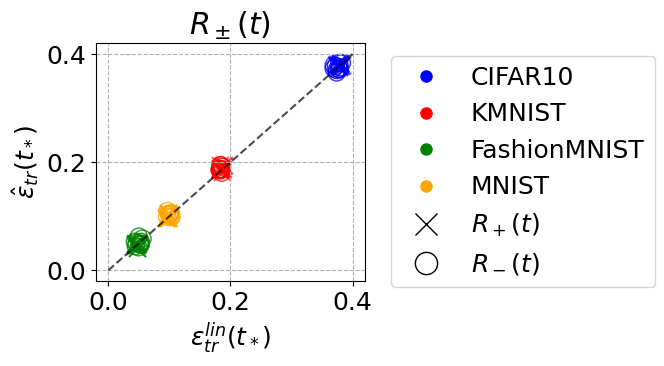

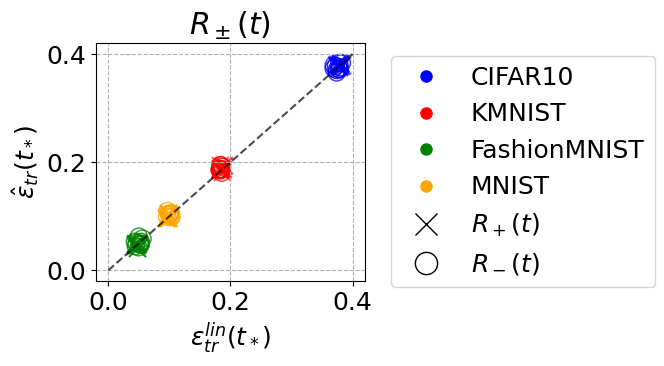

In [ ]:

file_paths = {
    'CIFAR10': ['/content/max_distance_info_lin_CIFAR10.txt', '/content/max_distance_info_linw_CIFAR10.txt'],
    'KMNIST': ['/content/max_distance_info_lin_KMNIST.txt', '/content/max_distance_info_linw_KMNIST.txt'],
    'FashionMNIST': ['/content/max_distance_info_lin_FashionMNIST.txt', '/content/max_distance_info_linw_FashionMNIST.txt'],
    'MNIST': ['/content/max_distance_info_lin_MNIST.txt', '/content/max_distance_info_linw_MNIST.txt']
}

colors = ['blue', 'red', 'green', 'orange']
dataset_labels = list(file_paths.keys())

all_points_lin_col2 = {}
all_points_non_lin_col2 = {}
all_points_lin_col6 = {}
all_points_non_lin_col6 = {}
all_points_lin_col7 = {}
all_points_non_lin_col7 = {}

for dataset_name, paths in file_paths.items():
    try:
        lin_path, non_lin_path = paths
        all_points_lin_col2[dataset_name] = np.loadtxt(lin_path, usecols=(2), skiprows=1)
        all_points_non_lin_col2[dataset_name] = np.loadtxt(non_lin_path, usecols=(2), skiprows=1)
        all_points_lin_col6[dataset_name] = np.loadtxt(lin_path, usecols=(6), skiprows=1)
        all_points_non_lin_col6[dataset_name] = np.loadtxt(non_lin_path, usecols=(6), skiprows=1)
        all_points_lin_col7[dataset_name] = np.loadtxt(lin_path, usecols=(7), skiprows=1)
        all_points_non_lin_col7[dataset_name] = np.loadtxt(non_lin_path, usecols=(7), skiprows=1)
    except Exception as e:
        print(f"Errore con {dataset_name}: {e}")

plt.figure(figsize=(9, 4))
for i, dataset_name in enumerate(dataset_labels):
    if dataset_name in all_points_lin_col2:
        plt.scatter(all_points_lin_col2[dataset_name],
                    all_points_non_lin_col2[dataset_name],
                    color=colors[i % len(colors)],
                    marker='o',
                    s=150,
                    alpha=0.5)
line_limits = [0, 0.4]
plt.plot(line_limits, line_limits, 'k--', alpha=0.7)
plt.xlabel(r'$\epsilon_{tr}^{lin}(t_*)$')
plt.ylabel(r'$\hat{\epsilon}_{tr}(t_*)$')
plt.title(r'$D(t)$')
legend_elements = [
    Line2D([0], [0], marker='o', color=color, label=f'{name}',
           markersize=8, linestyle='None')
    for name, color in zip(dataset_labels, colors)
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout(rect=[0, 0, 0.8, 1])
display.display(plt.gcf())
plt.savefig("grafico_inversione_D_lin_vs_linw.pdf", bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(9, 4))
for i, dataset_name in enumerate(dataset_labels):
    if dataset_name in all_points_lin_col6 and dataset_name in all_points_non_lin_col6:
       plt.scatter(all_points_lin_col6[dataset_name],
                all_points_non_lin_col6[dataset_name],
                facecolors='none',
                edgecolors=colors[i % len(colors)],
                marker='o',
                s=150,
                alpha=0.8)

    if dataset_name in all_points_lin_col7 and dataset_name in all_points_non_lin_col7:
        plt.scatter(all_points_lin_col7[dataset_name],
                    all_points_non_lin_col7[dataset_name],
                    color=colors[i % len(colors)],
                    marker='x',
                    s=150,
                    alpha=0.6)
plt.plot(line_limits, line_limits, 'k--', alpha=0.7)
plt.xlabel(r'$\epsilon_{tr}^{lin}(t_*)$')
plt.ylabel(r'$\hat{\epsilon}_{tr}(t_*)$')
plt.title(r'$R_\pm(t)$')
legend_elements_extra = [
    Line2D([0], [0], marker='o', color=color, label=f'{name}',
           markersize=8, linestyle='None')
    for name, color in zip(dataset_labels, colors)
] + [
    Line2D([0], [0], marker='x', color="black", label=r'$R_+(t)$',
           markersize=16, linestyle='None')
] + [
    Line2D([0], [0], marker='o', color='black', mfc='none', label=r'$R_-(t)$',
       markersize=16, linestyle='None')
]
plt.legend(handles=legend_elements_extra, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout(rect=[0, 0, 0.8, 1])
display.display(plt.gcf())
plt.savefig("grafico_inversione_R_lin_vs_linw.pdf", bbox_inches='tight')
plt.show()
plt.close()


# Fit finite size scaling

In this section, we report the fraction of stragglers $\phi$ as a function of the number of data points used (PDATA, indicated as $P$ in the plots). We also perform a fit of $\phi(P)$ using a power law:
$
\phi(P) = \phi_{\infty} \left[ 1 - \left( \frac{P}{P_0} \right)^{-\gamma} + o\left(P^{-\gamma}\right) \right]
$
where $\phi_{\infty}$ indicates the fraction of stragglers in the limit $P \to \infty$.

In the code, for brevity:

* $\phi_{\infty}$ is denoted as ``a''
* $P_0$ is denoted as ``b''
* $\gamma$ is denoted as ``c''


The fit is performed on the three parameters $\phi_{\infty}$, $\log(P_0)$, and $\gamma$. The fit is done on $\log(P_0)$ to allow exploration of a wider range of $P_0$ values.

Fit is performed for both standard feedforward network and the linearized model.



In [ ]:
#function that fits the straggler fraction as a function of the number of data P
def plot_straggler_ratio_fit(file_paths, output_filename, colors, dataset_labels, power_law_func):

    all_pdata = {}
    all_mean_ratios = {}
    all_std_ratios = {}
    all_fitted_params = {}

    plt.figure(figsize=(10,4))

    for i, (dataset_name, file_path) in enumerate(file_paths.items()):
        try:
            straggler_data = np.loadtxt(file_path, skiprows=1)
            pdata_values = straggler_data[:, 0]
            ratio_min_radius = straggler_data[:, 7]
            run_numbers = straggler_data[:, 1]


            unique_pdata = np.unique(pdata_values)
            mean_y = []
            std_y = []

            for pdata in unique_pdata:
                y_values_for_pdata = ratio_min_radius[pdata_values == pdata]
                mean_y.append(np.mean(y_values_for_pdata))
                std_y.append(np.std(y_values_for_pdata))

            mean_y = np.array(mean_y)
            std_y = np.array(std_y)

            all_pdata[dataset_name] = unique_pdata
            all_mean_ratios[dataset_name] = mean_y
            all_std_ratios[dataset_name] = std_y


            unique_runs = np.unique(run_numbers)
            fitted_params_per_run = []

            for run in unique_runs:
                run_data = straggler_data[straggler_data[:, 1] == run]
                x_data_run = run_data[:, 0]
                y_data_run = run_data[:, 7]

                x_data_tensor_run = torch.tensor(x_data_run, dtype=torch.float32)
                y_data_tensor_run = torch.tensor(y_data_run, dtype=torch.float32)

                a = torch.tensor([max(y_data_run.max(), 1e-6)], requires_grad=True, dtype=torch.float32)
                logb = torch.tensor([6.0], requires_grad=True, dtype=torch.float32)
                c = torch.tensor([1.], requires_grad=True, dtype=torch.float32)

                optimizer_run = optim.Adam([{'params': [a, c], 'lr': 0.05}, {'params': [logb], 'lr': 0.005} ])
                loss_fn_run = nn.MSELoss()

                def closure_run():
                    optimizer_run.zero_grad()
                    y_pred_run = power_law_func(x_data_tensor_run, a, logb, c)
                    loss_run = loss_fn_run(y_pred_run, y_data_tensor_run)
                    loss_run.backward()
                    return loss_run

                prev_loss = 1e8
                for j in range(5000):
                    loss_val = optimizer_run.step(closure_run).item()
                    if abs(prev_loss - loss_val) < 1e-10:
                         break
                    prev_loss = loss_val



                fitted_params_per_run.append({'a': a.item(),'logb': logb.item(), 'c': c.item()})
            # Store average fitted parameters
            avg_a = np.mean([p['a'] for p in fitted_params_per_run])
            avg_logb = np.mean([p['logb'] for p in fitted_params_per_run])
            avg_c = np.mean([p['c'] for p in fitted_params_per_run])
            all_fitted_params[dataset_name] = {'a': avg_a, 'logb': avg_logb, 'c': avg_c}


            # Calculate mean and std of parameters
            params_a = [p['a'] for p in fitted_params_per_run]
            params_logb = [p['logb'] for p in fitted_params_per_run]
            params_c = [p['c'] for p in fitted_params_per_run]

            avg_a, std_a = np.mean(params_a), np.std(params_a)
            avg_logb, std_logb = np.mean(params_logb), np.std(params_logb)
            avg_c, std_c = np.mean(params_c), np.std(params_c)

            all_fitted_params[dataset_name] = {'a': avg_a, 'logb': avg_logb, 'c': avg_c}

            print(f"\n=== Average Fitted Parameters for {dataset_name} ===")
            print(f"Parametro a = {avg_a:.4f} ± {std_a:.4f}")
            print(f"Parametro logb = {avg_logb:.4f} ± {std_logb:.4f}")
            print(f"Parametro c = {avg_c:.4f} ± {std_c:.4f}")
            # data for the x-axis
            pdata_for_fit = np.linspace(0, unique_pdata.max(), 200)
            pdata_for_fit_positive = pdata_for_fit[pdata_for_fit > 1e-6]
            pdata_for_fit_positive_tensor = torch.tensor(pdata_for_fit_positive, dtype=torch.float32)

            # Mean curve
            fitted_curve_y = power_law_func(pdata_for_fit_positive_tensor, avg_a, avg_logb, avg_c).detach().numpy()

            # Curves with mean ± std
            fitted_curve_y_upper = power_law_func(
                pdata_for_fit_positive_tensor, avg_a + std_a, avg_logb + std_logb, avg_c + std_c
            ).detach().numpy()

            fitted_curve_y_lower = power_law_func(
                pdata_for_fit_positive_tensor, avg_a - std_a, avg_logb - std_logb, avg_c - std_c
            ).detach().numpy()

            # Plot experimental data
            plt.errorbar(unique_pdata, mean_y, yerr=std_y, fmt='o', capsize=5, color=colors[i % len(colors)])

            # Plot mean curve
            plt.plot(pdata_for_fit_positive, fitted_curve_y, color=colors[i % len(colors)], linestyle='--', label=f"{dataset_name} mean fit")

            # Uncertainty band
            plt.fill_between(
                pdata_for_fit_positive,
                fitted_curve_y_lower,
                fitted_curve_y_upper,
                color=colors[i % len(colors)],
                alpha=0.3,
                label="±1σ fit"
            )

        except FileNotFoundError:
            print(f"Warning: File not found for dataset {dataset_name}: {file_path}")

    legend_elements = []
    for i, dataset_name in enumerate(dataset_labels):
        color_for_dataset = colors[i % len(colors)]
        legend_elements.append(Line2D([0], [0], marker='.', color=color_for_dataset, label=f'{dataset_name}', markersize=8, linestyle='None'))

    plt.ylim([0., 0.22])
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('P')
    plt.ylabel(r'$\phi(P)$')


    plt.grid(True, which="both", linestyle='--')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f"{output_filename}", bbox_inches='tight')
    plt.show()

    print("All fitted parameters")
    for dataset, params in all_fitted_params.items():
         b = np.exp(params['logb'])
         print(f"{dataset}: a={params['a']:.4f}, b={b:.4f}, c={params['c']:.4f}")

## Standard feedforward network

In [ ]:
DEPTH = 2
LATENT = 1
RUNS = 15
EPOCHS = 5500
LEARNING_RATE = 0.02
OPTIMIZER = torch.optim.SGD
WIDTHS = (20,)

ORIGINAL_PDATA = 32768
n=6 #number of different P values used for each dataset
results_non_lin = []
misclassified_examples_all_runs = []
misclassified_data_min_distance_list = []
multiplier = len(WIDTHS)
max_distance_info = []
straggler_info_non_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]


header = "PDATA\tRun\tepoch of max distance\ttrain error of max distance\tmax distance\tepoch of min radius\ttrain error of min radius\tmin radius"

with open(f"/content/max_distance_info_non_lin_{DATASET_NAME}.txt", "w") as f: # Changed to 'w' to overwrite and ensure header is first
    f.write(header + "\n")


straggler_header_non_lin = "PDATA\tRun\tEpoch_max_distance\tNum_Stragglers_max_distance\tRatio_max_distance\tEpoch_min_radius\tNum_Stragglers_min_radius\tRatio_min_radius"
with open(f"/content/straggler_info_non_lin_{DATASET_NAME}.txt", "w") as f:
    f.write(straggler_header_non_lin + "\n")


for i in range(n):
    PDATA = int(ORIGINAL_PDATA/(1.5**i)) #n different P values
    DATA_BLOCK = 1

    print(f"\nProcessing with PDATA: {PDATA}")


    data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

    print("Forma del tensore data subito dopo il caricamento:", data.shape) # Shape of data tensor immediately after loading
    current_pdata_size = data.shape[0]

    if current_pdata_size != PDATA:
         print(f"Warning: Loaded data size ({current_pdata_size}) does not match specified PDATA ({PDATA}). This might occur if PDATA exceeds dataset size.")


    input_size = data.shape[2] * data.shape[3]

    m_array = m_array_input(data, labels)


    results_non_lin_pdata = []
    misclassified_examples_all_runs_pdata = []
    max_distance_info_pdata = []

    for run in range(RUNS * multiplier):
        WIDTH = WIDTHS[run % multiplier]

        net = NN_KHL_classification(input_size, DEPTH, WIDTH, LATENT).to(device)

        optimizer = OPTIMIZER(net.parameters(), lr=LEARNING_RATE)
        criterion = torch.nn.CrossEntropyLoss()

        results_run = []
        misclassified_examples_run = []

        for epoch in range(EPOCHS):
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_preds = torch.argmax(outputs, dim=1)
            train_error = torch.sum(train_preds != labels).item() / data.shape[0]

            radii, distance = net.radii(data, labels)
            results_run.append([
                epoch,
                train_error,
                loss.item(),
                radii[0].item(),
                radii[1].item(),
                distance,
                WIDTH
            ])

            misclassified_mask = train_preds != labels
            misclassified_examples_run.append(misclassified_mask.cpu())

        results_non_lin_pdata.append(results_run)
        misclassified_examples_all_runs_pdata.append(misclassified_examples_run)

    arr_res_non_lin_pdata = np.array(results_non_lin_pdata)
    plt.figure(figsize=(6, 4))

    for kk in range(len(arr_res_non_lin_pdata)):

        distances_for_run = arr_res_non_lin_pdata[kk, :, 5]
        max_distance_epoch_index = np.argmax(distances_for_run)
        max_distance_value = distances_for_run[max_distance_epoch_index]
        max_distance_epoch = int(arr_res_non_lin_pdata[kk, max_distance_epoch_index, 0])
        train_error_max_distance = arr_res_non_lin_pdata[kk, max_distance_epoch_index, 1]

        print(f"PDATA {PDATA}, Run {kk} → max distance: {max_distance_value:.4f} at epoch {max_distance_epoch}") # max distance at epoch

        misclassified_mask_max_distance = misclassified_examples_all_runs_pdata[kk][max_distance_epoch_index].numpy()
        num_stragglers_max_distance = np.sum(misclassified_mask_max_distance)
        ratio_max_distance = num_stragglers_max_distance / current_pdata_size if current_pdata_size > 0 else 0

        print(f"  Number of misclassified examples (max distance): {num_stragglers_max_distance}") # Number of misclassified examples (max distance)


        epochs = arr_res_non_lin_pdata[kk, :, 0]
        radius_for_run = arr_res_non_lin_pdata[kk, :, 4]
        mask = epochs != 0
        filtered_epochs = epochs[mask]
        filtered_radii = radius_for_run[mask]

        min_radius_epoch_index_filtered = np.argmin(filtered_radii)
        min_radius_epoch = int(filtered_epochs[min_radius_epoch_index_filtered])
        min_radius_value = float(filtered_radii[min_radius_epoch_index_filtered])
        train_error_min_radius = float(arr_res_non_lin_pdata[kk][mask][min_radius_epoch_index_filtered][1])
        original_index_radius = np.where(epochs == min_radius_epoch)[0][0]


        misclassified_mask_radius = misclassified_examples_all_runs_pdata[kk][original_index_radius].numpy()
        num_stragglers_min_radius = np.sum(misclassified_mask_radius)
        ratio_min_radius = num_stragglers_min_radius / current_pdata_size if current_pdata_size > 0 else 0
        print
        print(f"  Number of misclassified examples (min radius): {num_stragglers_min_radius}") # Number of misclassified examples (min radius)

        max_distance_info.append([PDATA, kk, max_distance_epoch, train_error_max_distance, max_distance_value, min_radius_epoch, train_error_min_radius, min_radius_value])
        straggler_info_non_lin.append([PDATA, kk, max_distance_epoch, num_stragglers_max_distance, ratio_max_distance, min_radius_epoch, num_stragglers_min_radius, ratio_min_radius])


        plt.plot(arr_res_non_lin_pdata[kk, :, 1], arr_res_non_lin_pdata[kk, :, 5], color="green", linewidth=3,alpha=0.6,label="distance")
        plt.plot(arr_res_non_lin_pdata[kk, :, 1], arr_res_non_lin_pdata[kk, :, 4], color="red",linewidth=3,alpha=0.6, label="radius")

    plt.xlabel('Training error')
    plt.ylabel('Metric Value')
    plt.title(f"{DATASET_NAME} - PDATA {PDATA}")

    legend_elements = [
        Line2D([0], [0], color='green', linestyle='-',linewidth=3,alpha=0.6, label='Distance'),
        Line2D([0], [0], color='red', linestyle='-', linewidth=3,alpha=0.6,label='Radius'),
    ]
    plt.legend(handles=legend_elements)
    plt.savefig(f"{DATASET_NAME}_non_lin_pdata_{PDATA}.pdf", bbox_inches='tight')
    plt.show()


max_distance_info_matrix = np.array(max_distance_info)
with open(f"/content/max_distance_info_non_lin2_{DATASET_NAME}.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.4f', comments='')

straggler_info_non_lin_matrix = np.array(straggler_info_non_lin)
with open(f"/content/straggler_info_non_lin2_{DATASET_NAME}.txt", "a") as f:
    np.savetxt(f, straggler_info_non_lin_matrix, delimiter='\t', fmt='%d\t%d\t%d\t%d\t%.4f\t%d\t%d\t%.4f', comments='')


=== Average Fitted Parameters for KMNIST ===
Parametro a = 0.1954 ± 0.0030
Parametro logb = 6.0513 ± 0.0086
Parametro c = 0.6236 ± 0.0306

=== Average Fitted Parameters for FashionMNIST ===
Parametro a = 0.0453 ± 0.0038
Parametro logb = 6.0768 ± 0.0142
Parametro c = 0.3141 ± 0.0553

=== Average Fitted Parameters for MNIST ===
Parametro a = 0.1153 ± 0.0150
Parametro logb = 7.1802 ± 0.4340
Parametro c = 0.7887 ± 0.2618


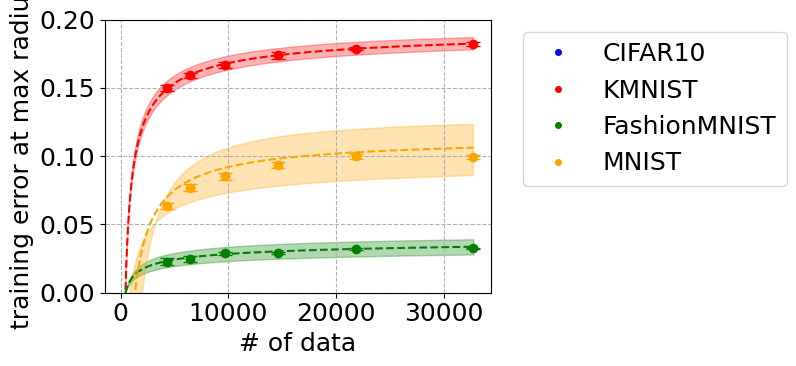

All fitted parameters
KMNIST: a=0.1954, b=424.6453, c=0.6236
FashionMNIST: a=0.0453, b=435.6468, c=0.3141
MNIST: a=0.1153, b=1313.1968, c=0.7887


In [ ]:
#plot the fit of phi as a function of P
file_paths = {
    'CIFAR10': f'/content/straggler_info_non_lin2_CIFAR10.txt',
    'KMNIST': f'/content/straggler_info_non_lin2_KMNIST.txt',
    'FashionMNIST': f'/content/straggler_info_non_lin2_FashionMNIST.txt',
    'MNIST': f'/content/straggler_info_non_lin2_MNIST.txt'
}
colors = ['blue', 'red', 'green', 'orange']

dataset_labels = list(file_paths.keys())


plot_straggler_ratio_fit(file_paths, "non_lin_scaling_all_datasets_linear_x.pdf", colors, dataset_labels, power_law)

## Linear model


Processing with PDATA: 32768
PDATA 32768, Run 0 → max distance: 1.3477 at epoch 275
  number of misclassified examples at epoch of max distance: 1532
  number of misclassified examples at epoch of max distance: 1543
PDATA 32768, Run 1 → max distance: 1.1703 at epoch 121
  number of misclassified examples at epoch of max distance: 1740
  number of misclassified examples at epoch of max distance: 1903
PDATA 32768, Run 2 → max distance: 1.3444 at epoch 778
  number of misclassified examples at epoch of max distance: 1334
  number of misclassified examples at epoch of max distance: 1320
PDATA 32768, Run 3 → max distance: 1.3450 at epoch 610
  number of misclassified examples at epoch of max distance: 1384
  number of misclassified examples at epoch of max distance: 1423
PDATA 32768, Run 4 → max distance: 1.3085 at epoch 208
  number of misclassified examples at epoch of max distance: 1705
  number of misclassified examples at epoch of max distance: 1886
PDATA 32768, Run 5 → max distance: 

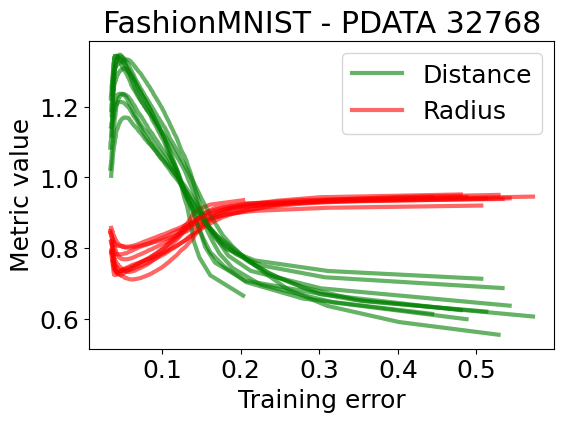


Processing with PDATA: 16384
PDATA 16384, Run 0 → max distance: 1.2014 at epoch 206
  number of misclassified examples at epoch of max distance: 823
  number of misclassified examples at epoch of max distance: 878
PDATA 16384, Run 1 → max distance: 1.2076 at epoch 346
  number of misclassified examples at epoch of max distance: 769
  number of misclassified examples at epoch of max distance: 931
PDATA 16384, Run 2 → max distance: 1.1684 at epoch 148
  number of misclassified examples at epoch of max distance: 861
  number of misclassified examples at epoch of max distance: 937
PDATA 16384, Run 3 → max distance: 1.3120 at epoch 856
  number of misclassified examples at epoch of max distance: 655
  number of misclassified examples at epoch of max distance: 644
PDATA 16384, Run 4 → max distance: 1.2574 at epoch 276
  number of misclassified examples at epoch of max distance: 776
  number of misclassified examples at epoch of max distance: 826
PDATA 16384, Run 5 → max distance: 1.2755 at 

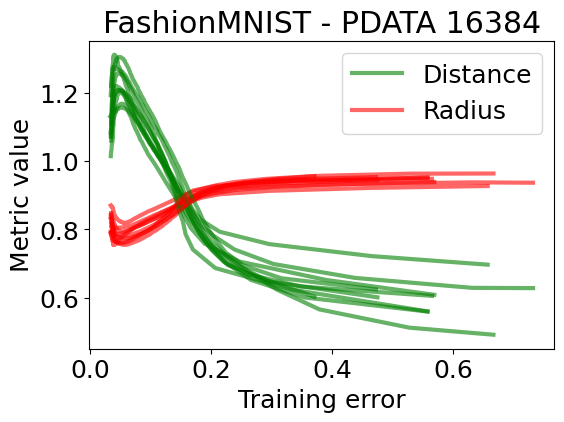


Processing with PDATA: 8192
PDATA 8192, Run 0 → max distance: 1.3186 at epoch 391
  number of misclassified examples at epoch of max distance: 373
  number of misclassified examples at epoch of max distance: 370
PDATA 8192, Run 1 → max distance: 1.4265 at epoch 571
  number of misclassified examples at epoch of max distance: 379
  number of misclassified examples at epoch of max distance: 373
PDATA 8192, Run 2 → max distance: 1.2949 at epoch 285
  number of misclassified examples at epoch of max distance: 378
  number of misclassified examples at epoch of max distance: 402
PDATA 8192, Run 3 → max distance: 1.2568 at epoch 301
  number of misclassified examples at epoch of max distance: 377
  number of misclassified examples at epoch of max distance: 410
PDATA 8192, Run 4 → max distance: 1.2870 at epoch 347
  number of misclassified examples at epoch of max distance: 372
  number of misclassified examples at epoch of max distance: 407
PDATA 8192, Run 5 → max distance: 1.2949 at epoch 2

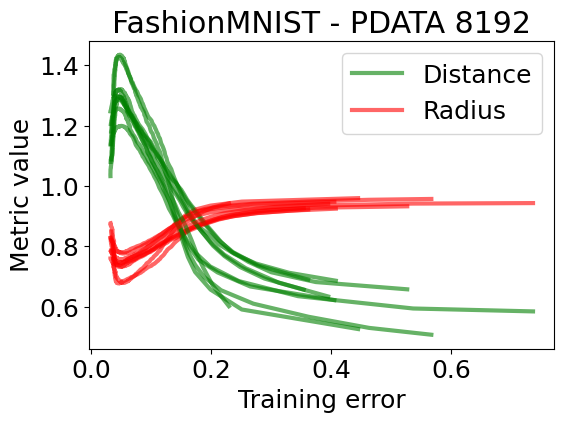


Processing with PDATA: 4096
PDATA 4096, Run 0 → max distance: 1.2354 at epoch 187
  number of misclassified examples at epoch of max distance: 202
  number of misclassified examples at epoch of max distance: 213
PDATA 4096, Run 1 → max distance: 1.3026 at epoch 337
  number of misclassified examples at epoch of max distance: 185
  number of misclassified examples at epoch of max distance: 185
PDATA 4096, Run 2 → max distance: 1.3076 at epoch 425
  number of misclassified examples at epoch of max distance: 193
  number of misclassified examples at epoch of max distance: 197
PDATA 4096, Run 3 → max distance: 1.1849 at epoch 197
  number of misclassified examples at epoch of max distance: 209
  number of misclassified examples at epoch of max distance: 204
PDATA 4096, Run 4 → max distance: 1.2140 at epoch 254
  number of misclassified examples at epoch of max distance: 202
  number of misclassified examples at epoch of max distance: 197
PDATA 4096, Run 5 → max distance: 1.3726 at epoch 4

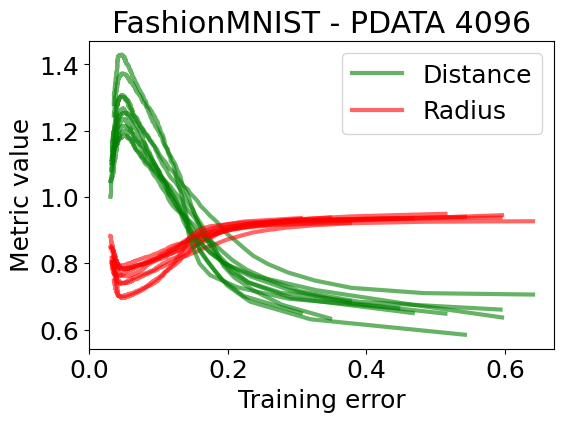


Processing with PDATA: 2048
PDATA 2048, Run 0 → max distance: 1.2933 at epoch 254
  number of misclassified examples at epoch of max distance: 104
  number of misclassified examples at epoch of max distance: 108
PDATA 2048, Run 1 → max distance: 1.2848 at epoch 528
  number of misclassified examples at epoch of max distance: 93
  number of misclassified examples at epoch of max distance: 97
PDATA 2048, Run 2 → max distance: 1.2781 at epoch 398
  number of misclassified examples at epoch of max distance: 92
  number of misclassified examples at epoch of max distance: 95
PDATA 2048, Run 3 → max distance: 1.3187 at epoch 375
  number of misclassified examples at epoch of max distance: 91
  number of misclassified examples at epoch of max distance: 90
PDATA 2048, Run 4 → max distance: 1.2731 at epoch 425
  number of misclassified examples at epoch of max distance: 97
  number of misclassified examples at epoch of max distance: 97
PDATA 2048, Run 5 → max distance: 1.2783 at epoch 256
  num

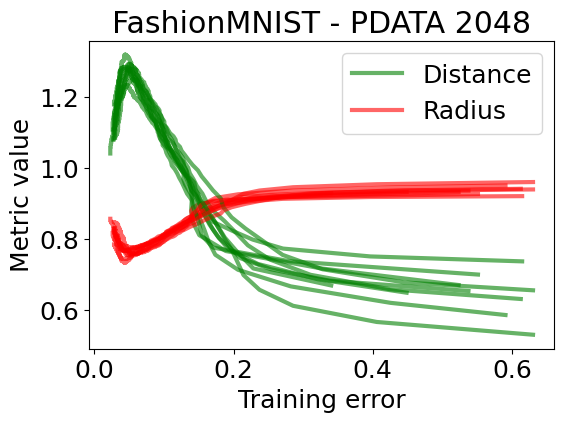


Processing with PDATA: 1024
PDATA 1024, Run 0 → max distance: 1.1830 at epoch 241
  number of misclassified examples at epoch of max distance: 43
  number of misclassified examples at epoch of max distance: 45
PDATA 1024, Run 1 → max distance: 1.2219 at epoch 213
  number of misclassified examples at epoch of max distance: 45
  number of misclassified examples at epoch of max distance: 56
PDATA 1024, Run 2 → max distance: 1.3762 at epoch 609
  number of misclassified examples at epoch of max distance: 38
  number of misclassified examples at epoch of max distance: 39
PDATA 1024, Run 3 → max distance: 1.2170 at epoch 192
  number of misclassified examples at epoch of max distance: 48
  number of misclassified examples at epoch of max distance: 55
PDATA 1024, Run 4 → max distance: 1.2403 at epoch 395
  number of misclassified examples at epoch of max distance: 37
  number of misclassified examples at epoch of max distance: 38
PDATA 1024, Run 5 → max distance: 1.2642 at epoch 232
  numbe

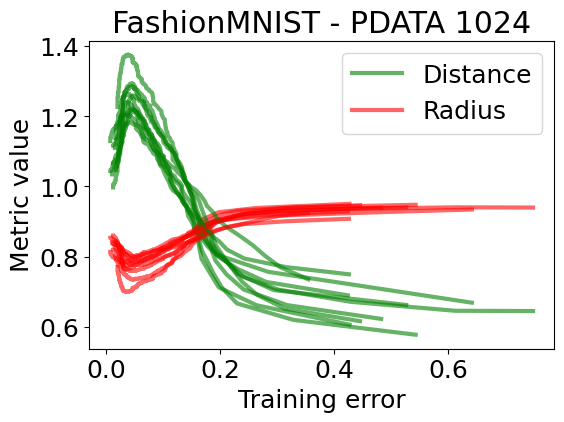

In [ ]:
DEPTH = 2
LATENT = 1
RUNS = 10
EPOCHS = 4000
LEARNING_RATE = 0.02
OPTIMIZER = torch.optim.SGD
WIDTHS = (20,)

ORIGINAL_PDATA = 32768
n=6
results_lin = []
misclassified_examples_all_runs = []
misclassified_data_min_distance_list = []
multiplier = len(WIDTHS)
max_distance_info = []
straggler_info_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]


header = "PDATA\tRun\tepoch of max distance\ttrain error of max distance\tmax distance\tepoch of min radius\ttrain error of min radius\tmin radius"

with open(f"/content/max_distance_info_lin_{DATASET_NAME}.txt", "w") as f:
    f.write(header + "\n")


straggler_header_lin = "PDATA\tRun\tEpoch_max_distance\tNum_Stragglers_max_distance\tRatio_max_distance\tEpoch_min_radius\tNum_Stragglers_min_radius\tRatio_min_radius"
with open(f"/content/straggler_info_lin_{DATASET_NAME}.txt", "w") as f:
    f.write(straggler_header_lin + "\n")


for i in range(n):
    PDATA = int(ORIGINAL_PDATA/(2.**i))
    DATA_BLOCK = 1

    print(f"\nProcessing with PDATA: {PDATA}")


    data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

    current_pdata_size = data.shape[0]

    if current_pdata_size != PDATA:
         print(f"Warning: Loaded data size ({current_pdata_size}) does not match specified PDATA ({PDATA}). This might occur if PDATA exceeds dataset size.")

    input_size = data.shape[2] * data.shape[3]

    labels_float = labels.float()
    test_data, test_labels = test_data.to(device), test_labels.to(device)

    m_array = m_array_input(data, labels)

    results_lin_pdata = []
    misclassified_examples_all_runs_pdata = []
    max_distance_info_pdata = []

    for run in range(RUNS * multiplier):
        WIDTH = WIDTHS[run % multiplier]

        net = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init.load_state_dict(net.state_dict())

        theta0_dict = dict(net.named_parameters())
        theta0_flat = nn.utils.parameters_to_vector(list(net.parameters())).detach()


        features = compute_tangent_features_batch(net, theta0_dict, data)


        linearized_net = linearized_NN(features.shape[1]).to(device)
        optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)
        criterion = nn.MSELoss()

        results_run = []
        misclassified_examples_run = []

        for epoch in range(EPOCHS):
            optimizer.zero_grad()

            with torch.no_grad():
                net_base = net_at_init(data)

            pred_lin = linearized_net(features) + net_base
            loss_lin = criterion(pred_lin, labels_float)
            loss_lin.backward()
            optimizer.step()

            new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
            nn.utils.vector_to_parameters(new_weights, net.parameters())

            with torch.no_grad():
                train_preds = (pred_lin >= 0.5).float()
                train_err = torch.abs(train_preds - labels_float).mean().item()
                radii, distance = net.radii(data, labels)

            results_run.append([
            epoch,
            train_err,
            float(loss_lin.item()),
            float(radii[0].item()),
            float(radii[1].item()),
            float(distance),
            int(WIDTH)
            ])


            misclassified_mask = train_preds != labels
            misclassified_examples_run.append(misclassified_mask.cpu())

        results_lin_pdata.append(results_run)
        misclassified_examples_all_runs_pdata.append(misclassified_examples_run)

    arr_res_lin_pdata = np.array(results_lin_pdata)
    plt.figure(figsize=(6, 4))

    for kk in range(len(arr_res_lin_pdata)):

        distances_for_run = arr_res_lin_pdata[kk, :, 5]
        max_distance_epoch_index = np.argmax(distances_for_run)
        max_distance_value = distances_for_run[max_distance_epoch_index]
        max_distance_epoch = int(arr_res_lin_pdata[kk, max_distance_epoch_index, 0])
        train_error_max_distance = arr_res_lin_pdata[kk, max_distance_epoch_index, 1]

        print(f"PDATA {PDATA}, Run {kk} → max distance: {max_distance_value:.4f} at epoch {max_distance_epoch}")

        misclassified_mask_max_distance = misclassified_examples_all_runs_pdata[kk][max_distance_epoch_index].numpy()
        num_stragglers_max_distance = np.sum(misclassified_mask_max_distance)
        ratio_max_distance = num_stragglers_max_distance / current_pdata_size if current_pdata_size > 0 else 0

        print(f"  number of misclassified examples at epoch of max distance: {num_stragglers_max_distance}")

        epochs = arr_res_lin_pdata[kk, :, 0]
        radius_for_run = arr_res_lin_pdata[kk, :, 4]
        mask = epochs != 0
        filtered_epochs = epochs[mask]
        filtered_radii = radius_for_run[mask]

        min_radius_epoch_index_filtered = np.argmin(filtered_radii)
        min_radius_epoch = int(filtered_epochs[min_radius_epoch_index_filtered])
        min_radius_value = float(filtered_radii[min_radius_epoch_index_filtered])
        train_error_min_radius = float(arr_res_lin_pdata[kk][mask][min_radius_epoch_index_filtered][1])
        original_index_radius = np.where(epochs == min_radius_epoch)[0][0]


        misclassified_mask_radius = misclassified_examples_all_runs_pdata[kk][original_index_radius].numpy()
        num_stragglers_min_radius = np.sum(misclassified_mask_radius)
        ratio_min_radius = num_stragglers_min_radius / current_pdata_size if current_pdata_size > 0 else 0
        print
        print(f"  number of misclassified examples at epoch of max distance: {num_stragglers_min_radius}")

        max_distance_info.append([PDATA, kk, max_distance_epoch, train_error_max_distance, max_distance_value, min_radius_epoch, train_error_min_radius, min_radius_value])
        straggler_info_lin.append([PDATA, kk, max_distance_epoch, num_stragglers_max_distance, ratio_max_distance, min_radius_epoch, num_stragglers_min_radius, ratio_min_radius])


        plt.plot(arr_res_lin_pdata[kk, :, 1], arr_res_lin_pdata[kk, :, 5], color="green", linewidth=3,alpha=0.6,label="distance")
        plt.plot(arr_res_lin_pdata[kk, :, 1], arr_res_lin_pdata[kk, :, 4], color="red",linewidth=3,alpha=0.6, label="radius")

    plt.xlabel('Training error')
    plt.ylabel('Metric value')
    plt.title(f"{DATASET_NAME} - PDATA {PDATA}")

    legend_elements = [
        Line2D([0], [0], color='green', linestyle='-',linewidth=3,alpha=0.6, label='Distance'),
        Line2D([0], [0], color='red', linestyle='-', linewidth=3,alpha=0.6,label='Radius'),
    ]
    plt.legend(handles=legend_elements)
    plt.savefig(f"{DATASET_NAME}_lin_pdata_{PDATA}.pdf", bbox_inches='tight')
    plt.show()


max_distance_info_matrix = np.array(max_distance_info)
with open(f"/content/max_distance_info_lin_{DATASET_NAME}.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.4f', comments='')

straggler_info_lin_matrix = np.array(straggler_info_lin)
with open(f"/content/straggler_info_lin_{DATASET_NAME}.txt", "a") as f:
    np.savetxt(f, straggler_info_lin_matrix, delimiter='\t', fmt='%d\t%d\t%d\t%d\t%.4f\t%d\t%d\t%.4f', comments='')


=== Average Fitted Parameters for KMNIST ===
Parametro a = 0.2029 ± 0.0072
Parametro logb = 4.5740 ± 0.6139
Parametro c = 0.5790 ± 0.1902

=== Average Fitted Parameters for FashionMNIST ===
Parametro a = 0.0504 ± 0.0022
Parametro logb = 5.7996 ± 0.4267
Parametro c = 2.7545 ± 1.2835

=== Average Fitted Parameters for MNIST ===
Parametro a = 0.1260 ± 0.0059
Parametro logb = 5.1699 ± 0.2363
Parametro c = 0.4173 ± 0.0544


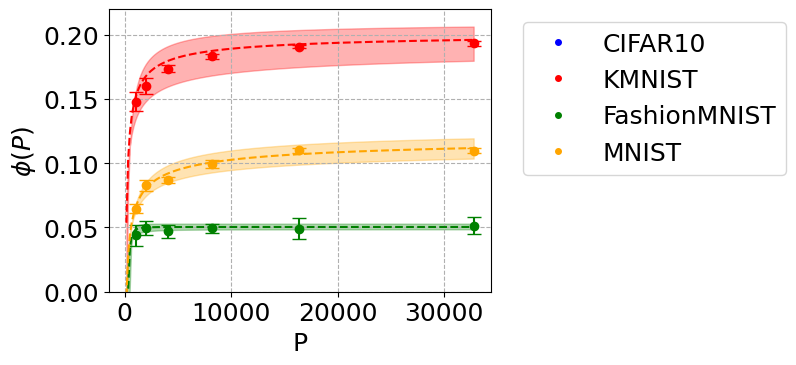

All fitted parameters
KMNIST: a=0.2029, b=96.9294, c=0.5790
FashionMNIST: a=0.0504, b=330.1730, c=2.7545
MNIST: a=0.1260, b=175.8898, c=0.4173


In [ ]:

file_paths = {
    'CIFAR10': f'/content/straggler_info_lin_CIFAR10.txt',
    'KMNIST': f'/content/straggler_info_lin_KMNIST.txt',
    'FashionMNIST': f'/content/straggler_info_lin_FashionMNIST.txt',
    'MNIST': f'/content/straggler_info_lin_MNIST.txt'
}
colors = ['blue', 'red', 'green', 'orange']

dataset_labels = list(file_paths.keys())


plot_straggler_ratio_fit(file_paths, "lin_scaling_all_datasets_linear_x.pdf", colors, dataset_labels, power_law)

# Fit with varying depth and width

In this section, we fit the fraction of stragglers $\phi(P)$ as a function of the number of data points $P$, varying widths and depths. The fit is performed using a power law:
$
\phi(P) = \phi_{\infty} \left[ 1 - \left( \frac{P}{P_0} \right)^{-\gamma} + o\left(P^{-\gamma}\right) \right]
$
where $\phi_{\infty}$ indicates the fraction of stragglers in the limit $P \to \infty$.

* $\phi_{\infty}$ is denoted as ``a''
* $P_0$ is denoted as ``b''
* $\gamma$ is denoted as ``c''


The fit is performed on the three parameters $\phi_{\infty}$, $\log(P_0)$, and $\gamma$. The fit is done on $\log(P_0)$ to allow exploration of a wider range of $P_0$ values.

For each depth and width we estimate $\phi_\infty$.


Fit is performed for both standard feedforward network and the linearized model (nel modello linearizzato si usa un solo valore di depth).



## Standard feeforward network
In this cell, the fit of $\phi (P)$
 with the power law is performed to obtain the values of $\phi_\infty$ as a function of the network's width and depth.

 The average values of
$\phi_\infty$
 found in this cell are compared with those reported in the paper *Inversion Dinamics of Class Manifolds in Deep Learning Reveals Tradeoffs Underlying Generalisation*.


Processing with Depth: 8

Processing with Width: 40
  Processing with PDATA: 32768
  PDATA 32768, Run 0, max distance: 1.0287 at epoch 145
 Number of misclassified examples at max distance: 3825
 Number of misclassified examples at max distance: 4117
  PDATA 32768, Run 1, max distance: 1.0304 at epoch 157
 Number of misclassified examples at max distance: 3780
 Number of misclassified examples at max distance: 4113
  PDATA 32768, Run 2, max distance: 1.0121 at epoch 144
 Number of misclassified examples at max distance: 3800
 Number of misclassified examples at max distance: 4122
  PDATA 32768, Run 3, max distance: 1.0138 at epoch 151
 Number of misclassified examples at max distance: 3797
 Number of misclassified examples at max distance: 4130
  PDATA 32768, Run 4, max distance: 1.0306 at epoch 151
 Number of misclassified examples at max distance: 3808
 Number of misclassified examples at max distance: 4170
  PDATA 32768, Run 5, max distance: 1.0203 at epoch 171
 Number of misclassi

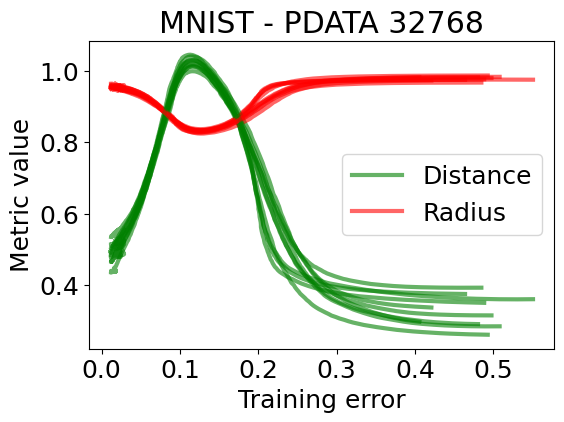

  Processing with PDATA: 21845
  PDATA 21845, Run 10, max distance: 1.0510 at epoch 171
 Number of misclassified examples at max distance: 2516
 Number of misclassified examples at max distance: 2798
  PDATA 21845, Run 11, max distance: 1.0432 at epoch 167
 Number of misclassified examples at max distance: 2474
 Number of misclassified examples at max distance: 2668
  PDATA 21845, Run 12, max distance: 1.0393 at epoch 186
 Number of misclassified examples at max distance: 2527
 Number of misclassified examples at max distance: 2775
  PDATA 21845, Run 13, max distance: 1.0160 at epoch 137
 Number of misclassified examples at max distance: 2460
 Number of misclassified examples at max distance: 2758
  PDATA 21845, Run 14, max distance: 1.0445 at epoch 142
 Number of misclassified examples at max distance: 2479
 Number of misclassified examples at max distance: 2696
  PDATA 21845, Run 15, max distance: 1.0173 at epoch 207
 Number of misclassified examples at max distance: 2492
 Number of 

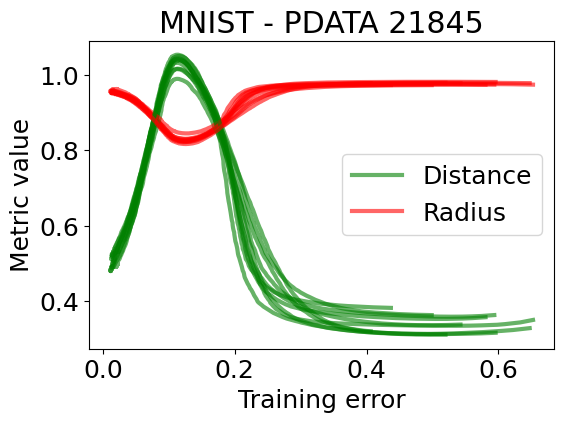

  Processing with PDATA: 14563
  PDATA 14563, Run 20, max distance: 1.0475 at epoch 139
 Number of misclassified examples at max distance: 1600
 Number of misclassified examples at max distance: 1734
  PDATA 14563, Run 21, max distance: 1.0128 at epoch 167
 Number of misclassified examples at max distance: 1584
 Number of misclassified examples at max distance: 1781
  PDATA 14563, Run 22, max distance: 1.0230 at epoch 145
 Number of misclassified examples at max distance: 1552
 Number of misclassified examples at max distance: 1710
  PDATA 14563, Run 23, max distance: 1.0258 at epoch 159
 Number of misclassified examples at max distance: 1608
 Number of misclassified examples at max distance: 1738
  PDATA 14563, Run 24, max distance: 1.0325 at epoch 164
 Number of misclassified examples at max distance: 1610
 Number of misclassified examples at max distance: 1753
  PDATA 14563, Run 25, max distance: 1.0367 at epoch 164
 Number of misclassified examples at max distance: 1581
 Number of 

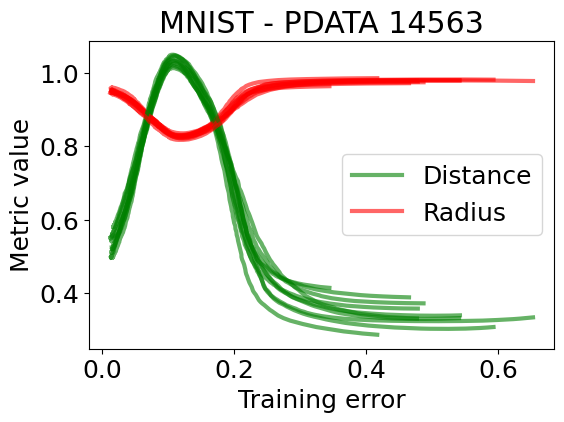

  Processing with PDATA: 9709
  PDATA 9709, Run 30, max distance: 1.0488 at epoch 167
 Number of misclassified examples at max distance: 1021
 Number of misclassified examples at max distance: 1157
  PDATA 9709, Run 31, max distance: 1.0410 at epoch 162
 Number of misclassified examples at max distance: 998
 Number of misclassified examples at max distance: 1098
  PDATA 9709, Run 32, max distance: 1.0544 at epoch 164
 Number of misclassified examples at max distance: 999
 Number of misclassified examples at max distance: 1096
  PDATA 9709, Run 33, max distance: 1.0448 at epoch 167
 Number of misclassified examples at max distance: 1029
 Number of misclassified examples at max distance: 1103
  PDATA 9709, Run 34, max distance: 1.0674 at epoch 132
 Number of misclassified examples at max distance: 1038
 Number of misclassified examples at max distance: 1136
  PDATA 9709, Run 35, max distance: 1.0277 at epoch 147
 Number of misclassified examples at max distance: 1025
 Number of misclassi

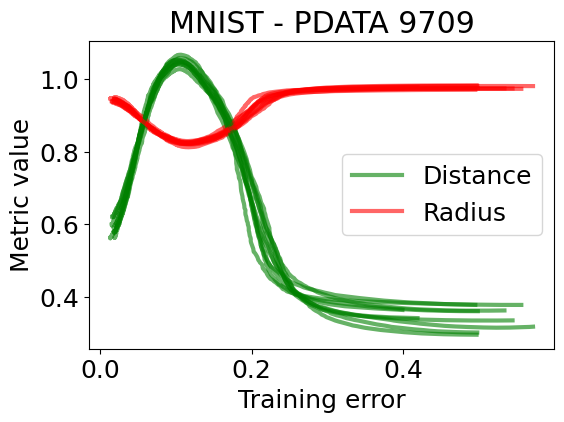

  Processing with PDATA: 6472
  PDATA 6472, Run 40, max distance: 1.0739 at epoch 149
 Number of misclassified examples at max distance: 636
 Number of misclassified examples at max distance: 703
  PDATA 6472, Run 41, max distance: 1.0662 at epoch 179
 Number of misclassified examples at max distance: 628
 Number of misclassified examples at max distance: 705
  PDATA 6472, Run 42, max distance: 1.0459 at epoch 152
 Number of misclassified examples at max distance: 622
 Number of misclassified examples at max distance: 660
  PDATA 6472, Run 43, max distance: 1.0709 at epoch 156
 Number of misclassified examples at max distance: 610
 Number of misclassified examples at max distance: 694
  PDATA 6472, Run 44, max distance: 1.0508 at epoch 154
 Number of misclassified examples at max distance: 626
 Number of misclassified examples at max distance: 684
  PDATA 6472, Run 45, max distance: 1.0548 at epoch 158
 Number of misclassified examples at max distance: 630
 Number of misclassified exam

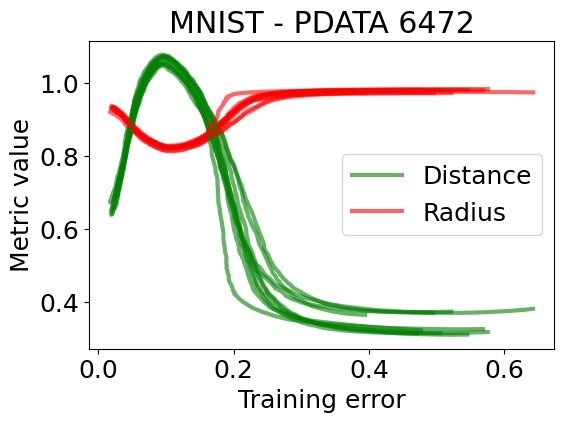

  Processing with PDATA: 4315
  PDATA 4315, Run 50, max distance: 1.0686 at epoch 147
 Number of misclassified examples at max distance: 392
 Number of misclassified examples at max distance: 440
  PDATA 4315, Run 51, max distance: 1.0965 at epoch 154
 Number of misclassified examples at max distance: 381
 Number of misclassified examples at max distance: 430
  PDATA 4315, Run 52, max distance: 1.0589 at epoch 122
 Number of misclassified examples at max distance: 386
 Number of misclassified examples at max distance: 455
  PDATA 4315, Run 53, max distance: 1.0906 at epoch 169
 Number of misclassified examples at max distance: 379
 Number of misclassified examples at max distance: 444
  PDATA 4315, Run 54, max distance: 1.0817 at epoch 161
 Number of misclassified examples at max distance: 384
 Number of misclassified examples at max distance: 455
  PDATA 4315, Run 55, max distance: 1.0460 at epoch 151
 Number of misclassified examples at max distance: 396
 Number of misclassified exam

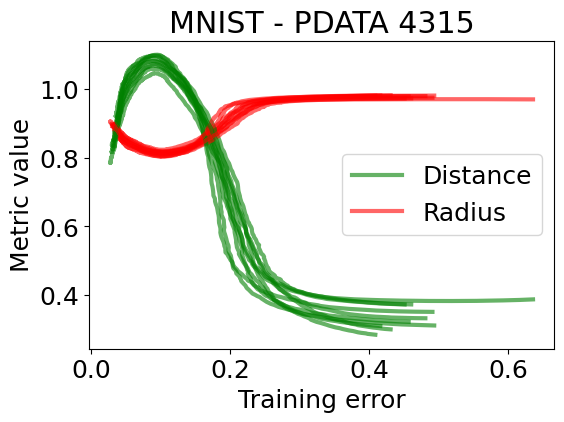


Processing with Width: 80
  Processing with PDATA: 32768
  PDATA 32768, Run 60, max distance: 0.8601 at epoch 129
 Number of misclassified examples at max distance: 3890
 Number of misclassified examples at max distance: 4219
  PDATA 32768, Run 61, max distance: 0.8593 at epoch 144
 Number of misclassified examples at max distance: 3904
 Number of misclassified examples at max distance: 4372
  PDATA 32768, Run 62, max distance: 0.8823 at epoch 149
 Number of misclassified examples at max distance: 3918
 Number of misclassified examples at max distance: 4260
  PDATA 32768, Run 63, max distance: 0.8820 at epoch 139
 Number of misclassified examples at max distance: 3904
 Number of misclassified examples at max distance: 4150
  PDATA 32768, Run 64, max distance: 0.8757 at epoch 156
 Number of misclassified examples at max distance: 3955
 Number of misclassified examples at max distance: 4233
  PDATA 32768, Run 65, max distance: 0.8790 at epoch 149
 Number of misclassified examples at max

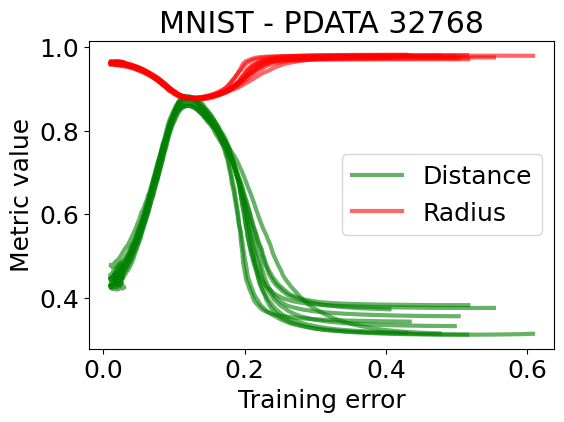

  Processing with PDATA: 21845
  PDATA 21845, Run 70, max distance: 0.8681 at epoch 127
 Number of misclassified examples at max distance: 2566
 Number of misclassified examples at max distance: 2793
  PDATA 21845, Run 71, max distance: 0.8835 at epoch 164
 Number of misclassified examples at max distance: 2544
 Number of misclassified examples at max distance: 2736
  PDATA 21845, Run 72, max distance: 0.8677 at epoch 133
 Number of misclassified examples at max distance: 2556
 Number of misclassified examples at max distance: 2819
  PDATA 21845, Run 73, max distance: 0.8765 at epoch 144
 Number of misclassified examples at max distance: 2573
 Number of misclassified examples at max distance: 2818
  PDATA 21845, Run 74, max distance: 0.8708 at epoch 139
 Number of misclassified examples at max distance: 2562
 Number of misclassified examples at max distance: 2819
  PDATA 21845, Run 75, max distance: 0.8819 at epoch 141
 Number of misclassified examples at max distance: 2603
 Number of 

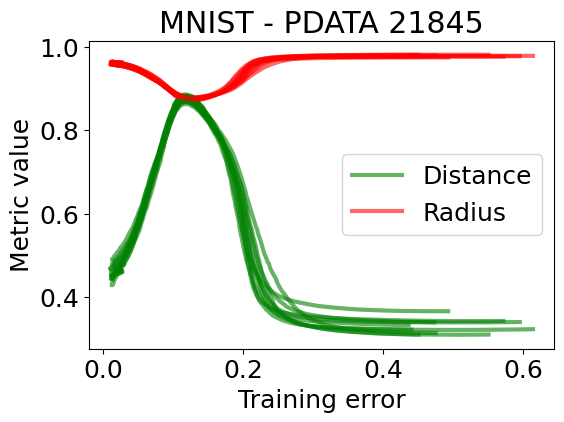

  Processing with PDATA: 14563
  PDATA 14563, Run 80, max distance: 0.8875 at epoch 137
 Number of misclassified examples at max distance: 1636
 Number of misclassified examples at max distance: 1815
  PDATA 14563, Run 81, max distance: 0.8776 at epoch 149
 Number of misclassified examples at max distance: 1674
 Number of misclassified examples at max distance: 1853
  PDATA 14563, Run 82, max distance: 0.9025 at epoch 166
 Number of misclassified examples at max distance: 1630
 Number of misclassified examples at max distance: 1824
  PDATA 14563, Run 83, max distance: 0.8839 at epoch 161
 Number of misclassified examples at max distance: 1661
 Number of misclassified examples at max distance: 1856
  PDATA 14563, Run 84, max distance: 0.8682 at epoch 139
 Number of misclassified examples at max distance: 1657
 Number of misclassified examples at max distance: 1839
  PDATA 14563, Run 85, max distance: 0.8827 at epoch 126
 Number of misclassified examples at max distance: 1635
 Number of 

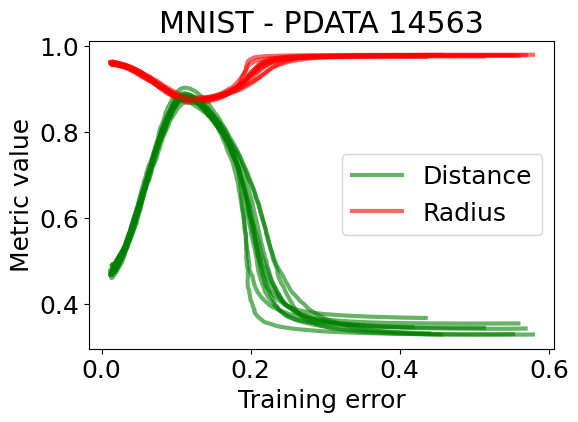

  Processing with PDATA: 9709
  PDATA 9709, Run 90, max distance: 0.8806 at epoch 120
 Number of misclassified examples at max distance: 1069
 Number of misclassified examples at max distance: 1173
  PDATA 9709, Run 91, max distance: 0.8899 at epoch 144
 Number of misclassified examples at max distance: 1073
 Number of misclassified examples at max distance: 1228
  PDATA 9709, Run 92, max distance: 0.8813 at epoch 135
 Number of misclassified examples at max distance: 1081
 Number of misclassified examples at max distance: 1166
  PDATA 9709, Run 93, max distance: 0.8887 at epoch 156
 Number of misclassified examples at max distance: 1077
 Number of misclassified examples at max distance: 1162
  PDATA 9709, Run 94, max distance: 0.9022 at epoch 165
 Number of misclassified examples at max distance: 1052
 Number of misclassified examples at max distance: 1188
  PDATA 9709, Run 95, max distance: 0.8933 at epoch 141
 Number of misclassified examples at max distance: 1031
 Number of misclas

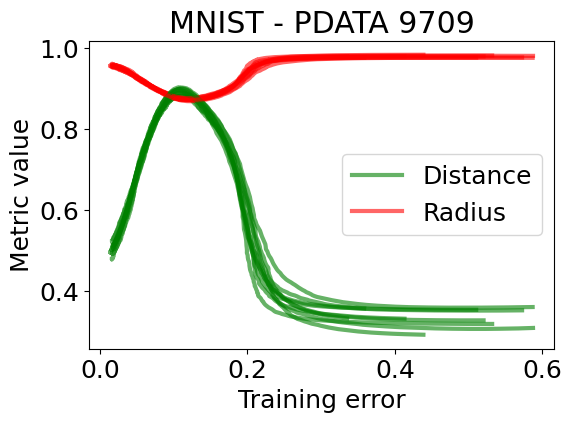

  Processing with PDATA: 6472
  PDATA 6472, Run 100, max distance: 0.9155 at epoch 147
 Number of misclassified examples at max distance: 644
 Number of misclassified examples at max distance: 731
  PDATA 6472, Run 101, max distance: 0.8914 at epoch 139
 Number of misclassified examples at max distance: 672
 Number of misclassified examples at max distance: 750
  PDATA 6472, Run 102, max distance: 0.8951 at epoch 121
 Number of misclassified examples at max distance: 657
 Number of misclassified examples at max distance: 709
  PDATA 6472, Run 103, max distance: 0.8951 at epoch 122
 Number of misclassified examples at max distance: 651
 Number of misclassified examples at max distance: 715
  PDATA 6472, Run 104, max distance: 0.9058 at epoch 123
 Number of misclassified examples at max distance: 638
 Number of misclassified examples at max distance: 735
  PDATA 6472, Run 105, max distance: 0.9035 at epoch 136
 Number of misclassified examples at max distance: 645
 Number of misclassifie

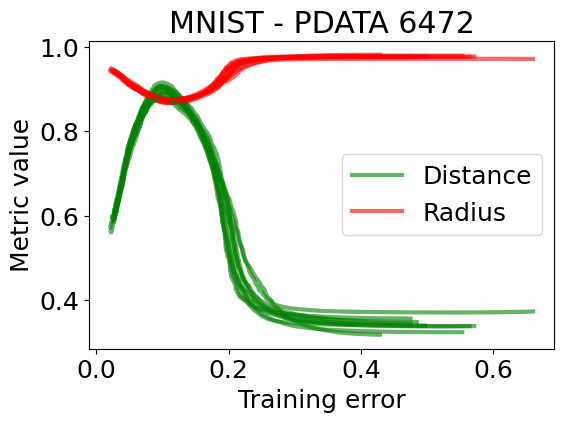

  Processing with PDATA: 4315
  PDATA 4315, Run 110, max distance: 0.9149 at epoch 133
 Number of misclassified examples at max distance: 409
 Number of misclassified examples at max distance: 462
  PDATA 4315, Run 111, max distance: 0.9050 at epoch 149
 Number of misclassified examples at max distance: 410
 Number of misclassified examples at max distance: 446
  PDATA 4315, Run 112, max distance: 0.9106 at epoch 136
 Number of misclassified examples at max distance: 395
 Number of misclassified examples at max distance: 462
  PDATA 4315, Run 113, max distance: 0.9075 at epoch 132
 Number of misclassified examples at max distance: 408
 Number of misclassified examples at max distance: 445
  PDATA 4315, Run 114, max distance: 0.9129 at epoch 120
 Number of misclassified examples at max distance: 396
 Number of misclassified examples at max distance: 452
  PDATA 4315, Run 115, max distance: 0.9260 at epoch 138
 Number of misclassified examples at max distance: 394
 Number of misclassifie

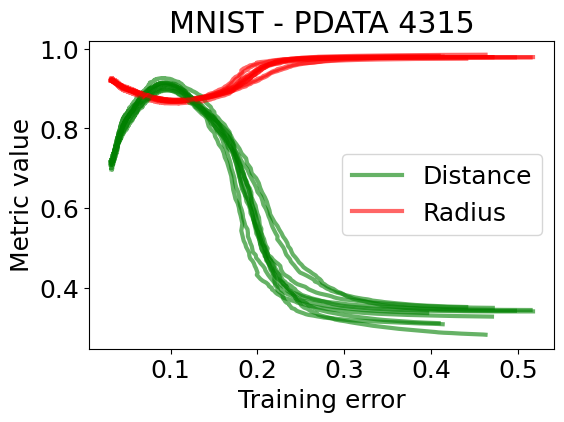

In [ ]:

LATENT = 1
RUNS = 10
EPOCHS = 4000
DEPTH=9
LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD
WIDTHS = ( 40, 80) #three different values of widths

ORIGINAL_PDATA = 32768
n=6
results_non_lin = []
misclassified_examples_all_runs = []
misclassified_data_min_distance_list = []

multiplier = len(WIDTHS)

max_distance_info = []
straggler_info_non_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]
DEPTHS = (3, 5, 9  ) #depths of the net

header = "PDATA\tRun\tepoch of max distance\ttrain error of max distance\tmax distance\tepoch of min radius\ttrain error of min radius\tmin radius\tWidth\tDepth" # Added Depth to header
straggler_header_non_lin = "PDATA\tRun\tEpoch_max_distance\tNum_Stragglers_max_distance\tRatio_max_distance\tEpoch_min_radius\tNum_Stragglers_min_radius\tRatio_min_radius\tWidth\tDepth" # Added Depth to header

with open(f"/content/max_distance_info_non_lin_tot_{DATASET_NAME}.txt", "w") as f:
    f.write(header + "\n")


with open(f"/content/straggler_info_non_lin_tot_{DATASET_NAME}.txt", "w") as f:
    f.write(straggler_header_non_lin + "\n")

global_run_counter = 0

for DEPTH in DEPTHS:
    print(f"\nProcessing with Depth: {DEPTH}")
    for width in WIDTHS:
        print(f"\nProcessing with Width: {width}")

        for i in range(n):
            PDATA = int(ORIGINAL_PDATA/(1.5**i))
            DATA_BLOCK = 1

            print(f"  Processing with PDATA: {PDATA}")

            data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

            current_pdata_size = data.shape[0]

            input_size = data.shape[2] * data.shape[3]

            m_array = m_array_input(data, labels)

            results_non_lin_pdata = []
            misclassified_examples_all_runs_pdata = []
            max_distance_info_pdata = []
            straggler_info_non_lin_pdata = []

            for run in range(RUNS):

                net = NN_KHL_classification(input_size, DEPTH, width, LATENT).to(device)

                optimizer = OPTIMIZER(net.parameters(), lr=LEARNING_RATE)
                criterion = torch.nn.CrossEntropyLoss()

                results_run = []
                misclassified_examples_run = []

                for epoch in range(EPOCHS):
                    optimizer.zero_grad()
                    outputs = net(data)
                    loss = criterion(outputs, labels)

                    loss.backward()
                    optimizer.step()

                    train_preds = torch.argmax(outputs, dim=1)
                    train_error = torch.sum(train_preds != labels).item() / data.shape[0]

                    test_preds = torch.argmax(net(test_data), dim=1)
                    test_error = torch.sum(test_preds != test_labels).item() / test_data.shape[0]

                    radii, distance = net.radii(data, labels)
                    results_run.append([
                        epoch,
                        train_error,
                        loss.item(),
                        radii[0].item(),
                        radii[1].item(),
                        distance,
                        width
                    ])

                    misclassified_mask = train_preds != labels
                    misclassified_examples_run.append(misclassified_mask.cpu())

                results_non_lin_pdata.append(results_run)
                misclassified_examples_all_runs_pdata.append(misclassified_examples_run)

            arr_res_non_lin_pdata = np.array(results_non_lin_pdata)
            plt.figure(figsize=(6, 4))

            for kk in range(len(arr_res_non_lin_pdata)):

                distances_for_run = arr_res_non_lin_pdata[kk, :, 5]
                max_distance_epoch_index = np.argmax(distances_for_run)
                max_distance_value = distances_for_run[max_distance_epoch_index]
                max_distance_epoch = int(arr_res_non_lin_pdata[kk, max_distance_epoch_index, 0])
                train_error_max_distance = arr_res_non_lin_pdata[kk, max_distance_epoch_index, 1]

                print(f"  PDATA {PDATA}, Run {global_run_counter}, max distance: {max_distance_value:.4f} at epoch {max_distance_epoch}")


                misclassified_mask_max_distance = misclassified_examples_all_runs_pdata[kk][max_distance_epoch_index].numpy()
                num_stragglers_max_distance = np.sum(misclassified_mask_max_distance)
                ratio_max_distance = num_stragglers_max_distance / current_pdata_size if current_pdata_size > 0 else 0

                print(f" Number of misclassified examples at max distance: {num_stragglers_max_distance}")


                epochs = arr_res_non_lin_pdata[kk, :, 0]
                radius_for_run = arr_res_non_lin_pdata[kk, :, 4]
                mask = epochs != 0
                filtered_epochs = epochs[mask]
                filtered_radii = radius_for_run[mask]

                min_radius_epoch_index_filtered = np.argmin(filtered_radii)
                min_radius_epoch = int(filtered_epochs[min_radius_epoch_index_filtered])
                min_radius_value = float(filtered_radii[min_radius_epoch_index_filtered])
                train_error_min_radius = float(arr_res_non_lin_pdata[kk][mask][min_radius_epoch_index_filtered][1])
                original_index_radius = np.where(epochs == min_radius_epoch)[0][0]


                misclassified_mask_radius = misclassified_examples_all_runs_pdata[kk][original_index_radius].numpy()
                num_stragglers_min_radius = np.sum(misclassified_mask_radius)
                ratio_min_radius = num_stragglers_min_radius / current_pdata_size if current_pdata_size > 0 else 0
                print
                print(f" Number of misclassified examples at max distance: {num_stragglers_min_radius}")

                max_distance_info_pdata.append([PDATA, global_run_counter, max_distance_epoch, train_error_max_distance, max_distance_value, min_radius_epoch, train_error_min_radius, min_radius_value, width, DEPTH])
                straggler_info_non_lin_pdata.append([PDATA, global_run_counter, max_distance_epoch, num_stragglers_max_distance, ratio_max_distance, min_radius_epoch, num_stragglers_min_radius, ratio_min_radius, width, DEPTH])
                global_run_counter += 1


                plt.plot(arr_res_non_lin_pdata[kk, :, 1], arr_res_non_lin_pdata[kk, :, 5], color="green", linewidth=3,alpha=0.6,label="distance")
                plt.plot(arr_res_non_lin_pdata[kk, :, 1], arr_res_non_lin_pdata[kk, :, 4], color="red",linewidth=3,alpha=0.6, label="radius")

            plt.xlabel('Training error')
            plt.ylabel('Metric value')
            plt.title(f"{DATASET_NAME} - PDATA {PDATA}")

            legend_elements = [
                Line2D([0], [0], color='green', linestyle='-',linewidth=3,alpha=0.6, label='Distance'),
                Line2D([0], [0], color='red', linestyle='-', linewidth=3,alpha=0.6,label='Radius'),
            ]
            plt.legend(handles=legend_elements)
            plt.savefig(f"{DATASET_NAME}_non_lin_pdata_{PDATA}_width_{width}_depth_{DEPTH}.pdf", bbox_inches='tight')
            plt.show()

            max_distance_info_matrix_pdata = np.array(max_distance_info_pdata)
            with open(f"/content/max_distance_info_non_lin_tot_{DATASET_NAME}.txt", "a") as f:
                 np.savetxt(f, max_distance_info_matrix_pdata, delimiter='\t', fmt='%d\t%d\t%d\t%.4f\t%.4f\t%d\t%.4f\t%.4f\t%d\t%d', comments='')
            max_distance_info_pdata = []


            straggler_info_non_lin_matrix_pdata = np.array(straggler_info_non_lin_pdata)
            with open(f"/content/straggler_info_non_lin_tot_{DATASET_NAME}.txt", "a") as f:
                np.savetxt(f, straggler_info_non_lin_matrix_pdata, delimiter='\t', fmt='%d\t%d\t%d\t%d\t%.4f\t%d\t%d\t%.4f\t%d\t%d', comments='')
            straggler_info_non_lin_pdata = []


Processing with Depth: 2
 File not found for dataset CIFAR10: /content/straggler_info_non_lin_tot_CIFAR10.txt
 File not found for dataset KMNIST: /content/straggler_info_non_lin_tot_KMNIST.txt
 File not found for dataset FashionMNIST: /content/straggler_info_non_lin_tot_FashionMNIST.txt
→ Depth values found in MNIST: [2. 4. 8.]

--- Dataset: MNIST, Width: 10, Depth: 2 ---

--- Dataset: MNIST, Width: 20, Depth: 2 ---

--- Dataset: MNIST, Width: 40, Depth: 2 ---

--- Dataset: MNIST, Width: 80, Depth: 2 ---

Processing with Depth: 4
 File not found for dataset CIFAR10: /content/straggler_info_non_lin_tot_CIFAR10.txt
 File not found for dataset KMNIST: /content/straggler_info_non_lin_tot_KMNIST.txt
 File not found for dataset FashionMNIST: /content/straggler_info_non_lin_tot_FashionMNIST.txt
→ Depth values found in MNIST: [2. 4. 8.]

--- Dataset: MNIST, Width: 10, Depth: 4 ---

--- Dataset: MNIST, Width: 20, Depth: 4 ---

--- Dataset: MNIST, Width: 40, Depth: 4 ---

--- Dataset: MNIST, Wi

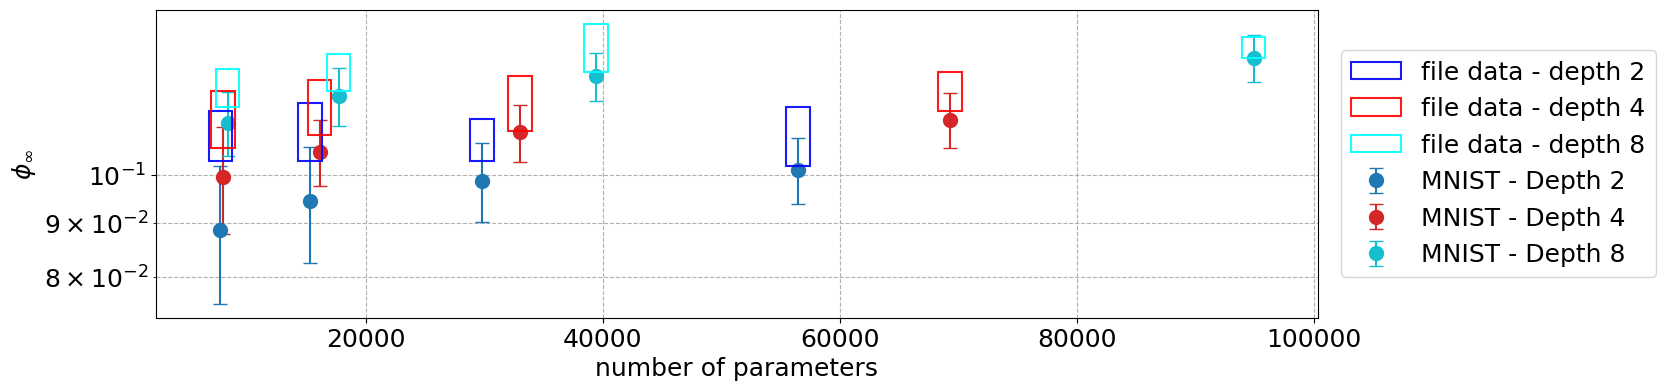

In [ ]:
file_paths = {
    'CIFAR10': '/content/straggler_info_non_lin_tot_CIFAR10.txt',
    'KMNIST': '/content/straggler_info_non_lin_tot_KMNIST.txt',
    'FashionMNIST': '/content/straggler_info_non_lin_tot_FashionMNIST.txt',
    'MNIST': '/content/straggler_info_non_lin_tot_MNIST_finale.txt'
}

DEPTHS = [2, 4, 8]
plot_data = []
colors = ['tab:blue','tab:red', 'tab:cyan']



data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

current_pdata_size = data.shape[0]

input_size = data.shape[2] * data.shape[3]

# main loop
for DEPTH in DEPTHS:
    print(f"\nProcessing with Depth: {DEPTH}")

    for i, (dataset_name, file_path) in enumerate(file_paths.items()):
        try:

            df = pd.read_csv(file_path, sep=r'\s+', header=None, skiprows=1)

            straggler_data = pd.DataFrame(df).apply(pd.to_numeric, errors='coerce').dropna().values

            if straggler_data.shape[1] < 10:
                print(f" Dataset {dataset_name} has only {straggler_data.shape[1]} columns. Skipping.")
                continue


            col_depth = pd.to_numeric(pd.Series(straggler_data[:, 9]), errors='coerce')
            print(f"→ Depth values found in {dataset_name}: {np.unique(col_depth.dropna())}")


            mask_depth = np.isclose(col_depth, DEPTH, atol=1e-6)
            data_for_depth = straggler_data[mask_depth]

            if data_for_depth.size == 0:
                print(f"No data found for DEPTH={DEPTH} in dataset {dataset_name}.")
                continue

            # fit for each width

            unique_widths = np.unique(data_for_depth[:, 8])

            for width in unique_widths:
                data_for_width = data_for_depth[data_for_depth[:, 8] == width]
                unique_runs_for_width = np.unique(data_for_width[:, 1])
                fitted_params_per_run = []

                current_depth = data_for_width[0, 9]
                print(f"\n--- Dataset: {dataset_name}, Width: {int(width)}, Depth: {int(current_depth)} ---")

                for local_run_index, run in enumerate(unique_runs_for_width):
                    run_data = data_for_width[data_for_width[:, 1] == run]
                    x_data_run = run_data[:, 0]
                    y_data_run = run_data[:, 7]

                    if len(x_data_run) > 0:
                        x_data_tensor_run = torch.tensor(x_data_run, dtype=torch.float32)
                        y_data_tensor_run = torch.tensor(y_data_run, dtype=torch.float32)

                        a_init = max(y_data_run.max(), 1e-6) if y_data_run.size > 0 else 1e-6
                        a = torch.tensor([a_init], requires_grad=True, dtype=torch.float32)
                        logb = torch.tensor([6.], requires_grad=True, dtype=torch.float32) if x_data_run.size > 0 and x_data_run.max() > 0 else torch.tensor([np.log(1000.0)], requires_grad=True, dtype=torch.float32)
                        c = torch.tensor([1.0], requires_grad=True, dtype=torch.float32)

                        optimizer_run = optim.Adam(
                            [{'params': [a, c], 'lr': 0.01}, {'params': [logb], 'lr': 0.001}]
                        )
                        loss_fn_run = nn.MSELoss()

                        def closure_run():
                            optimizer_run.zero_grad()
                            y_pred_run = power_law(x_data_tensor_run, a, logb, c)
                            loss_run = loss_fn_run(y_pred_run, y_data_tensor_run)
                            loss_run.backward()
                            return loss_run

                        prev_loss = float('inf')
                        try:
                            for j in range(10000):
                                loss_val_tensor = optimizer_run.step(closure_run)
                                loss_val = (
                                    float(loss_val_tensor.item())
                                    if isinstance(loss_val_tensor, torch.Tensor)
                                    else float(loss_val_tensor)
                                )
                                if j > 100 and abs(prev_loss - loss_val) < 1e-7:
                                    break
                                prev_loss = loss_val
                        except Exception as fit_err:
                            print(f"  Error during fitting for Width {width}, Run {local_run_index}: {fit_err}. Skipping.")
                            continue

                        if torch.isfinite(a) and torch.isfinite(logb) and torch.isfinite(c):
                            fitted_params_per_run.append({'a': a.item(), 'logb': logb.item(), 'c': c.item()})
                        else:
                            print(f" Fitted parameters not finite for Width {width}, Run {local_run_index}. Skipping.")
                    else:
                        print(f"  Not enough data points ({len(x_data_run)}) for fitting. Skipping fit.")

                if fitted_params_per_run:
                    params_a = [p['a'] for p in fitted_params_per_run]
                    mean_a = np.mean(params_a)
                    std_a = np.std(params_a)

                    plot_data.append({
                        'x': width *input_size + (width**2)*(DEPTH-3)+2*width,
                        'y': mean_a,
                        'yerr': std_a,
                        'depth': DEPTH,
                        'dataset': dataset_name
                    })

        except FileNotFoundError:
            print(f" File not found for dataset {dataset_name}: {file_path}")
        except Exception as e:
            print(f" An error occurred processing dataset {dataset_name}: {e}")


# plot

plt.figure(figsize=(15, 4))
unique_depths_in_plot = sorted(list(set([item['depth'] for item in plot_data])))
unique_datasets_in_plot = sorted(list(set([item['dataset'] for item in plot_data])))
color_map = {depth: colors[i % len(colors)] for i, depth in enumerate(unique_depths_in_plot)}

for dataset_name in unique_datasets_in_plot:
    for depth_val in unique_depths_in_plot:
        subset_data = [item for item in plot_data if item['depth'] == depth_val and item['dataset'] == dataset_name]
        if subset_data:
            x_vals_subset = [item['x'] for item in subset_data]
            y_vals_subset = [item['y'] for item in subset_data]
            y_errs_subset = [item['yerr'] for item in subset_data]

            plt.errorbar(
                x_vals_subset, y_vals_subset, yerr=y_errs_subset,
                fmt='o', capsize=5, color=color_map[depth_val],   markersize=10,
                label=f'{dataset_name} - Depth {int(depth_val)}'
            )

plt.xlabel(r'number of parameters')
plt.ylabel(r'$\phi_{\infty}$')
plt.grid(True, which="both", linestyle='--')



# add data from paper

FILE = '/content/dati_prof_phi_inf.txt'

df_extra = pd.read_csv(FILE, sep=r'\s+', header=None, skiprows=1)
df_extra.columns = ['depth', 'width', 'mean', 'std']


col_depth = {2: 'blue', 4: 'red', 8: 'cyan'}
ax = plt.gca()

#_ to indicate that we do not intend to use the first element of the pair
#returned by iterrows() (row index)
for _, row in df_extra.iterrows():
    depth_val = int(row['depth'])
    width_val = float(row['width'])
    mean_val = float(row['mean'])
    std_val = float(row['std'])
    height = 2 * std_val
    x_center = width_val *input_size + (width_val**2)*(depth_val-3)+2*width_val
    width_rect = 2000
    linewidth = 6
    rect = patches.Rectangle(
        (x_center - width_rect / 2, mean_val - std_val),
        width_rect, height,
        linewidth=1.5,
        edgecolor=col_depth.get(depth_val, 'gray'),
        facecolor='none',
        alpha=0.9,
        label=f"file data - depth {depth_val}",
        zorder=5
    )
    ax.add_patch(rect)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(
by_label.values(),
by_label.keys(),
loc='center left',
bbox_to_anchor=(1.02, 0.5),
borderaxespad=0.0,
frameon=True
)


plt.yscale('log')
plt.savefig("fitted_a_vs_width_depth_plus_one_all_datasets.pdf", bbox_inches='tight')
plt.show()

## Linear model

In this cell,
$\phi (P)$ is fitted with a power law to obtain the values of
$\phi_\infty$ as a function of the network's width and depth, in the case of a linearized network.

In [ ]:
LATENT = 1
RUNS = 10
EPOCHS = 6000

LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD


WIDTHS = ( 10, 20, 40, 80)

ORIGINAL_PDATA = 32768
n=6

results_lin = []
misclassified_examples_all_runs = []
misclassified_data_min_distance_list = []

multiplier = len(WIDTHS)

max_distance_info_lin = []
straggler_info_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]
DEPTHS = (2, 4, 8)

header_lin = "PDATA\tRun\tepoch of max distance\ttrain error of max distance\tmax distance\tepoch of min radius\ttrain error of min radius\tmin radius\tWidth\tDepth"
straggler_header_lin = "PDATA\tRun\tEpoch_max_distance\tNum_Stragglers_max_distance\tRatio_max_distance\tEpoch_min_radius\tNum_Stragglers_min_radius\tRatio_min_radius\tWidth\tDepth"

with open(f"/content/max_distance_info_lin_tot_{DATASET_NAME}.txt", "w") as f:
    f.write(header_lin + "\n")


with open(f"/content/straggler_info_lin_tot_{DATASET_NAME}.txt", "w") as f:
    f.write(straggler_header_lin + "\n")

global_run_counter = 0

for DEPTH in DEPTHS:
    print(f"\nProcessing with Depth: {DEPTH} (Linearized)")
    for width in WIDTHS:
        print(f"\nProcessing with Width: {width} (Linearized)")

        for i in range(n):
            PDATA = int(ORIGINAL_PDATA/(1.5**(i+1)))
            DATA_BLOCK = 1

            print(f"  Processing with PDATA: {PDATA}")

            data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

            current_pdata_size = data.shape[0]

            if current_pdata_size != PDATA:
                 print(f"  Warning: Loaded data size ({current_pdata_size}) does not match specified PDATA ({PDATA}). This might occur if PDATA exceeds dataset size.")


            input_size = data.shape[2] * data.shape[3]

            data_normalized = data_normalization(data.to(device), labels.to(device))
            labels_float = labels.to(device).float()
            m_array = m_array_input(data_normalized, labels.to(device))


            results_lin_pdata = []
            misclassified_examples_all_runs_pdata = []
            max_distance_info_pdata_lin = []
            straggler_info_lin_pdata = []


            for run in range(RUNS):

                net_init = NN_KHL_logistic(input_size, DEPTH, width, LATENT).to(device)
                net_at_init = NN_KHL_logistic(input_size, DEPTH, width, LATENT).to(device)
                net_at_init.load_state_dict(net_init.state_dict())

                theta0_dict = dict(net_init.named_parameters())
                theta0_flat = nn.utils.parameters_to_vector(list(net_init.parameters())).detach()


                features = compute_tangent_features_batch(net_init, theta0_dict, data_normalized)


                linearized_net = linearized_NN(features.shape[1]).to(device)

                optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)

                criterion = nn.MSELoss()


                results_run = []
                misclassified_examples_run = []

                for epoch in range(EPOCHS):
                    optimizer.zero_grad()

                    with torch.no_grad():
                         net_base_output = net_at_init(data_normalized)

                    pred_lin = linearized_net(features) + net_base_output


                    loss = criterion(pred_lin, labels_float)


                    loss.backward()
                    optimizer.step()


                    train_preds_lin = (pred_lin >= 0.5).float()
                    train_error = torch.sum(torch.abs(train_preds_lin - labels_float)).item() / data_normalized.shape[0]


                    net_full = NN_KHL_logistic(input_size, DEPTH, width, LATENT).to(device)
                    new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
                    nn.utils.vector_to_parameters(new_weights, net_full.parameters())

                    with torch.no_grad():
                        radii, distance = net_full.radii(data_normalized, labels.to(device))


                    results_run.append([
                        epoch,
                        train_error,
                        loss.item(),
                        radii[0].item(),
                        radii[1].item(),
                        distance,
                        width,
                        DEPTH
                    ])

                    misclassified_mask = train_preds_lin != labels.to(device)
                    misclassified_examples_run.append(misclassified_mask.cpu())

                results_lin_pdata.append(results_run)
                misclassified_examples_all_runs_pdata.append(misclassified_examples_run)

            arr_res_lin_pdata = np.array(results_lin_pdata)
            plt.figure(figsize=(6, 4))

            for kk in range(len(arr_res_lin_pdata)):

                distances_for_run = arr_res_lin_pdata[kk, :, 5]
                max_distance_epoch_index = np.argmax(distances_for_run)
                max_distance_value = distances_for_run[max_distance_epoch_index]
                max_distance_epoch = int(arr_res_lin_pdata[kk, max_distance_epoch_index, 0])
                train_error_max_distance = arr_res_lin_pdata[kk, max_distance_epoch_index, 1]

                print(f"  PDATA {PDATA}, Run {global_run_counter} max distance {max_distance_value:.4f} at epoch {max_distance_epoch}")


                misclassified_mask_max_distance = misclassified_examples_all_runs_pdata[kk][max_distance_epoch_index].numpy()
                num_stragglers_max_distance = np.sum(misclassified_mask_max_distance)
                ratio_max_distance = num_stragglers_max_distance / current_pdata_size if current_pdata_size > 0 else 0

                print(f" Number of stragglers at epoch of max distance: {num_stragglers_max_distance}")


                epochs = arr_res_lin_pdata[kk, :, 0]
                radius_for_run = arr_res_lin_pdata[kk, :, 4]
                mask = epochs != 0
                filtered_epochs = epochs[mask]
                filtered_radii = radius_for_run[mask]

                min_radius_epoch_index_filtered = np.argmin(filtered_radii)
                min_radius_epoch = int(filtered_epochs[min_radius_epoch_index_filtered])
                min_radius_value = float(filtered_radii[min_radius_epoch_index_filtered])
                train_error_min_radius = float(arr_res_lin_pdata[kk][mask][min_radius_epoch_index_filtered][1])
                original_index_radius = np.where(epochs == min_radius_epoch)[0][0]


                misclassified_mask_radius = misclassified_examples_all_runs_pdata[kk][original_index_radius].numpy()
                num_stragglers_min_radius = np.sum(misclassified_mask_radius)
                ratio_min_radius = num_stragglers_min_radius / current_pdata_size if current_pdata_size > 0 else 0
                print
                print(f"  Number of stragglers at epoch of min radius {num_stragglers_min_radius}")

                max_distance_info_pdata_lin.append([PDATA, global_run_counter, max_distance_epoch, train_error_max_distance, max_distance_value, min_radius_epoch, train_error_min_radius, min_radius_value, width, DEPTH])
                straggler_info_lin_pdata.append([PDATA, global_run_counter, max_distance_epoch, num_stragglers_max_distance, ratio_max_distance, min_radius_epoch, num_stragglers_min_radius, ratio_min_radius, width, DEPTH])
                global_run_counter += 1


                plt.plot(arr_res_lin_pdata[kk, :, 1], arr_res_lin_pdata[kk, :, 5], color="blue", linewidth=3,alpha=0.6,label="distance")
                plt.plot(arr_res_lin_pdata[kk, :, 1], arr_res_lin_pdata[kk, :, 4], color="orange",linewidth=3,alpha=0.6, label="radius")

            plt.xlabel('Training error')
            plt.ylabel('Metric value')
            plt.title(f"{DATASET_NAME} - PDATA {PDATA} (Linearized)")

            legend_elements = [
                Line2D([0], [0], color='blue', linestyle='-',linewidth=3,alpha=0.6, label='Distance (Linearized)'),
                Line2D([0], [0], color='orange', linestyle='-', linewidth=3,alpha=0.6,label='Radius (Linearized)'),
            ]
            plt.legend(handles=legend_elements)
            plt.savefig(f"{DATASET_NAME}_lin_pdata_{PDATA}_width_{width}_depth_{DEPTH}.pdf", bbox_inches='tight')
            plt.show()

            max_distance_info_matrix_pdata_lin = np.array(max_distance_info_pdata_lin)
            with open(f"/content/max_distance_info_lin_tot_{DATASET_NAME}.txt", "a") as f:
                 np.savetxt(f, max_distance_info_matrix_pdata_lin, delimiter='\t', fmt='%d\t%d\t%d\t%.4f\t%.4f\t%d\t%.4f\t%.4f\t%d\t%d', comments='')
            max_distance_info_pdata_lin = []


            straggler_info_lin_matrix_pdata = np.array(straggler_info_lin_pdata)
            with open(f"/content/straggler_info_lin_tot_{DATASET_NAME}.txt", "a") as f:
                np.savetxt(f, straggler_info_lin_matrix_pdata, delimiter='\t', fmt='%d\t%d\t%d\t%d\t%.4f\t%d\t%d\t%.4f\t%d\t%d', comments='')
            straggler_info_lin_pdata = []

## Comparison between deep network and linearized network results



In this cell, the estimates of $\phi_\infty$
 obtained with the standard feedforward network are compared with those obtained using the linearized model.

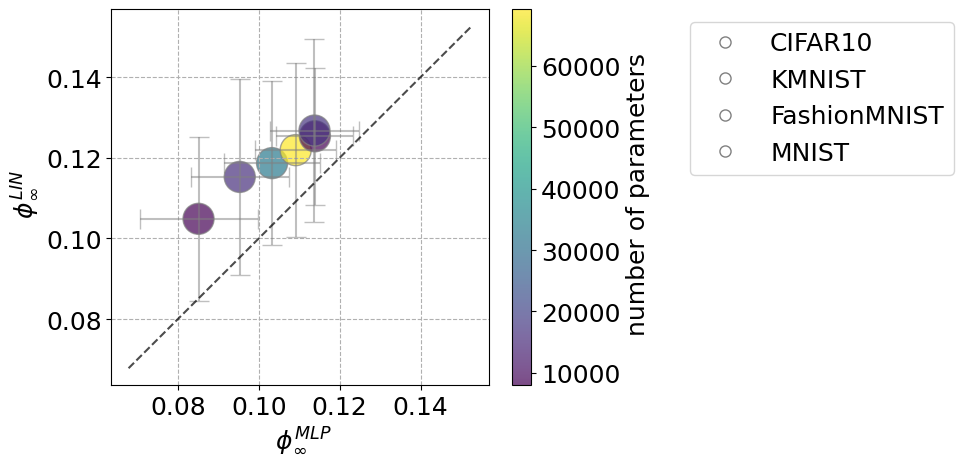


=== All Fitted Parameters ===
Fitted parameter 'a':
  MNIST Non-Linearized: a = 0.1174 ± 0.0071
  MNIST Linearized: a = 0.1441 ± 0.0323


In [17]:


def power_law(x, a, logb, c):
    x = torch.as_tensor(x, dtype=torch.float32)
    a = torch.as_tensor(a, dtype=torch.float32)
    logb = torch.as_tensor(logb, dtype=torch.float32)
    c = torch.as_tensor(c, dtype=torch.float32)
    b = torch.exp(logb)
    x_safe = torch.where(x == 0, torch.tensor(1e-9, dtype=torch.float32), x)
    return a * (1 - (x_safe / b)**(-c))

def plot_straggler_ratio_fit_lin_vs_deep(file_paths_non_lin, file_paths_lin, output_filename, colors, dataset_labels, power_law_func):

    all_pdata_non_lin = {}
    all_mean_ratios_non_lin = {}
    all_std_ratios_non_lin = {}
    all_fitted_params_non_lin = {}
    all_widths_non_lin = {}
    all_depths_non_lin = {}


    all_pdata_lin = {}
    all_mean_ratios_lin = {}
    all_std_ratios_lin = {}
    all_fitted_params_lin = {}
    all_widths_lin = {}
    all_depths_lin = {}



    for i, (dataset_name, file_path) in enumerate(file_paths_non_lin.items()):
        try:
            straggler_data = np.loadtxt(file_path, skiprows=1)
            pdata_values = straggler_data[:, 0]
            ratio_min_radius = straggler_data[:, 7]
            run_numbers = straggler_data[:, 1]
            width_values = straggler_data[:, 8]
            depth_values = straggler_data[:, 9]


            unique_pdata = np.unique(pdata_values)
            mean_y = []
            std_y = []
            widths_for_pdata = []
            depths_for_pdata = []


            for pdata in unique_pdata:
                indices_for_pdata = np.where(pdata_values == pdata)[0]
                y_values_for_pdata = ratio_min_radius[indices_for_pdata]
                mean_y.append(np.mean(y_values_for_pdata))
                std_y.append(np.std(y_values_for_pdata))
                widths_for_pdata.append(np.mean(width_values[indices_for_pdata]))
                depths_for_pdata.append(np.mean(depth_values[indices_for_pdata]))


            mean_y = np.array(mean_y)
            std_y = np.array(std_y)
            widths_for_pdata = np.array(widths_for_pdata)
            depths_for_pdata = np.array(depths_for_pdata)


            all_pdata_non_lin[dataset_name] = unique_pdata
            all_mean_ratios_non_lin[dataset_name] = mean_y
            all_std_ratios_non_lin[dataset_name] = std_y
            all_widths_non_lin[dataset_name] = widths_for_pdata
            all_depths_non_lin[dataset_name] = depths_for_pdata


            unique_runs = np.unique(run_numbers)
            fitted_params_per_run = []

            for run in unique_runs:
                run_data = straggler_data[straggler_data[:, 1] == run]
                x_data_run = run_data[:, 0]
                y_data_run = run_data[:, 7]

                if len(x_data_run) > 1:
                    x_data_tensor_run = torch.tensor(x_data_run, dtype=torch.float32)
                    y_data_tensor_run = torch.tensor(y_data_run, dtype=torch.float32)

                    a_init = max(y_data_run.max(), 1e-6) if y_data_run.size > 0 else 1e-6
                    a = torch.tensor([a_init], requires_grad=True, dtype=torch.float32)
                    logb = torch.tensor([7.], requires_grad=True, dtype=torch.float32) if x_data_run.size > 0 and x_data_run.max() > 0 else torch.tensor([np.log(1000.0)], requires_grad=True, dtype=torch.float32)
                    c = torch.tensor([1.0], requires_grad=True, dtype=torch.float32)


                    optimizer_run = optim.Adam([{'params': [a, c], 'lr': 0.01}, {'params': [logb], 'lr': 0.001} ])
                    loss_fn_run = nn.MSELoss()

                    def closure_run():
                        optimizer_run.zero_grad()
                        y_pred_run = power_law_func(x_data_tensor_run, a, logb, c)
                        loss_run = loss_fn_run(y_pred_run, y_data_tensor_run)
                        loss_run.backward()
                        return loss_run

                    prev_loss = float('inf')
                    for j in range(10000):
                        loss_val_tensor = optimizer_run.step(closure_run)
                        if isinstance(loss_val_tensor, torch.Tensor):
                            loss_val = float(loss_val_tensor.item())
                        else:
                            loss_val = float(loss_val_tensor)

                        if j > 100 and abs(prev_loss - loss_val) < 1e-7:
                             break
                        prev_loss = loss_val


                    if torch.isfinite(a) and torch.isfinite(logb) and torch.isfinite(c):
                         fitted_params_per_run.append({'a': a.item(), 'logb': logb.item(), 'c': c.item()})
                    else:
                         print(f"  Warning: Fitted parameters are not finite for Run {int(run)}. Skipping.")

            if fitted_params_per_run:
                params_a = [p['a'] for p in fitted_params_per_run]
                mean_a = np.mean(params_a)
                std_a = np.std(params_a)

                all_fitted_params_non_lin[dataset_name] = {'a': mean_a, 'std_a': std_a}
            else:
                 print(f"  Warning: No successful fits for all runs for dataset {dataset_name}. Skipping mean/std calculation for 'a'.")


        except FileNotFoundError:
            print(f"Warning: File not found for dataset {dataset_name}: {file_path}")
        except Exception as e:
            print(f"An error occurred processing dataset {dataset_name}: {e}")


    for i, (dataset_name, file_path) in enumerate(file_paths_lin.items()):
        try:
            straggler_data = np.loadtxt(file_path, skiprows=1)
            pdata_values = straggler_data[:, 0]
            ratio_min_radius = straggler_data[:, 7]
            run_numbers = straggler_data[:, 1]
            width_values = straggler_data[:, 8]
            depth_values = straggler_data[:, 9]


            unique_pdata = np.unique(pdata_values)
            mean_y = []
            std_y = []
            widths_for_pdata = []
            depths_for_pdata = []


            for pdata in unique_pdata:
                indices_for_pdata = np.where(pdata_values == pdata)[0]
                y_values_for_pdata = ratio_min_radius[indices_for_pdata]
                mean_y.append(np.mean(y_values_for_pdata))
                std_y.append(np.std(y_values_for_pdata))
                widths_for_pdata.append(np.mean(width_values[indices_for_pdata]))
                depths_for_pdata.append(np.mean(depth_values[indices_for_pdata]))


            mean_y = np.array(mean_y)
            std_y = np.array(std_y)
            widths_for_pdata = np.array(widths_for_pdata)
            depths_for_pdata = np.array(depths_for_pdata)

            all_pdata_lin[dataset_name] = unique_pdata
            all_mean_ratios_lin[dataset_name] = mean_y
            all_std_ratios_lin[dataset_name] = std_y
            all_widths_lin[dataset_name] = widths_for_pdata
            all_depths_lin[dataset_name] = depths_for_pdata


            unique_runs = np.unique(run_numbers)
            fitted_params_per_run = []

            for run in unique_runs:
                run_data = straggler_data[straggler_data[:, 1] == run]
                x_data_run = run_data[:, 0]
                y_data_run = run_data[:, 7]

                if len(x_data_run) > 1:
                    x_data_tensor_run = torch.tensor(x_data_run, dtype=torch.float32)
                    y_data_tensor_run = torch.tensor(y_data_run, dtype=torch.float32)

                    a_init = max(y_data_run.max(), 1e-6) if y_data_run.size > 0 else 1e-6
                    a = torch.tensor([a_init], requires_grad=True, dtype=torch.float32)
                    logb = torch.tensor([7.], requires_grad=True, dtype=torch.float32) if x_data_run.size > 0 and x_data_run.max() > 0 else torch.tensor([np.log(1000.0)], requires_grad=True, dtype=torch.float32)
                    c = torch.tensor([1.0], requires_grad=True, dtype=torch.float32)


                    optimizer_run = optim.Adam([{'params': [a, c], 'lr': 0.01}, {'params': [logb], 'lr': 0.001} ])
                    loss_fn_run = nn.MSELoss()

                    def closure_run():
                        optimizer_run.zero_grad()
                        y_pred_run = power_law_func(x_data_tensor_run, a, logb, c)
                        loss_run = loss_fn_run(y_pred_run, y_data_tensor_run)
                        loss_run.backward()
                        return loss_run

                    prev_loss = float('inf')
                    for j in range(10000):
                        loss_val_tensor = optimizer_run.step(closure_run)
                        if isinstance(loss_val_tensor, torch.Tensor):
                            loss_val = float(loss_val_tensor.item())
                        else:
                            loss_val = float(loss_val_tensor)

                        if j > 100 and abs(prev_loss - loss_val) < 1e-7:
                             break
                        prev_loss = loss_val


                    if torch.isfinite(a) and torch.isfinite(logb) and torch.isfinite(c):
                         fitted_params_per_run.append({'a': a.item(), 'logb': logb.item(), 'c': c.item()})
                    else:
                         print(f"  Warning: Fitted parameters are not finite for Run {int(run)}. Skipping.")

            if fitted_params_per_run:
                params_a = [p['a'] for p in fitted_params_per_run]
                mean_a = np.mean(params_a)
                std_a = np.std(params_a)

                all_fitted_params_lin[dataset_name] = {'a': mean_a, 'std_a': std_a}
            else:
                 print(f"  Warning: No successful fits for all runs for dataset {dataset_name}. Skipping mean/std calculation for 'a'.")


        except FileNotFoundError:
            print(f"Warning: File not found for dataset {dataset_name}: {file_path}")
        except Exception as e:
            print(f"An error occurred processing dataset {dataset_name}: {e}")


    fig, ax = plt.subplots(figsize=(13, 5))

    markers = ['o']


#plot
    for i, dataset_name in enumerate(dataset_labels):
        if dataset_name in all_pdata_lin and dataset_name in all_pdata_non_lin and \
           dataset_name in all_widths_non_lin and dataset_name in all_depths_non_lin and \
           dataset_name in all_widths_lin and dataset_name in all_depths_lin:


            common_pdata = np.intersect1d(all_pdata_lin[dataset_name], all_pdata_non_lin[dataset_name])

            if len(common_pdata) > 0:

                mean_ratios_lin_common = []
                std_ratios_lin_common = []
                mean_ratios_non_lin_common = []
                std_ratios_non_lin_common = []
                #S*N +N*N*(D-1) +N*2 with N=width, D=depth and S=28*28 (it'snot valid for CIFAR10)
                coloring_values_non_lin_common = [7960, 16120, 33040, 69280, 8160, 16920]


                for pdata in common_pdata:

                    idx_lin = np.where(all_pdata_lin[dataset_name] == pdata)[0]
                    idx_non_lin = np.where(all_pdata_non_lin[dataset_name] == pdata)[0]

                    if len(idx_lin) > 0 and len(idx_non_lin) > 0:

                        mean_ratios_lin_common.append(all_mean_ratios_lin[dataset_name][idx_lin][0])
                        std_ratios_lin_common.append(all_std_ratios_lin[dataset_name][idx_lin][0])
                        mean_ratios_non_lin_common.append(all_mean_ratios_non_lin[dataset_name][idx_non_lin][0])
                        std_ratios_non_lin_common.append(all_std_ratios_non_lin[dataset_name][idx_non_lin][0])

                mean_ratios_lin_common = np.array(mean_ratios_lin_common)
                std_ratios_lin_common = np.array(std_ratios_lin_common)
                mean_ratios_non_lin_common = np.array(mean_ratios_non_lin_common)
                std_ratios_non_lin_common = np.array(std_ratios_non_lin_common)
                coloring_values_non_lin_common = np.array(coloring_values_non_lin_common)


                cmap = cm.viridis


                scatter = ax.scatter(mean_ratios_non_lin_common,
                             mean_ratios_lin_common,
                             c=coloring_values_non_lin_common,
                             cmap=cmap,
                             marker=markers[i % len(markers)],
                             s=500,
                             alpha=0.7,
                             edgecolors='gray',
                             facecolors='none',
                             label=f'{dataset_name}')


                ax.errorbar(mean_ratios_non_lin_common,
                             mean_ratios_lin_common,
                             xerr=std_ratios_non_lin_common,
                             yerr=std_ratios_lin_common,
                             fmt='none', capsize=7, color='gray', alpha=0.5)


    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    line_limits = [min(x_min, y_min), max(x_max, y_max)]
    ax.plot(line_limits, line_limits, 'k--', alpha=0.7)


    # Create colorbar using the scatter mappable and the axes
    cbar = fig.colorbar(scatter, ax=ax, label=' number of parameters')


    legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='w', label=f'{dataset_labels[i]}',
                              markerfacecolor='none', markeredgecolor='gray', markersize=8, linestyle='None') for i in range(len(dataset_labels))]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5, 1), loc='upper left')
    plt.ylabel(r' $\phi_\infty^{LIN}$')
    plt.xlabel(r' $\phi_\infty^{MLP}$ ')


    ax.grid(True, which="both", linestyle='--')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f"{output_filename}", bbox_inches='tight')
    plt.savefig(f"{DATASET_NAME}_lin_vs_deep_finite_size_scaling.pdf", bbox_inches='tight')
    plt.show()

    print("\n=== All Fitted Parameters ===")
    print("Fitted parameter 'a':")
    for dataset in dataset_labels:
        if dataset in all_fitted_params_non_lin:
            print(f"  {dataset} Non-Linearized: a = {all_fitted_params_non_lin[dataset]['a']:.4f} ± {all_fitted_params_non_lin[dataset]['std_a']:.4f}")
        if dataset in all_fitted_params_lin:
            print(f"  {dataset} Linearized: a = {all_fitted_params_lin[dataset]['a']:.4f} ± {all_fitted_params_lin[dataset]['std_a']:.4f}")



file_paths_non_lin = {
    'CIFAR10': f'/content/straggler_info_non_lin_tot_CIFAR10.txt',
    'KMNIST': f'/content/straggler_info_non_lin_tot_KMNIST.txt',
    'FashionMNIST': f'/content/straggler_info_non_lin_tot_FashionMNIST.txt',
    'MNIST': f'/content/straggler_info_non_lin_tot_MNIST_finale.txt'
}
file_paths_lin = {
    'CIFAR10': f'/content/straggler_info_lin_tot_CIFAR10.txt',
    'KMNIST': f'/content/straggler_info_lin_tot_KMNIST.txt',
    'FashionMNIST': f'/content/straggler_info_lin_tot_FashionMNIST.txt',
    'MNIST': f'/content/straggler_info_lin_tot_MNIST.txt'
}
dataset_labels = list(file_paths_non_lin.keys())

plot_straggler_ratio_fit_lin_vs_deep(file_paths_non_lin, file_paths_lin, "lin_vs_deep_scaling_all_datasets_linear_x.pdf", colors, dataset_labels, power_law)

# $D(t)$ and $R_\pm(t)$ as a function of the layer

In this section, the observables  $D(t)$ e $R_\pm(t)$ are measured for each layer of the network, for the standard feedforward network, the linear model, and the standard feedforward network with linearized weights.

## Linear model

In [ ]:

DEPTH = 4
RUNS = 10
EPOCHS = 6000
LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD
WIDTHS = (20,)
ORIGINAL_PDATA = 32768
PDATA = ORIGINAL_PDATA // 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


LATENT_VALUES = range(DEPTH+1)


misclassified_examples_all_runs = []
misclassified_data_max_distance_list = []
data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

input_size = data.shape[2] * data.shape[3]


data, labels = data.to(device), labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)
labels_float = labels.float()


data = data_normalization(data, labels)
test_data = data_normalization(test_data, test_labels)
print_class_stats(data, labels)

m_array = m_array_input(data, labels)
m_array_flat = nn.utils.parameters_to_vector(m_array)



header = "Run\tepoch_max_d\ttrain_err_max_d\tmax_d\tepoch_min_r\ttrain_err_min_r\tmin_r\tWidth\tDepth\tLatent"
with open(f"/content/max_distance_info_lin_{DATASET_NAME}_latent_loop.txt", "w") as f:
    f.write(header + "\n")



results_lin = []
misclassified_all_runs = []
max_distance_info = []

global_run_counter = 0


for LATENT in (LATENT_VALUES):
    print(f"\nProcessing with Latent: {LATENT}")
    for run in range(RUNS * len(WIDTHS)):
        WIDTH = WIDTHS[run % len(WIDTHS)]

        print(f"  run: {run}, Width: {WIDTH}")
        net = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init.load_state_dict(net.state_dict())

        theta0_dict = dict(net.named_parameters())
        theta0_flat = nn.utils.parameters_to_vector(list(net.parameters())).detach()


        features = compute_tangent_features_batch(net, theta0_dict, data)


        linearized_net = linearized_NN(features.shape[1]).to(device)
        optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)
        criterion = nn.MSELoss()

        results_run = []
        misclassified_examples_run = []

        for epoch in range(EPOCHS):
            optimizer.zero_grad()


            with torch.no_grad():
                net_base = net_at_init(data)


            pred_lin = linearized_net(features) + net_base
            loss_lin = criterion(pred_lin, labels_float)
            loss_lin.backward()
            optimizer.step()


            new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
            nn.utils.vector_to_parameters(new_weights, net.parameters())


            with torch.no_grad():
                train_preds = (pred_lin >= 0.5).float()
                train_err = torch.abs(train_preds - labels_float).mean().item()
                radii, distance = net.radii(data, labels)

            results_run.append([
                epoch,
                train_err,
                loss_lin.item(),
                radii[0].item(),
                radii[1].item(),
                distance,
                WIDTH,
                DEPTH,
                LATENT
            ])


            misclassified_mask = train_preds != labels
            misclassified_examples_run.append(misclassified_mask.cpu())

        results_lin.append(results_run)
        misclassified_examples_all_runs.append(misclassified_examples_run)


    arr_res_lin = np.array(results_lin[-1], dtype=float)

    dists = arr_res_lin[:, 5]
    epochs = arr_res_lin[:, 0]
    train_errs = arr_res_lin[:, 1]
    radii = arr_res_lin[:, 4]
    radii0 = arr_res_lin[:, 3]

    idx_max_dist = np.argmax(dists)
    idx_min_radius = np.argmin(radii)
    idx_min_radius0 = np.argmin(radii0)
    max_distance_info.append([
        global_run_counter,
        int(epochs[idx_max_dist]),
        float(train_errs[idx_max_dist]),
        float(dists[idx_max_dist]),
        int(epochs[idx_min_radius]),
        float(train_errs[idx_min_radius]),
        float(radii[idx_min_radius]),
        float(radii0[idx_min_radius0]),
        int(WIDTH),
        int(DEPTH),
        int(LATENT)
    ])

    global_run_counter += 1


arr_lin_all = np.concatenate([np.array(r, dtype=float) for r in results_lin])

plt.figure(figsize=(10, 6))

for latent_val in LATENT_VALUES:
    data_for_latent = arr_lin_all[arr_lin_all[:, 8] == latent_val]

    if data_for_latent.shape[0] > 0:
        dists = data_for_latent[:, 5]
        radii = data_for_latent[:, 4]
        radii0 = data_for_latent[:, 3]
        train_err = data_for_latent[:, 1]
        latent_label = f'Latent {latent_val}'

        plt.scatter(train_err, dists, color=plt.cm.viridis(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Distance')
        plt.scatter(train_err, radii, color=plt.cm.plasma(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Radius')


plt.xlabel(r' $\epsilon_{tr}^{lin}$')
plt.ylabel('metric value')

legend_elements = []
for latent_val in LATENT_VALUES:
    legend_elements.append(Line2D([0], [0], marker='o', color=plt.cm.viridis(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), label=f'Latent {latent_val} Distance', linestyle='None'))
    legend_elements.append(Line2D([0], [0], marker='o', color=plt.cm.plasma(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), label=f'Latent {latent_val} Radius', linestyle='None'))

plt.legend(handles=legend_elements, title="Latent Layer")
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{DATASET_NAME}_lin_latent_loop.pdf", bbox_inches='tight')
plt.show()


max_distance_info_matrix = np.array(max_distance_info)

with open(f"/content/max_distance_info_lin_{DATASET_NAME}_latent_loop_tr_grafico.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.10f', comments='')

with open(f"/content/{DATASET_NAME}_inf_tot_lin_latent_loop_err_tr.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\tWidth\tDepth\tLatent\n")
    for run_data in results_lin:
        arr_run = np.array(run_data, dtype=float)
        for epoch_data in arr_run:
            f.write(f"{int(epoch_data[0])}\t{int(epoch_data[0])}\t{epoch_data[1]:.10f}\t{epoch_data[5]:.10f}\t{epoch_data[4]:.10f}\t{epoch_data[3]:.10f}\t{int(epoch_data[6])}\t{int(epoch_data[7])}\t{int(epoch_data[8])}\n")

### Plot

In this cell, the plot of $D(t)$ and $R_+(t)$ as a function of $ɛ_{tr}^{lin} (t)$ is made, for the different layers in which they are calculated.

The plots represent the average of the observables over the runs (solid line for $D(t)$ and dashed line for $R_+(t)$). The shaded area is centered on the mean and corresponds to ±2 standard deviations.

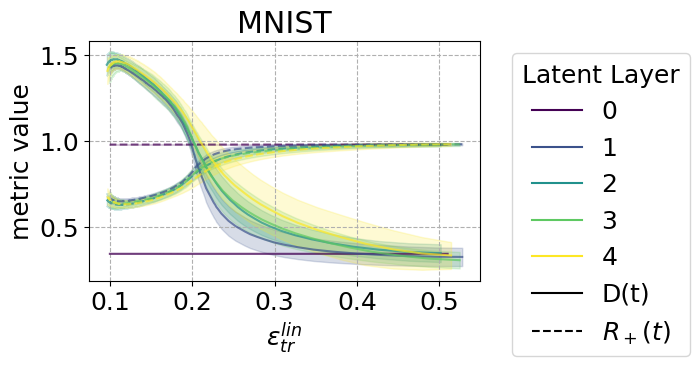

In [ ]:
file_path = f"/content/{DATASET_NAME}_inf_tot_lin_latent_loop_err_tr.txt"

try:
    inf_tot = np.loadtxt(file_path, delimiter='\t', skiprows=1)
    latent_values = inf_tot[:, 8].astype(int)
    unique_latent_values = np.unique(latent_values)

    plt.figure(figsize=(9, 4))

    for i, latent_val in enumerate(unique_latent_values):

        # Select data for the current latent layer
        data_for_latent = inf_tot[inf_tot[:, 8].astype(int) == latent_val]

        train_err = data_for_latent[:, 2]
        dists = data_for_latent[:, 3]
        radii = data_for_latent[:, 4]

        color = plt.cm.viridis(i / (len(unique_latent_values) - 1))
        latent_label = f'Latent {latent_val}'

            # to plot mean and std dev, group by epoch
        unique_epochs = np.unique(data_for_latent[:, 1])

        mean_D = []
        std_D = []
        mean_R = []
        std_R = []
        mean_train_err_per_epoch = []

        for epoch in unique_epochs:
                data_for_epoch = data_for_latent[data_for_latent[:, 1] == epoch]
                if data_for_epoch.shape[0] > 0:
                    mean_D.append(np.mean(data_for_epoch[:, 3]))
                    std_D.append(np.std(data_for_epoch[:, 3]))
                    mean_R.append(np.mean(data_for_epoch[:, 4]))
                    std_R.append(np.std(data_for_epoch[:, 4]))
                    mean_train_err_per_epoch.append(np.mean(data_for_epoch[:, 2]))


        mean_D = np.array(mean_D)
        std_D = np.array(std_D)
        mean_R = np.array(mean_R)
        std_R = np.array(std_R)
        mean_train_err_per_epoch = np.array(mean_train_err_per_epoch)



        plt.plot(mean_train_err_per_epoch, mean_D, color=color, linestyle='-', alpha=0.7, label=f'{latent_label} Distance')
        plt.fill_between(mean_train_err_per_epoch,
                 mean_D - std_D,
                 mean_D + std_D,
                 color=color, alpha=0.2)


        plt.plot(mean_train_err_per_epoch, mean_R, color=color, linestyle='--', alpha=0.7, label=f'{latent_label} Radius')
        plt.fill_between(mean_train_err_per_epoch,
                 mean_R - std_R,
                 mean_R + std_R,
                 color=color, alpha=0.2)



    plt.xlabel(r'$\epsilon^{lin}_{tr}$')
    plt.ylabel('metric value')
    plt.title(f'{DATASET_NAME}')


    legend_elements = []
    for i, latent_val in enumerate(unique_latent_values):
         color = plt.cm.viridis(i / (len(unique_latent_values) - 1 ))
         legend_elements.append(Line2D([0], [0], color=color, label=f'{latent_val}'))

    legend_elements.append(Line2D([0], [0], color='black', linestyle='-', label='D(t)'))
    legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label=r'$R_+(t)$'))


    plt.legend(handles=legend_elements, title="Latent Layer", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", linestyle='--')
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.savefig(f"{DATASET_NAME}_lin_latent_loop.pdf", bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

## Standard feedforward network with linearized weights

In [ ]:

DEPTH = 4
RUNS = 10
EPOCHS = 6000
LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD
WIDTHS = (20,)
ORIGINAL_PDATA = 32768
PDATA = ORIGINAL_PDATA // 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LATENT_VALUES = range(DEPTH+1)


data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)

input_size = data.shape[2] * data.shape[3]


data, labels = data.to(device), labels.to(device)
test_data = data_normalization(test_data, test_labels)
labels_float = labels.float()


data = data_normalization(data, labels)
print_class_stats(data, labels)

m_array = m_array_input(data, labels)
m_array_flat = nn.utils.parameters_to_vector(m_array)


header = "Run\tepoch_max_d\ttrain_err_max_d\tmax_d\tepoch_min_r\ttrain_err_min_r\tmin_r\tWidth\tDepth\tLatent"
with open(f"/content/max_distance_info_linw_{DATASET_NAME}_latent_loop.txt", "w") as f:
    f.write(header + "\n")


results_lin = []
misclassified_all_runs = []
max_distance_info = []

global_run_counter = 0

for LATENT in LATENT_VALUES:
    print(f"\nProcessing with Latent: {LATENT}")
    for run in range(RUNS * len(WIDTHS)):
        WIDTH = WIDTHS[run % len(WIDTHS)]
        print(f"  run: {run}, Width: {WIDTH}")

        net = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init = NN_KHL_logistic(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_init.load_state_dict(net.state_dict())

        theta0_dict = dict(net.named_parameters())
        theta0_flat = nn.utils.parameters_to_vector(list(net.parameters())).detach()


        features = compute_tangent_features_batch(net, theta0_dict, data)


        linearized_net = linearized_NN(features.shape[1]).to(device)
        optimizer = OPTIMIZER(linearized_net.parameters(), lr=LEARNING_RATE)
        criterion = torch.nn.MSELoss()

        results_run = []
        miscls_run = []

        for epoch in range(EPOCHS):
            optimizer.zero_grad()


            with torch.no_grad():
                net_base = net_at_init(data)


            pred_lin = linearized_net(features) + net_base
            loss_lin = criterion(pred_lin, labels_float)
            loss_lin.backward()
            optimizer.step()


            new_weights = torch.squeeze(linearized_net.fc.weight) + theta0_flat
            nn.utils.vector_to_parameters(new_weights, net.parameters())


            with torch.no_grad():
                train_preds = (net(data) >= 0.5).float()
                train_err = torch.abs(train_preds - labels_float).mean().item()
                radii, distance = net.radii(data, labels)

            results_run.append([
                epoch,
                train_err,
                float(loss_lin.item()),
                float(radii[0].item()),
                float(radii[1].item()),
                float(distance),
                int(WIDTH),
                int(DEPTH),
                int(LATENT)
            ])
            miscls_run.append((train_preds != labels).cpu())

        results_lin.append(results_run)
        misclassified_all_runs.append(miscls_run)

        arr = np.array(results_lin[-1], dtype=float)

        dists = arr[:, 5]
        epochs = arr[:, 0]
        train_errs = arr[:, 1]
        radii = arr[:, 4]
        radii0 = arr[:, 3]
        idx_max_dist = np.argmax(dists)
        idx_min_radius = np.argmin(radii)
        idx_min_radius0 = np.argmin(radii0)
        max_distance_info.append([
            global_run_counter,
            int(epochs[idx_max_dist]),
            float(train_errs[idx_max_dist]),
            float(dists[idx_max_dist]),
            int(epochs[idx_min_radius]),
            float(train_errs[idx_min_radius]),
            float(radii[idx_min_radius]),
            float(radii0[idx_min_radius0]),
            int(WIDTH),
            int(DEPTH),
            int(LATENT)
        ])

        global_run_counter += 1

arr_all = np.concatenate([np.array(r, dtype=float) for r in results_lin])

plt.figure(figsize=(10, 6))

for latent_val in LATENT_VALUES:
    data_for_latent = arr_all[arr_all[:, 8] == latent_val]

    if data_for_latent.shape[0] > 0:
        dists = data_for_latent[:, 5]
        radii = data_for_latent[:, 4]
        radii0 = data_for_latent[:, 3]
        train_err = data_for_latent[:, 1]
        latent_label = f'Latent {latent_val}'

        plt.scatter(train_err, dists, color=plt.cm.viridis(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Distance')
        plt.scatter(train_err, radii, color=plt.cm.plasma(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Radius')

plt.xlabel(r'$\hat{\epsilon}_{tr}$')
plt.ylabel('metric value')
plt.legend(title="Latent Layer")
plt.grid(True)
plt.savefig(f"{DATASET_NAME}_linw_latent_loop.pdf", bbox_inches='tight')
plt.show()

max_distance_info_matrix = np.array(max_distance_info)

with open(f"/content/max_distance_info_linw_{DATASET_NAME}_latent_loop_tr_grafico.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.10f', comments='')

with open(f"/content/{DATASET_NAME}_inf_tot_linw_latent_loop_err_tr.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\tWidth\tDepth\tLatent\n")
    for run_data in results_lin:
        arr_run = np.array(run_data, dtype=float)
        for epoch_data in arr_run:
             f.write(f"{int(epoch_data[0])}\t{int(epoch_data[0])}\t{epoch_data[1]:.10f}\t{epoch_data[5]:.10f}\t{epoch_data[4]:.10f}\t{epoch_data[3]:.10f}\t{int(epoch_data[6])}\t{int(epoch_data[7])}\t{int(epoch_data[8])}\n")

Forma del tensore data subito dopo il caricamento: torch.Size([8192, 1, 28, 28])
 class statistics 
class 0:
  cean: 0.0426
  std: 0.8077
class 1:
  cean: -0.0426
  std Dev: 0.7505

Processing with Latent: 0
  run: 0, Width: 20


KeyboardInterrupt: 

## standard feedforward network

In [ ]:
DEPTH = 4
RUNS = 10
EPOCHS = 6000
LEARNING_RATE = 0.1
OPTIMIZER = torch.optim.SGD
WIDTHS = (20,)
ORIGINAL_PDATA=32768
PDATA = int(ORIGINAL_PDATA / 4)

LATENT_VALUES = range(DEPTH+1)

data, labels, test_data, test_labels = load_data(DATASET_NAME, PDATA, DATA_BLOCK)
print("Forma del tensore data subito dopo il caricamento:", data.shape)
input_size = data.shape[2] * data.shape[3]

results_non_lin = []
misclassified_examples_all_runs = []
misclassified_data_max_distance_list = []
multiplier = len(WIDTHS)
max_distance_info = []
straggler_info_non_lin = []
num_stragglers_min_radius=[]
num_stragglers_max_distance=[]

header = "Run\tepoch of max distance\ttrain error of max distance\tmax distance\tepoch of min radius\ttrain error of min radius\tmin radius\tWidth\tDepth\tLatent"
with open(f"/content/max_distance_info_non_lin_{DATASET_NAME}_latent_loop.txt", "w") as f:
    f.write(header + "\n")

global_run_counter = 0

for LATENT in (LATENT_VALUES):
    print(f"\nProcessing with Latent: {LATENT}")
    for run in range(RUNS * multiplier):
        WIDTH = WIDTHS[run % multiplier]

        print("run:" , run, "Width:", WIDTH)
        net = NN_KHL_classification(input_size, DEPTH, WIDTH, LATENT).to(device)
        net_at_initialization = NN_KHL_classification(input_size, DEPTH, WIDTH, LATENT).to(device)
        initial_state = net.state_dict()
        net_at_initialization.load_state_dict(initial_state)

        m_array = m_array_input(data, labels)
        optimizer = OPTIMIZER(net.parameters(), lr=LEARNING_RATE)
        criterion = torch.nn.CrossEntropyLoss()

        results_run = []
        misclassified_examples_run = []

        for epoch in range(EPOCHS):
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_preds = torch.argmax(outputs, dim=1)
            train_error = torch.sum(train_preds != labels).item() / data.shape[0]

            test_preds = torch.argmax(net(test_data), dim=1)
            test_error = torch.sum(test_preds != test_labels).item() / test_data.shape[0]

            radii, distance = net.radii(data, labels)
            results_run.append([
                epoch,
                train_error,
                loss.item(),
                radii[0].item(),
                radii[1].item(),
                distance,
                WIDTH,
                DEPTH,
                LATENT
            ])


            misclassified_mask = train_preds != labels
            misclassified_examples_run.append(misclassified_mask.cpu())

        results_non_lin.append(results_run)
        misclassified_examples_all_runs.append(misclassified_examples_run)


    arr_res_non_lin = np.array(results_non_lin[-1], dtype=float)

    distances_for_run = arr_res_non_lin[:, 5]
    epochs = arr_res_non_lin[:, 0]
    train_errs = arr_res_non_lin[:, 1]
    radii = arr_res_non_lin[:, 4]
    radii0 = arr_res_non_lin[:, 3]

    idx_max_dist = np.argmax(distances_for_run)
    idx_min_radius = np.argmin(radii)
    idx_min_radius0 = np.argmin(radii0)

    max_distance_info.append([
        global_run_counter,
        int(epochs[idx_max_dist]),
        float(train_errs[idx_max_dist]),
        float(distances_for_run[idx_max_dist]),
        int(epochs[idx_min_radius]),
        float(train_errs[idx_min_radius]),
        float(radii[idx_min_radius]),
        float(radii0[idx_min_radius0]),
        int(WIDTH),
        int(DEPTH),
        int(LATENT)
    ])

    global_run_counter += 1


arr_non_lin_all = np.concatenate([np.array(r, dtype=float) for r in results_non_lin])

plt.figure(figsize=(8, 4))

for latent_val in LATENT_VALUES:
    data_for_latent = arr_non_lin_all[arr_non_lin_all[:, 8] == latent_val]

    if data_for_latent.shape[0] > 0:
        dists = data_for_latent[:, 5]
        radii = data_for_latent[:, 4]
        radii0 = data_for_latent[:, 3]
        train_err = data_for_latent[:, 1]
        latent_label = f'Latent {latent_val}'

        plt.scatter(train_err, dists, color=plt.cm.viridis(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Distance')
        plt.scatter(train_err, radii, color=plt.cm.plasma(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), alpha=0.5, label=f'{latent_label} Radius')


plt.xlabel(r'$\epsilon_{tr}$')
plt.ylabel('Metric Value')
plt.title(f'{DATASET_NAME} - Metric Values vs Training Error for Different Latent Layers (Deep)')

legend_elements = []
for latent_val in LATENT_VALUES:
    legend_elements.append(Line2D([0], [0], marker='o', color=plt.cm.viridis(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), label=f'Latent {latent_val} Distance', linestyle='None'))
    legend_elements.append(Line2D([0], [0], marker='o', color=plt.cm.plasma(latent_val / (len(LATENT_VALUES) -1 + 1e-9)), label=f'Latent {latent_val} Radius', linestyle='None'))

plt.legend(handles=legend_elements, title="Latent Layer")
plt.grid(True, which="both", linestyle='--')
plt.savefig(f"{DATASET_NAME}_non_lin_latent_loop.pdf", bbox_inches='tight')
plt.show()


max_distance_info_matrix = np.array(max_distance_info)

with open(f"/content/max_distance_info_non_lin_{DATASET_NAME}_latent_loop.txt", "a") as f:
    np.savetxt(f, max_distance_info_matrix, delimiter='\t', fmt='%.4f', comments='')


with open(f"/content/{DATASET_NAME}_inf_tot_non_lin_latent_loop.txt", "w") as f:
    f.write("Run\tEpoch\tTrain_Error\tDistance\tRadius\tRadius0\tWidth\tDepth\tLatent\n")
    for run_data in results_non_lin:
        arr_run = np.array(run_data, dtype=float)
        for epoch_data in arr_run:
            f.write(f"{int(epoch_data[0])}\t{int(epoch_data[0])}\t{epoch_data[1]:.10f}\t{epoch_data[5]:.10f}\t{epoch_data[4]:.10f}\t{epoch_data[3]:.10f}\t{int(epoch_data[6])}\t{int(epoch_data[7])}\t{int(epoch_data[8])}\n")

### Plot

In this cell, the plot of $D(t)$ and $R_+(t)$ as a function of $ɛ_{tr}^{lin} (t)$ is made, for the different layers in which they are calculated.

The plots represent the average of the observables over the runs (solid line for $D(t)$ and dashed line for $R_+(t)$). The shaded area is centered on the mean and corresponds to ±4 standard deviations.

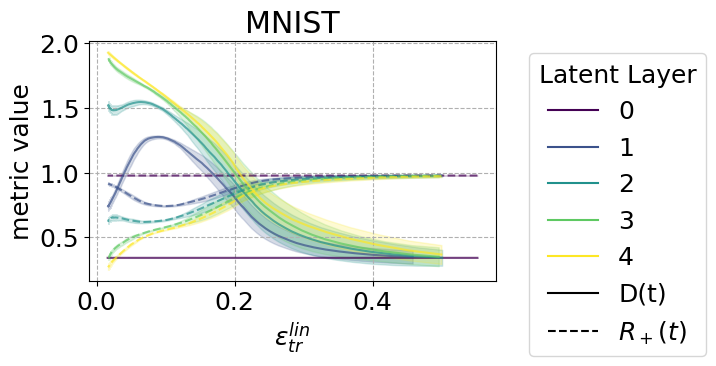

In [ ]:
file_path = f"/content/{DATASET_NAME}_inf_tot_non_lin_latent_loop.txt"

try:
    inf_tot = np.loadtxt(file_path, delimiter='\t', skiprows=1)
    latent_values = inf_tot[:, 8].astype(int)
    unique_latent_values = np.unique(latent_values)

    plt.figure(figsize=(9, 4))

    for i, latent_val in enumerate(unique_latent_values):

        # Select data for the current latent layer
        data_for_latent = inf_tot[inf_tot[:, 8].astype(int) == latent_val]

        train_err = data_for_latent[:, 2]
        dists = data_for_latent[:, 3]
        radii = data_for_latent[:, 4]

        color = plt.cm.viridis(i / (len(unique_latent_values) - 1))
        latent_label = f'Latent {latent_val}'

            # to plot mean and std dev, group by epoch
        unique_epochs = np.unique(data_for_latent[:, 1])

        mean_D = []
        std_D = []
        mean_R = []
        std_R = []
        mean_train_err_per_epoch = []

        for epoch in unique_epochs:
                data_for_epoch = data_for_latent[data_for_latent[:, 1] == epoch]
                if data_for_epoch.shape[0] > 0:
                    mean_D.append(np.mean(data_for_epoch[:, 3]))
                    std_D.append(np.std(data_for_epoch[:, 3]))
                    mean_R.append(np.mean(data_for_epoch[:, 4]))
                    std_R.append(np.std(data_for_epoch[:, 4]))
                    mean_train_err_per_epoch.append(np.mean(data_for_epoch[:, 2]))


        mean_D = np.array(mean_D)
        std_D = np.array(std_D)
        mean_R = np.array(mean_R)
        std_R = np.array(std_R)
        mean_train_err_per_epoch = np.array(mean_train_err_per_epoch)



        plt.plot(mean_train_err_per_epoch, mean_D, color=color, linestyle='-', alpha=0.7, label=f'{latent_label} Distance')
        plt.fill_between(mean_train_err_per_epoch,
                 mean_D - std_D,
                 mean_D + std_D,
                 color=color, alpha=0.2)


        plt.plot(mean_train_err_per_epoch, mean_R, color=color, linestyle='--', alpha=0.7, label=f'{latent_label} Radius')
        plt.fill_between(mean_train_err_per_epoch,
                 mean_R - std_R,
                 mean_R + std_R,
                 color=color, alpha=0.2)



    plt.xlabel(r'$\epsilon^{lin}_{tr}$')
    plt.ylabel('metric value')
    plt.title(f'{DATASET_NAME}')


    legend_elements = []
    for i, latent_val in enumerate(unique_latent_values):
         color = plt.cm.viridis(i / (len(unique_latent_values) - 1 ))
         legend_elements.append(Line2D([0], [0], color=color, label=f'{latent_val}'))

    legend_elements.append(Line2D([0], [0], color='black', linestyle='-', label='D(t)'))
    legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label=r'$R_+(t)$'))


    plt.legend(handles=legend_elements, title="Latent Layer", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", linestyle='--')
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.savefig(f"{DATASET_NAME}_lin_latent_loop.pdf", bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")